In [15]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python.retinotopy import utils as retutils
from pipeline.python.retinotopy import segment_retinotopy as seg

from pipeline.python import utils as putils

from matplotlib.lines import Line2D
import matplotlib.patches as patches

from pipeline.python.classifications import decode_utils as dutils
from pipeline.python.classifications import decode_by_ncells as dc

In [16]:
%matplotlib notebook

In [17]:
n_iterations=100
overlap_thr=0.
n_processes=1
responsive_test='nstds'
responsive_thr=10.
experiment='blobs'
C_value=None

options=['-E', experiment, '-R', responsive_test, '-n', n_processes, '-N', n_iterations, '-o', overlap_thr, '-C', C_value]

opts = dc.extract_options(options)
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

traceid = opts.traceid #'traces001'
response_type = opts.response_type #'dff'
responsive_test = opts.responsive_test #'nstds' # 'nstds' #'ROC' #None
responsive_thr = float(opts.responsive_thr) #10

# CV stuff
m0=int(opts.class_a) #0
m100=int(opts.class_b) #106
n_iterations=int(opts.n_iterations) #100 
n_processes=int(opts.n_processes) #2
overlap_thr = None if opts.overlap_thr in ['None', None] else float(opts.overlap_thr)

stim_filterby = None #'first'
has_gratings = experiment!='blobs'
g_str = 'hasgratings' if has_gratings else 'blobsonly'

do_cv = C_value is None
C_value = None if do_cv else float(opts.C_value)
print('Classify Morph %i v %i\nN=%i iterations (%i proc), overlap=%s, C=%s' \
      % (m0, m100, n_iterations, n_processes, str(overlap_thr), str(C_value)))


Classify Morph 0 v 106
N=100 iterations (1 proc), overlap=0.0, C=None


In [18]:
train_str = 'traintest_by-fov_iter-%i' % (n_iterations)

# Set colors
visual_area, area_colors = putils.set_threecolor_palette(soft=True)
dpi = putils.set_plot_params()

#### Responsive params
n_stds = None if responsive_test=='ROC' else 2.5 #None
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 

#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')
decoding_dir = os.path.join(aggregate_dir, 'decoding')

# Create data ID for labeling figures with data-types
filter_str = 'filter_%s_%s' % (stim_filterby, g_str)
data_id = '|'.join([traceid, filter_str, response_str])
print(data_id)

traces001|filter_None_blobsonly|dff_nstds-thr-10.00


# Set ouptut dir

In [19]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

decoding_dir = os.path.join(aggregate_dir, 'decoding')
print(decoding_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding


# Individual FOVs

In [20]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
sdata['visual_area'].unique()

Segmentation: missing 9 dsets


array([u'Li', u'Ll', u'Lm', u'V1'], dtype=object)

In [21]:
reload(dc)

<module 'pipeline.python.classifications.decode_by_ncells' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_by_ncells.pyc'>

In [22]:
split_pupil=False
C_value=None
trial_epoch='plushalf'
overlap_thr=0

animalid='JC097'
session = '20190617'
fov='FOV1_zoom2p0x'
visual_area = 'V1'
analysis_type = 'split_pupil' if split_pupil else 'by_fov'
#results_prefix = analysis_type

# Get result ID
iterdf, results_id = dc.load_fov_results(animalid, session, fov, traceid=traceid, visual_area=visual_area, 
                            C_value=C_value, response_type=response_type, responsive_test=responsive_test,
                            trial_epoch=trial_epoch, overlap_thr=None, has_retino=False)
print(results_id, iterdf.shape)

iterdf.groupby(['condition']).mean().reset_index()

('by_fov_V1__dff-nstds_noRF__plushalf__tuneC', (200, 15))


condition        C  fit_time  heldout_MI  heldout_aMI  heldout_log2MI  \
0      data  0.01774  0.014009    0.138624     0.189631        0.199992   
1  shuffled  0.03448  0.016310    0.010249     0.001994        0.014786   

   heldout_test_score  score_time  test_score  train_score  n_cells  n_trials  \
0            0.744828    0.003308    0.742529     0.946787    272.0     290.0   
1            0.509655    0.003468    0.516585     0.828703    272.0     290.0   

   iteration  
0       49.5  
1       49.5

# Load all data

In [149]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

In [150]:
curr_visual_area=None #'V1'
curr_datakey = None# '20190617_JC097_fov1'

#### Load neural responses
analysis_type='by_fov'
trial_epoch='plushalf'
responsive_test='nstds' #'roc'
responsive_thr=10. #0.05
response_type='dff'

#### Check for equal trial counts
# stack_neuraldf = analysis_type in ['by_ncells']
visual_areas=['V1', 'Lm', 'Li'] #, 'Ll']
_, all_cells, MEANS, SDF = aggr.get_source_data(experiment,
                        equalize_now=True, zscore_now=True,
                        response_type=response_type, responsive_test=responsive_test,
                        responsive_thr=responsive_thr, trial_epoch=trial_epoch,
                        visual_area=curr_visual_area, datakey=curr_datakey,
                        check_configs=True, return_configs=True, return_missing=False,
                        images_only=analysis_type=='by_ncells')
all_cells = all_cells[all_cells['visual_area'].isin(visual_areas)]
all_cells.groupby(['visual_area']).count()


Segmentation: missing 9 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15   0], y: [-5  0]
(skipping 20190314_JC070_fov1)
---equalizing now---
Segmentation: missing 9 dsets
SDF, images_only=False (excluding dsetes: [])
Segmentation: missing 3 dsets


cell   fov  animalid  session  datakey  fovnum  global_ix
visual_area                                                           
Li           1142  1142      1142     1142     1142    1142       1142
Lm           1970  1970      1970     1970     1970    1970       1970
V1           2089  2089      2089     2089     2089    2089       2089

# 1. Compare filter methods

In [159]:
i_=[]; no_ret=[]; no_rf=[]; no_results=[];
for (visual_area, animalid, session, fov, datakey), g in \
                all_cells.groupby(['visual_area', 'animalid', 'session', 'fov', 'datakey']):
    iterdf, results_id = dc.load_fov_results(animalid, session, fov, traceid=traceid, visual_area=visual_area, 
                            C_value=C_value, response_type=response_type, responsive_test=responsive_test,
                            trial_epoch=trial_epoch, overlap_thr=None, has_retino=False)

    iterdf_rf, results_id_rf = dc.load_fov_results(animalid, session, fov, traceid=traceid,visual_area=visual_area, 
                                C_value=C_value, response_type=response_type, responsive_test=responsive_test,
                                trial_epoch=trial_epoch, overlap_thr=0.0, has_retino=False)
    
    iterdf_ret, results_id_ret = dc.load_fov_results(animalid, session, fov, traceid=traceid, visual_area=visual_area, 
                                C_value=C_value, response_type=response_type, responsive_test=responsive_test,
                                trial_epoch=trial_epoch, overlap_thr=None, has_retino=True)
    
    if iterdf is None and iterdf_rf is None and iterdf_ret is None:
        print("(%s, %s) None" % (visual_area, datakey))
        continue
    
    if iterdf is None:
        no_results.append((visual_area, datakey)) #print("(%s, %s) No results" % (visual_area, datakey))
    else:
        iterdf['filter'] = responsive_test
        
    if iterdf_rf is None:
        no_rf.append((visual_area, datakey)) #print("(%s, %s) No RF" % (visual_area, datakey))
    else:
        iterdf_rf['filter'] = 'rf'
        
    if iterdf_ret is None:
        no_ret.append((visual_area, datakey)) #print("(%s, %s) No retino" % (visual_area, datakey))
    else:
        iterdf_ret['filter'] = 'retino'

    iterd = pd.concat([iterdf, iterdf_rf, iterdf_ret], axis=0).reset_index(drop=True)
    iterd['visual_area'] = visual_area
    iterd['datakey'] = datakey
    i_.append(iterd)

iterd = pd.concat(i_, axis=0).reset_index(drop=True)
# iterd.groupby(['condition', 'visual_area', 'filter']).mean().reset_index()


(Lm, 20191111_JC120_fov1) None


In [160]:
print("%i have no responsive cells (%s): %s" % (len(no_results), responsive_test, str(no_results)))
print("%i have no RFs cells:" % len(no_rf))
for r in no_rf:
    print(r)
print("%i have no Retino cells:" % len(no_ret))
for r in no_ret:
    print(r)


1 have no responsive cells (nstds): [(u'Li', '20191018_JC113_fov1')]
12 have no RFs cells:
(u'Li', '20190319_JC067_fov1')
(u'Li', '20190320_JC067_fov1')
(u'Li', '20190314_JC070_fov1')
(u'Li', '20190315_JC070_fov1')
(u'Li', '20190316_JC070_fov1')
(u'Li', '20190321_JC070_fov1')
(u'Li', '20190322_JC073_fov1')
(u'Li', '20190327_JC073_fov1')
(u'Li', '20190422_JC076_fov1')
(u'Lm', '20190306_JC061_fov3')
(u'Lm', '20190322_JC073_fov1')
(u'Lm', '20190327_JC073_fov1')
3 have no Retino cells:
(u'Li', '20190327_JC073_fov1')
(u'Li', '20191018_JC113_fov1')
(u'Lm', '20190327_JC073_fov1')


In [161]:
datakey = '20191006_JC110_fov1'
session, animalid, fovnum = putils.split_datakey_str(datakey)
fov = 'FOV%i_zoom2p0x' % fovnum
visual_area = 'V1'

traceid='traces001'
rootdir = '/n/coxfs01/2p-data'

iterdf_ret, results_id_ret = dc.load_fov_results(animalid, session, fov, traceid=traceid, visual_area=visual_area, 
                            C_value=C_value, response_type=response_type, responsive_test=responsive_test,
                            trial_epoch=trial_epoch, overlap_thr=None, has_retino=True)

results_id = dc.create_results_id(prefix='by_fov', visual_area=visual_area,
                                C_value=C_value, response_type=response_type, responsive_test=responsive_test,
                                trial_epoch=trial_epoch, overlap_thr=0.0, has_retino=False)
print(results_id)
iterdf_ret is None

by_fov_V1__dff-nstds_overlap0.0__plushalf__tuneC


False

In [162]:
traceid_dir = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_blobs*',
                        'traces', '%s*' % traceid))[0]
curr_dst_dir = os.path.join(traceid_dir, 'decoding')
print(curr_dst_dir)

/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_3b3744_traces001_1990cb_traces001_58a59f_traces001_c760ae_traces001_00f36c_traces001_6f6bcc_traces001_13f7f0/decoding


In [163]:
[os.path.split(f)[-1] for f in glob.glob(os.path.join(curr_dst_dir, 'by_fov_*'))]
#os.listdir(curr_dst_dir)

['by_fov_V1_tuneC__dff-nstds_overlap-0.0.pkl',
 'by_fov_V1_tuneC__dff-nstds_overlap-0.0__plushalf.pkl',
 'by_fov_V1__dff-nstds_no-rfs__plushalf__tuneC.pkl',
 'by_fov_V1__dff-nstds_overlap0.0__plushalf__tuneC.pkl',
 'by_fov_V1__dff-nstds_noRF__plushalf__tuneC.pkl',
 'by_fov_V1__dff-nstds_threshdff__plushalf__tuneC.pkl',
 'by_fov_V1__dff-nstds_retino__plushalf__tuneC.pkl']

In [164]:
visual_areas=['V1', 'Lm', 'Li']

meand = iterd.groupby(['filter', 'visual_area', 'datakey', 'condition']).mean().reset_index()

meand = meand[meand['visual_area'].isin(visual_areas)]


In [165]:
meand['animalid'] = [s.split('_')[1] for s in meand['datakey']]

In [166]:
all_rats = meand['animalid'].unique()
old_ = [a for a in all_rats if int(a[2:])<76]
old_

['JC070', 'JC067', 'JC073', 'JC061']

In [168]:
old_keys # 20190320_JC067_fov1

array(['20190315_JC070_fov1', '20190316_JC070_fov1',
       '20190319_JC067_fov1', '20190321_JC070_fov1',
       '20190322_JC073_fov1'], dtype=object)

In [99]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

<IPython.core.display.Javascript object>


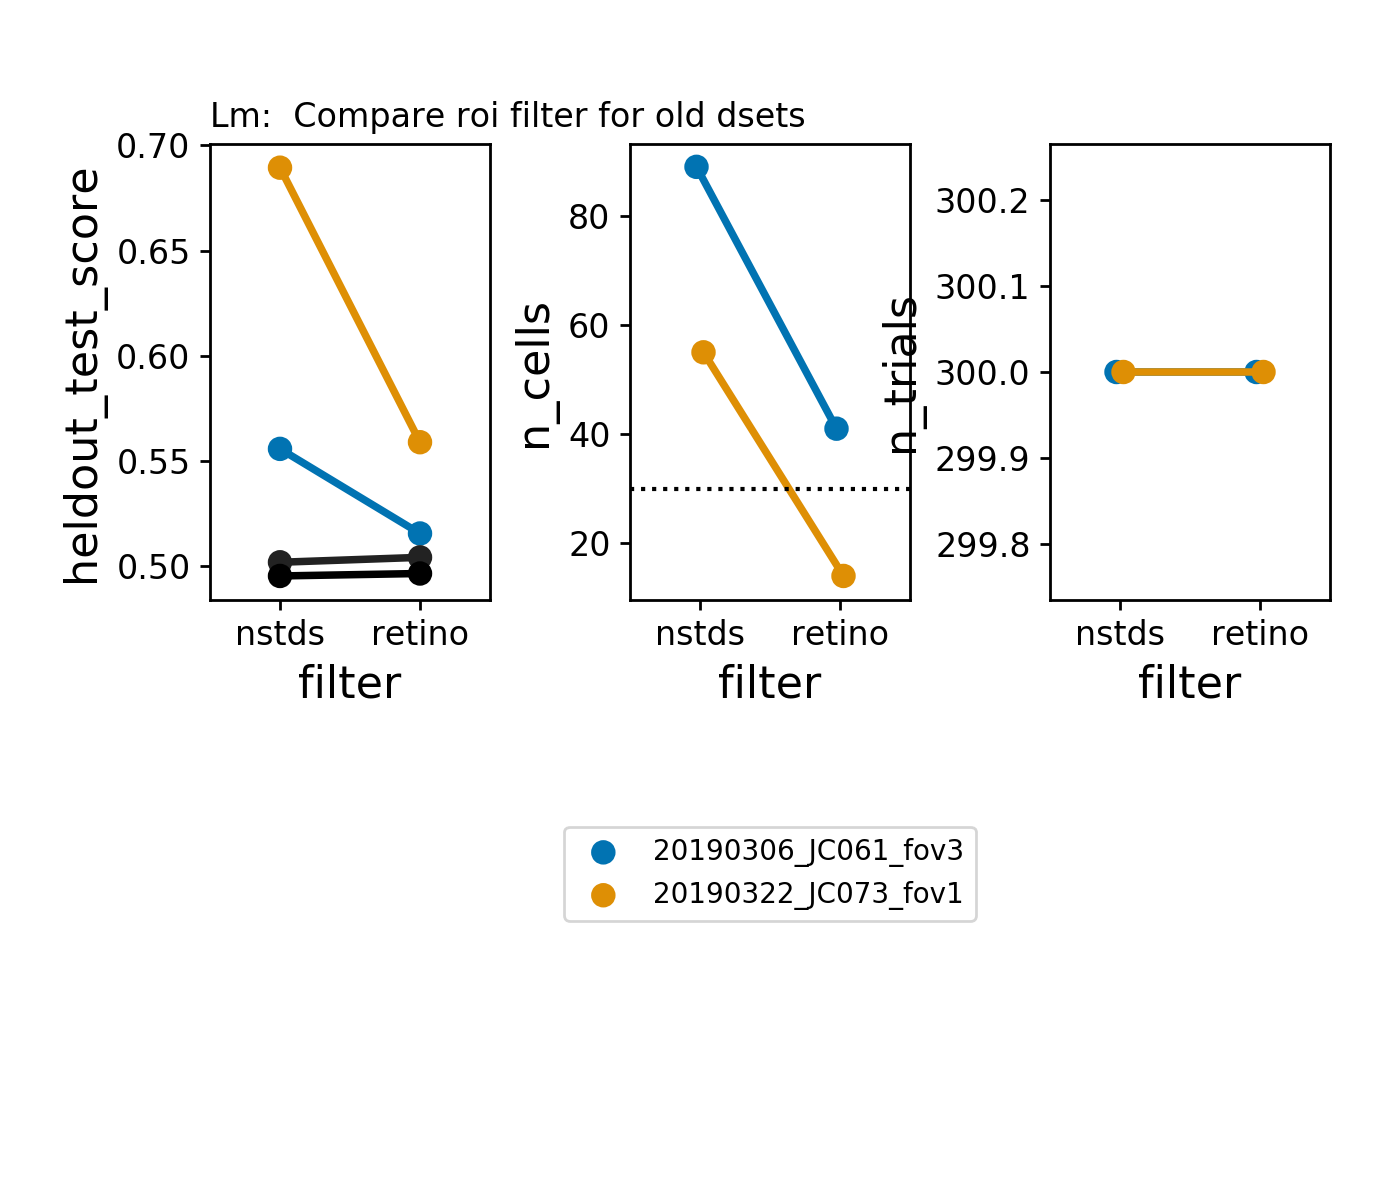

In [177]:
metric = 'heldout_test_score'

visual_area = 'Lm'
vdf = meand[meand.visual_area==visual_area].copy()

subd0 = vdf[(vdf['animalid'].isin(old_))]
subd = pd.concat([g for dk, g in subd0.groupby(['datakey']) \
           if ('nstds' in g['filter'].values) & ('retino' in g['filter'].values)])

old_keys = subd['datakey'].unique()
sns.set_palette('colorblind')

# Plot true
fig, axn = pl.subplots(1,3, figsize=(7,6))
ax=axn[0]
sns.pointplot(x='filter', y=metric, hue='datakey', data=subd[subd['condition']=='data'], ax=ax)
sns.pointplot(x='filter', y=metric, hue='datakey', data=subd[subd['condition']=='shuffled'], ax=ax, 
             color='k', alpha=0.5)
aggr.crop_legend_labels(ax, n_hues=len(old_keys))
ax.set_title("%s:  Compare roi filter for old dsets" % visual_area, loc='left')
ax.legend_.remove() #(bbox_to_anchor=(0.5, -0.1), loc='center')


countd = subd[subd['condition']=='data'][['filter', 'datakey', 'n_cells', 'n_trials']].drop_duplicates()
ax=axn[1]
sns.pointplot(x='filter', y='n_cells', hue='datakey', data=countd, ax=ax, dodge=True) #x_jitter=0.2)    
ax.legend(bbox_to_anchor=(0.5, -0.6), loc='center')
ax.axhline(y=30, linestyle=':', color='k')

ax=axn[2]
sns.pointplot(x='filter', y='n_trials', hue='datakey', data=countd, ax=ax, dodge=True)
ax.legend_.remove()

pl.subplots_adjust(left=0.15, right=0.95, bottom=0.5, wspace=0.5)

In [174]:
countd

filter              datakey  n_cells  n_trials
0     nstds  20190314_JC070_fov1     47.0     300.0
96   retino  20190314_JC070_fov1      7.0     300.0
2     nstds  20190315_JC070_fov1     96.0     300.0
98   retino  20190315_JC070_fov1     25.0     300.0
4     nstds  20190316_JC070_fov1     84.0     300.0
100  retino  20190316_JC070_fov1     11.0     300.0
6     nstds  20190319_JC067_fov1     26.0     300.0
102  retino  20190319_JC067_fov1     13.0     300.0
8     nstds  20190320_JC067_fov1     14.0     300.0
104  retino  20190320_JC067_fov1      4.0     300.0
10    nstds  20190321_JC070_fov1     13.0     250.0
106  retino  20190321_JC070_fov1      5.0     250.0
12    nstds  20190322_JC073_fov1    132.0     300.0
108  retino  20190322_JC073_fov1     24.0     300.0

filter              datakey  n_cells  n_trials  heldout_test_score
10    nstds  20190321_JC070_fov1     13.0     250.0            0.466400
6     nstds  20190319_JC067_fov1     26.0     300.0            0.454000
4     nstds  20190316_JC070_fov1     84.0     300.0            0.590667
2     nstds  20190315_JC070_fov1     96.0     300.0            0.653167
12    nstds  20190322_JC073_fov1    132.0     300.0            0.621833
102  retino  20190321_JC070_fov1      5.0     250.0            0.480200
98   retino  20190316_JC070_fov1     11.0     300.0            0.573167
100  retino  20190319_JC067_fov1     13.0     300.0            0.456333
104  retino  20190322_JC073_fov1     24.0     300.0            0.568667
96   retino  20190315_JC070_fov1     25.0     300.0            0.604667

In [53]:
#### Filter really bad ones (shuffled acc. better than true)
metric='heldout_test_score'
for (visual_area, datakey, expfilter), g in meand.groupby(['visual_area', 'datakey', 'filter']):
    if float(g[g['condition']=='shuffled'][metric].values) > float(g[g['condition']=='data'][metric].values):
        print('[%s] %s (%s, %i)' % (visual_area, datakey, expfilter, int(g['n_cells'].unique())))
        
passd = pd.concat([g for (visual_area, datakey, expfilter), g \
            in meand.groupby(['visual_area', 'datakey', 'filter']) \
        if float(g[g['condition']=='shuffled'][metric].values) < float(g[g['condition']=='data'][metric].values)])
print(meand[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
print(passd[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())


[Li] 20190319_JC067_fov1 (nstds, 26)
[Li] 20190319_JC067_fov1 (retino, 13)
[Li] 20190320_JC067_fov1 (nstds, 14)
[Li] 20190321_JC070_fov1 (nstds, 13)
[Li] 20190321_JC070_fov1 (retino, 5)
[Li] 20190612_JC099_fov1 (retino, 9)
[V1] 20190508_JC083_fov1 (retino, 13)
             datakey
visual_area         
Li                16
Lm                14
V1                16
             datakey
visual_area         
Li                13
Lm                14
V1                16


In [102]:
passd[(passd['condition']=='data') 
    & (passd['filter']=='rf') & (passd['visual_area']=='V1')][['datakey', metric, 'n_cells']]

datakey  heldout_test_score  n_cells
204  20190420_JC076_fov1            0.614500      6.0
206  20190501_JC076_fov1            0.540667      9.0
208  20190507_JC083_fov1            0.868500     55.0
210  20190508_JC083_fov1            0.601379      8.0
212  20190510_JC083_fov1            0.790286     31.0
214  20190511_JC083_fov1            0.737333     41.0
216  20190512_JC083_fov1            0.563710      7.0
218  20190522_JC084_fov1            0.761167    106.0
220  20190613_JC097_fov1            0.712667     96.0
222  20190616_JC097_fov1            0.779500    137.0
224  20190617_JC097_fov1            0.699828     83.0
226  20190622_JC085_fov1            0.667500     87.0
228  20191006_JC110_fov1            0.736515     83.0

In [101]:
passd[(passd['condition']=='data') 
    & (passd['filter']=='rf') & (passd['visual_area']=='Li')][['datakey', metric, 'n_cells']]

datakey  heldout_test_score  n_cells
168  20190602_JC091_fov1            0.785345     58.0
170  20190606_JC091_fov1            0.562969     16.0
172  20190607_JC091_fov1            0.616833     31.0
174  20190609_JC099_fov1            0.647833     21.0
176  20190612_JC099_fov1            0.597167     13.0
178  20190614_JC091_fov1            0.637333     40.0
180  20191018_JC113_fov1            0.587632      6.0

In [54]:
curr_dst_dir = os.path.join(decoding_dir, 'by_fov', 'compare_metrics')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/compare_metrics


In [55]:
#### Set copmarison colors
n_hues = len(passd['filter'].unique())
colors = ['navy', 'orange', 'green']
labels = [responsive_test, 'retino', 'rf']
filter_colors = dict((k, v) for k, v in zip(labels, colors))


             datakey
visual_area         
Li                13
Lm                14
V1                16


<IPython.core.display.Javascript object>


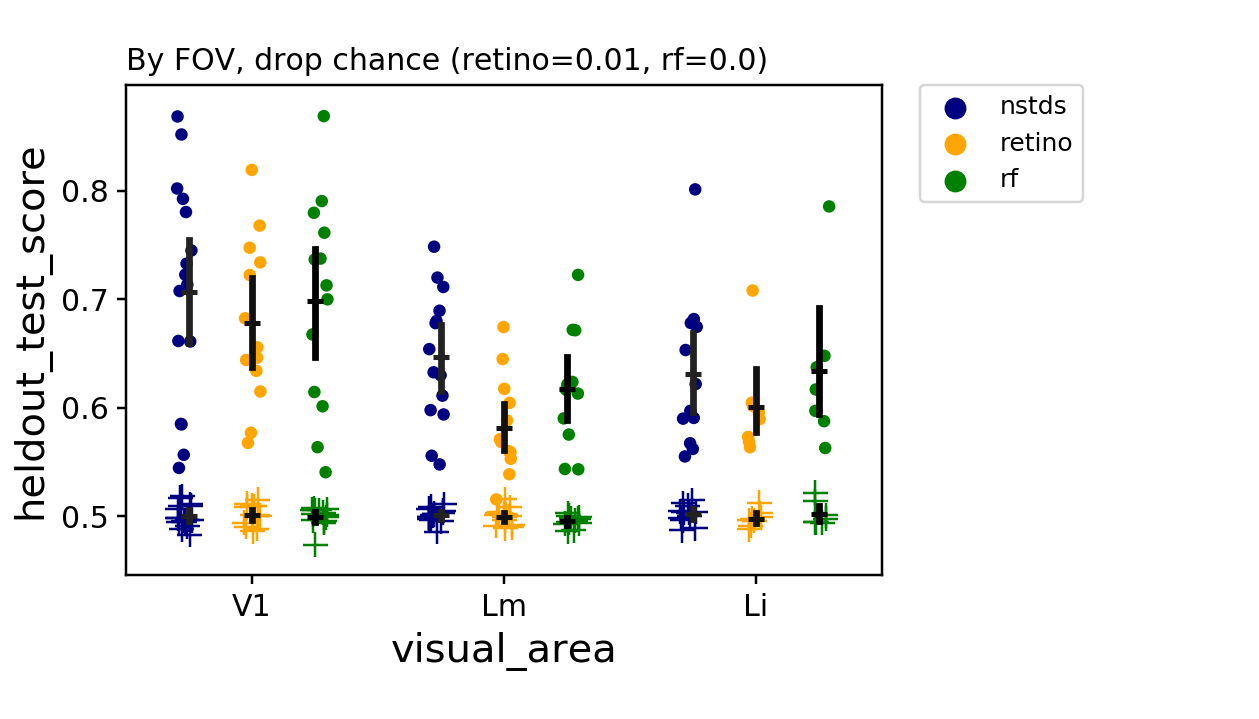

In [56]:
d_ = passd.copy()

print(d_[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())


fig, ax = pl.subplots(figsize=(7,4))
metric = 'heldout_test_score'

# Plot true
sns.stripplot(x='visual_area', y=metric, data=d_[d_['condition']=='data'], ax=ax, 
              hue='filter', palette=filter_colors, dodge=True, order=visual_areas, zorder=0)
sns.pointplot(x='visual_area', y=metric, data=d_[d_['condition']=='data'], ax=ax, 
              hue='filter', color='k', dodge=0.5, join=False, markers='_', 
              order=visual_areas, zorder=0)

# Plot shuffled
sns.stripplot(x='visual_area', y=metric, data=d_[d_['condition']=='shuffled'], ax=ax, 
              hue='filter', palette=filter_colors, dodge=True, marker='+', s=10, linewidth=1,
               order=visual_areas, zorder=0)
sns.pointplot(x='visual_area', y=metric, data=d_[d_['condition']=='shuffled'], ax=ax, 
              hue='filter', color='k', dodge=0.5, join=False, markers='_',  order=visual_areas, zorder=0)

# Legend
leg = aggr.crop_legend_labels(ax, n_hues, bbox_to_anchor=(1.05, 1))

pl.subplots_adjust(right=0.7, left=0.1, bottom=0.2)

ax.set_title("By FOV, drop chance (retino=0.01, rf=0.0)", loc='left')

pl.savefig(os.path.join(curr_dst_dir, 'retino_vs_rf_filters_all_pass.svg'))

#### Compare paired

In [57]:
compare_var='filter'
c1= responsive_test
c2='rf'

bothd = pd.concat([g for (v, dk), g in passd.groupby(['visual_area', 'datakey']) \
             if c1 in g['filter'].values and c2 in g['filter'].values])
bothd.shape, meand.shape

((174, 16), (230, 16))

<IPython.core.display.Javascript object>


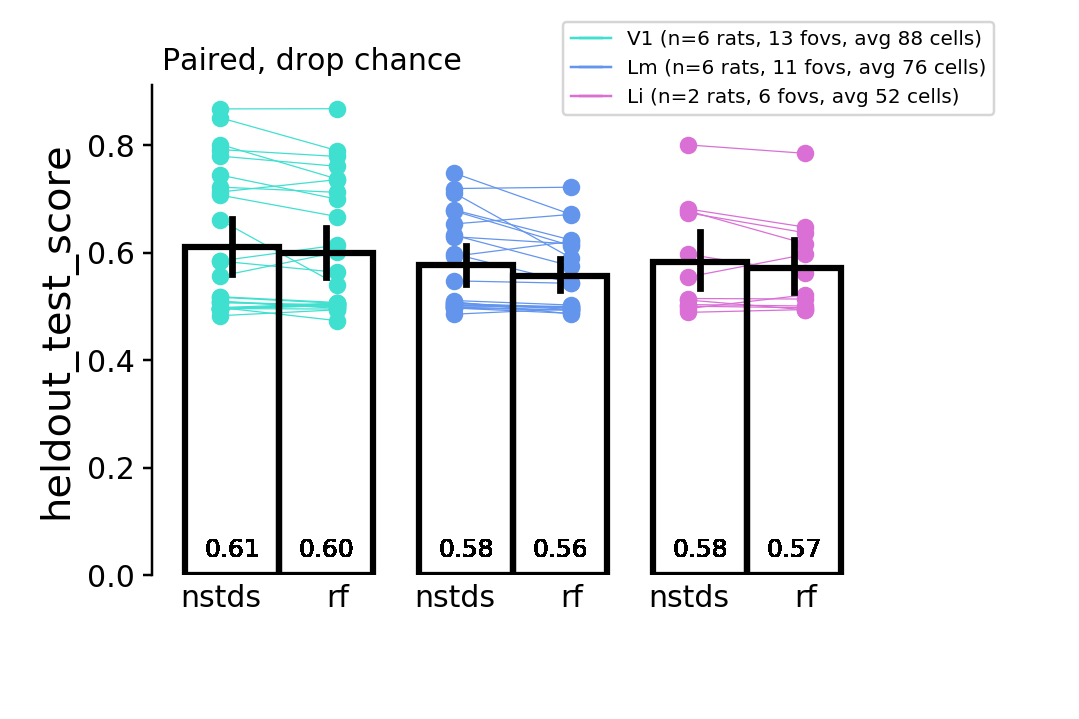

V1: (t-stat:1.86, p=0.07)
Lm: (t-stat:2.80, p=0.01)
Li: (t-stat:1.36, p=0.20)


In [58]:
fig, ax = pl.subplots(figsize=(6,4))
ax = aggr.plot_pairwise_by_axis(bothd, curr_metric=metric, c1=c1, c2=c2, compare_var=compare_var,
                                ax=ax, area_colors=area_colors, legend=True, bbox_to_anchor=(1.2, 1.15))

# Get counts of samples for legend
#legend_elements = aggr.get_counts_for_legend(bothd, area_colors=area_colors)
#ax.legend(handles=legend_elements, bbox_to_anchor=(1.3,1.1), fontsize=8)

pl.subplots_adjust(left=0.15, right=0.8, bottom=0.2)

ax.set_title("Paired, drop chance", loc='left')

pl.savefig(os.path.join(curr_dst_dir, '%s_vs_%s_%s_all_pass_paired.svg' % (c1, c2, compare_var)))

#### Compare N cells and accuracy for both filter typesm

<IPython.core.display.Javascript object>


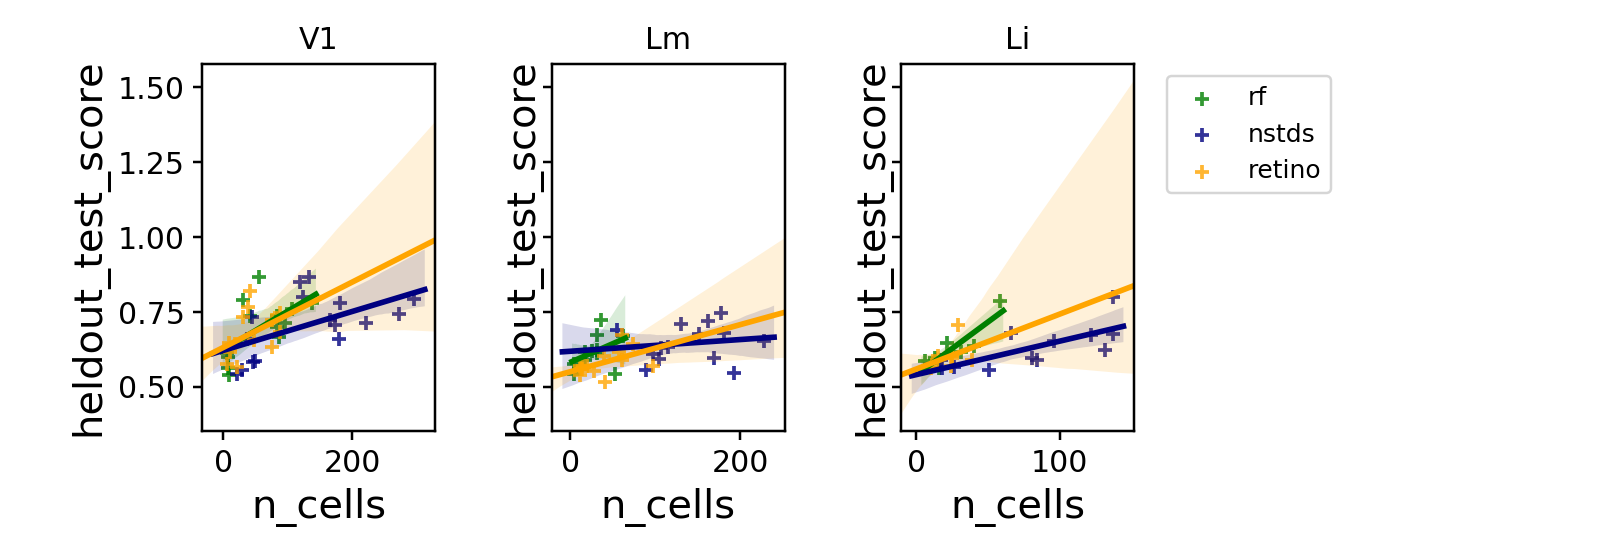

In [59]:
color_by_filter=True

subd = passd[passd['condition']=='data'][['visual_area', 'datakey', 'filter', 'n_cells', metric]].copy()

fig, axn = pl.subplots(1,3, figsize=(9,3), sharex=not color_by_filter, sharey=True)
for v, g in subd.groupby(['visual_area']):
    if v=='Ll':
        continue
    ai=visual_areas.index(v)
    ax=axn[ai]
    if color_by_filter:
        for filter_name, filter_color in filter_colors.items():
            sns.regplot(x='n_cells', y=metric, ax=ax, data=g[g['filter']==filter_name], 
                        color=filter_color, label=filter_name, marker='+')
    else:
        sns.regplot(x='n_cells', y=metric, ax=ax, data=g, color='k')
        for filter_name, filter_color in filter_colors.items():
            ax.scatter(g[g['filter']==filter_name]['n_cells'], g[g['filter']==filter_name][metric], 
                       color=filer_color, label=filer_name)
    ax.set_title(v)

axn[-1].legend(bbox_to_anchor=(1.9, 1))

pl.subplots_adjust(bottom=0.2, right=0.7, wspace=0.5)

pl.savefig(os.path.join(curr_dst_dir, 'ncells_by_%s__compare3.svg' % metric))

In [84]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

# Filter cells

In [62]:
from pipeline.python.retinotopy import fit_2d_rfs as fitrf

In [63]:
sdf = aggr.get_master_sdf(images_only=analysis_type=='by_ncells')
sdf.head()

color morphlevel   object  size stimtype  xpos  ypos yrot
config006                0  Blob_N1  10.0    image    20    -8    0
config007                0  Blob_N1  20.0    image    20    -8    0
config008                0  Blob_N1  30.0    image    20    -8    0
config009                0  Blob_N1  40.0    image    20    -8    0
config010                0  Blob_N1  50.0    image    20    -8    0

In [64]:
reload(dc)

<module 'pipeline.python.classifications.decode_by_ncells' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_by_ncells.pyc'>

In [65]:
ndata_df, cells_df = dc.get_cells_and_data(all_cells, MEANS, traceid=traceid, response_type=response_type, stack_neuraldf=True,
                                   overlap_thr=None, has_retino=False, threshold_snr=False)

ndata_rf, cells_rf = dc.get_cells_and_data(all_cells, MEANS, traceid=traceid, response_type=response_type, stack_neuraldf=True,
                                   overlap_thr=0.0, has_retino=False, threshold_snr=False)

ndata_ret, cells_ret = dc.get_cells_and_data(all_cells, MEANS, traceid=traceid, response_type=response_type, stack_neuraldf=True,
                                   overlap_thr=None, has_retino=True, threshold_snr=False)

Segmentation: missing 9 dsets
Segmentation: missing 9 dsets
~~~~~~~~~~~~~~~~No Receptive Fields~~~~~~~~~~~~~~~~~~~~~~~~~
Assigned visual areas: [u'Li' u'Lm' u'V1']
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 2089, u'Lm': 1964, u'Li': 1069}
------------------------------------
Segmentation: missing 9 dsets
Segmentation: missing 9 dsets
~~~~~~~~~~~~~~~~Loading RFs~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
N dpaths: 38, N unfit: 0
N datasets included: 45, N sessions excluded: 4
~~~~~~~~~~~~~~~~Calculating overlaps (thr=0.00)~~~~~~~~~~~~~
375 of 375 cells pass overlap (thr=0.00)
Assigned visual areas: [u'Li' u'Lm' u'V1']
               datakey  dset_roi  global_ix  roi visual_area animalid  \
0  20190602_JC091_fov1      15.0        392    0          Li    JC091   
1  20190602_JC091_fov1      16.0        393    1          Li    JC091   
2  20190602_JC091_fov1      22.0        396    2          Li    JC091   
3  20190602_JC091_fov1      23.0        397    3          Li    JC091   
4  20190602_JC091_fov1 

In [67]:
print("%s counts:" % responsive_test, cells_df.groupby(['visual_area'])['cell'].count())
print("RF counts:", cells_rf.groupby(['visual_area'])['cell'].count())
print("RETINO counts:", cells_ret.groupby(['visual_area'])['cell'].count())

('nstds counts:', visual_area
Li    1069
Lm    1964
V1    2089
Name: cell, dtype: int64)
('RF counts:', visual_area
Li    188
Lm    318
V1    758
Name: cell, dtype: int64)
('RETINO counts:', visual_area
Li    218
Lm    518
V1    569
Name: cell, dtype: int64)


In [68]:
cells_df.head()

datakey  dset_roi  global_ix  roi visual_area animalid  \
0  20190315_JC070_fov1      85.0          0    0          Li    JC070   
1  20190315_JC070_fov1      86.0          1    1          Li    JC070   
2  20190315_JC070_fov1      99.0          2    2          Li    JC070   
3  20190315_JC070_fov1     102.0          3    3          Li    JC070   
4  20190315_JC070_fov1     103.0          4    4          Li    JC070   

    session  fovnum   cell  
0  20190315       1   85.0  
1  20190315       1   86.0  
2  20190315       1   99.0  
3  20190315       1  102.0  
4  20190315       1  103.0

## Which cells in each group?

In [74]:
import matplotlib_venn as mpvenn

In [75]:
cells_ret['filter'] = 'retino'
cells_rf['filter'] = 'rf'
cells_df['filter'] = responsive_test

In [76]:
gcells = pd.concat([cells_df, cells_ret, cells_rf], axis=0).reset_index(drop=True)


<IPython.core.display.Javascript object>


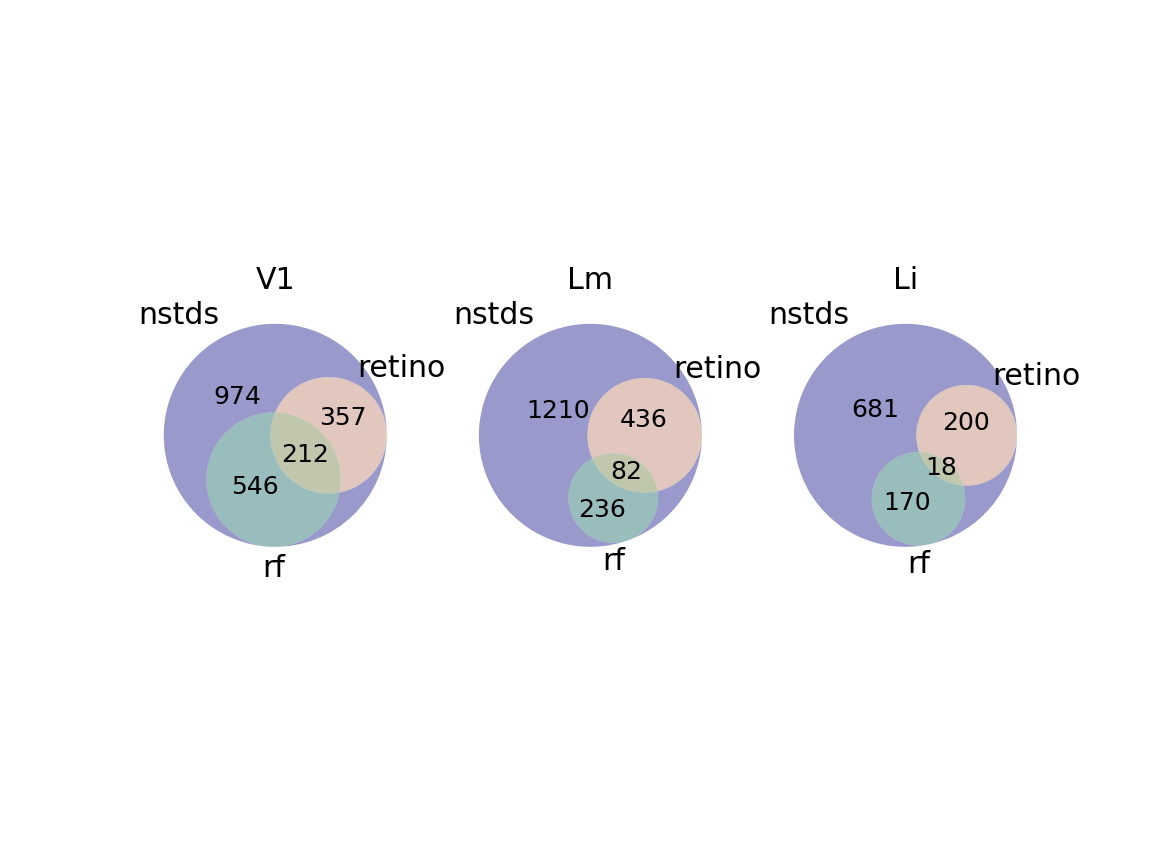

(936, 9)


In [77]:
fig, axn = pl.subplots(1,3)
h_=[]
for varea, gc in gcells.groupby(['visual_area']):
    ax=axn[visual_areas.index(varea)]

    filter_colors
    d0 = gc[gc['filter']==responsive_test]['global_ix']
    d1 = gc[gc['filter']=='retino']['global_ix']
    d2 = gc[gc['filter']=='rf']['global_ix']
    
    filter_order = (responsive_test, 'retino', 'rf')
    filter_c = tuple(filter_colors[f] for f in filter_order)
    mpvenn.venn3([set(d0), set(d1), set(d2)], set_labels=filter_order, ax=ax, 
                 set_colors=filter_c)
    #mpvenn.venn2([set(d1), set(d2)], set_labels=('retino', 'rf'), ax=ax, set_colors=('r', 'b'))
    ax.set_title(varea)
    
    h_.append(gc[gc['global_ix'].isin(np.intersect1d(d1, d2))])
has_both = pd.concat(h_, axis=0).drop(labels=['filter'], axis=1).drop_duplicates().reset_index(drop=True)
print(has_both.shape)

In [101]:
filter_c

('navy', 'orange', 'green')

In [141]:
has_both.groupby(['visual_area']).count()#shape

datakey  dset_roi  global_ix  roi  animalid  session  fovnum  \
visual_area                                                                 
Li                54        54         54   54        54       54      54   
Lm               231       231        231  231       231      231     231   
V1               636       636        636  636       636      636     636   

             cell  
visual_area        
Li             54  
Lm            231  
V1            636

## How does these cells compare to pass_single cells?

In [149]:
def load_single_cells_pass(aggregate_dir='/n/coxfs01/julianarhee/aggregate-visual-areas'):
    
    tmp_out = os.path.join(aggregate_dir, 'decoding', 'single_cells', 'single_cells_percentiles.pkl')
    # /n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells/single_cells_percentiles.pkl

    with open(tmp_out, 'rb') as f:
        pass_single = pkl.load(f) 
        
    # Turn into global 
#     pass_single['dset_roi'] = pass_single['cell']
#     pass_single['roi'] = 0
#     for v, g in pass_single.groupby(['visual_area']):
#         pass_single['roi'].loc[g.index] = np.arange(0, g.shape[0])

    return pass_single

In [150]:
single_perc = load_single_cells_pass()
single_perc = single_perc[single_perc['visual_area'].isin(visual_areas)]
single_perc.groupby(['visual_area']).count()

C  cell  datakey  global_ix  heldout_MI  heldout_aMI  \
visual_area                                                            
Li           1138  1138     1138       1138        1138         1138   
Lm           1969  1969     1969       1969        1969         1969   
V1           2081  2081     2081       2081        2081         2081   

             heldout_log2MI  heldout_test_score  mean_score  n_iterations  \
visual_area                                                                 
Li                     1138                1138        1138          1138   
Lm                     1969                1969        1969          1969   
V1                     2081                2081        2081          2081   

             n_trials  percentile  test_score  train_score  
visual_area                                                 
Li               1138        1138        1138         1138  
Lm               1969        1969        1969         1969  
V1               2081        2081        2081         2081

In [154]:
p_thr=0.05
# Filter
pass_scores = single_perc[single_perc['percentile']<p_thr].copy()
pass_scores['mean_score'] = pass_scores['mean_score'].astype(float)
pass_scores.groupby(['visual_area']).count()

C  cell  datakey  global_ix  heldout_MI  heldout_aMI  \
visual_area                                                           
Li            52    52       52         52          52           52   
Lm           102   102      102        102         102          102   
V1           318   318      318        318         318          318   

             heldout_log2MI  heldout_test_score  mean_score  n_iterations  \
visual_area                                                                 
Li                       52                  52          52            52   
Lm                      102                 102         102           102   
V1                      318                 318         318           318   

             n_trials  percentile  test_score  train_score  
visual_area                                                 
Li                 52          52          52           52  
Lm                102         102         102          102  
V1                318         318         318          318

In [155]:
pass_scores.head()

C cell              datakey global_ix heldout_MI heldout_aMI  \
21   2.31607  217  20190314_JC070_fov1        21  0.0235147   0.0218383   
40   14.1973  289  20190314_JC070_fov1        40   0.017065   0.0123789   
55   8.69302  120  20190315_JC070_fov1        59  0.0218771   0.0185648   
91   1.76509  182  20190315_JC070_fov1        95  0.0210314   0.0182489   
108  10.9669  209  20190315_JC070_fov1       112  0.0281619    0.028621   

    heldout_log2MI heldout_test_score  mean_score n_iterations n_trials  \
21       0.0339245           0.589667    0.589667          100      300   
40       0.0246195             0.5685    0.568500          100      300   
55        0.031562           0.556167    0.556167          100      300   
91       0.0303419           0.579333    0.579333          100      300   
108       0.040629           0.599833    0.599833          100      300   

    percentile test_score train_score visual_area  
21        0.04   0.585042    0.584521          Li  
40        0.02       0.58    0.578396          Li  
55        0.02      0.557    0.561667          Li  
91        0.02   0.572875    0.574479          Li  
108       0.03   0.603333     0.60349          Li

In [157]:
gcells_single = pass_scores[['visual_area', 'datakey', 'cell', 'global_ix']].drop_duplicates().reset_index(drop=True)


In [158]:

gcells_single['filter']='pass_single'
gcells = pd.concat([gcells, gcells_single], axis=0).reset_index(drop=True)


<IPython.core.display.Javascript object>


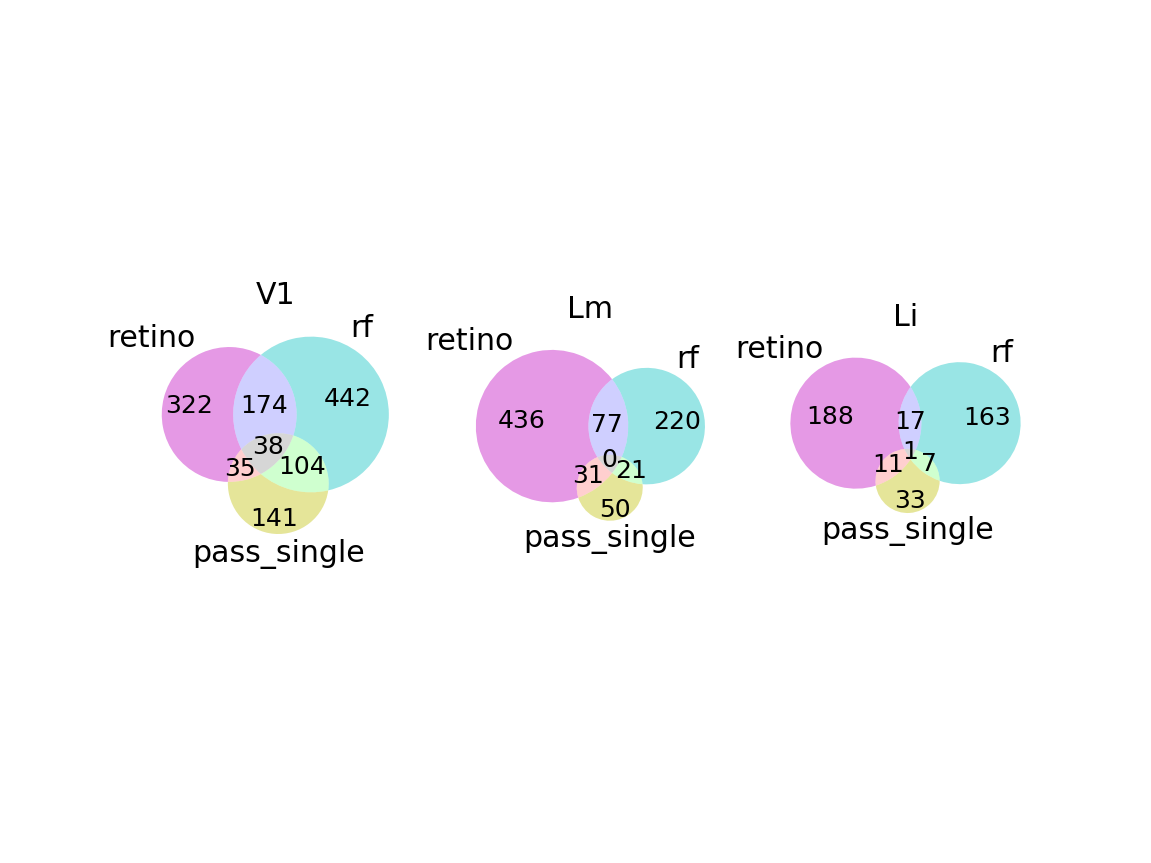

(156, 9)


In [159]:
fig, axn = pl.subplots(1,3)
h_=[]
for varea, gc in gcells.groupby(['visual_area']):
    ax=axn[visual_areas.index(varea)]

    d1 = gc[gc['filter']=='retino']['global_ix']
    d2 = gc[gc['filter']=='rf']['global_ix']
    d3 = gc[gc['filter']=='pass_single']['global_ix']
    mpvenn.venn3([set(d1), set(d2), set(d3)], set_labels=('retino', 'rf', 'pass_single'), 
                 ax=ax, set_colors=('m', 'c', 'y'))
    ax.set_title(varea)
    common_rs = np.intersect1d(np.intersect1d(d1, d2), d3)
    common_= gc[gc['global_ix'].isin(common_rs)]
    h_.append(common_)
has_all = pd.concat(h_, axis=0).drop(labels=['filter'], axis=1).drop_duplicates().reset_index(drop=True)
print(has_all.shape)

## Look at responses to training configs

In [160]:
ndata_sg = aggr.get_neuraldata(pass_scores, MEANS, stack=True)
cells_sg = aggr.cells_in_experiment_df(pass_scores, ndata_sg)

In [161]:
cellcounts_ret = dict(cells_ret.groupby(['visual_area'])['cell'].count())
cellcounts_rf = dict(cells_rf.groupby(['visual_area'])['cell'].count())

cellcounts_sg = dict(cells_sg.groupby(['visual_area'])['cell'].count())
cellcounts_sg

{u'Li': 52, u'Lm': 102, u'V1': 318}

In [167]:
ndata_df['filter'] = responsive_test
ndata_rf['filter'] = 'rf'
ndata_ret['filter'] = 'retino'
ndata_sg['filter'] = 'single'
ndata = pd.concat([ndata_df, ndata_ret, ndata_rf, ndata_sg], axis=0).reset_index(drop=True)


In [162]:
class_a=0; class_b=106;
train_configs = sdf[sdf['morphlevel'].isin([class_a, class_b])].index.tolist()


In [308]:
train_only = True
cfgs = train_configs if train_only else sdf.index.tolist()

meandf = ndata[ndata['config'].isin(cfgs)].groupby(['filter', 'visual_area', 'datakey', 'cell', 'config'])\
                .mean().reset_index()

#meandf = pd.concat([mean_df, mean_ret, mean_rf, mean_sg], axis=0).reset_index(drop=True)
meandf.shape

meandf['abs_response'] = np.abs(meandf['response'])

means_by_cell = meandf[meandf['visual_area'].isin(visual_areas)]\
                    .groupby(['filter', 'visual_area', 'datakey', 'cell']).mean().reset_index()
means_by_cell.groupby(['visual_area', 'filter']).mean()

(81880, 7)

In [311]:
means_by_fov = means_by_cell.groupby(['filter', 'visual_area', 'datakey']).mean().reset_index()

<IPython.core.display.Javascript object>


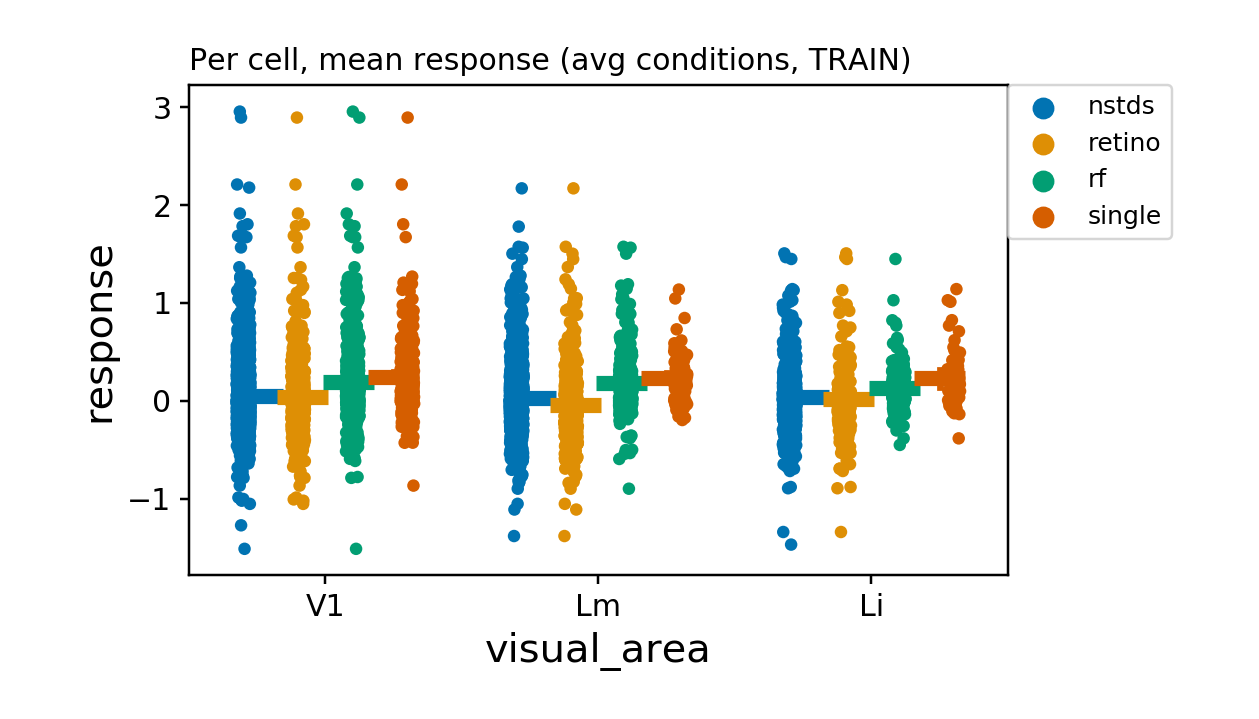

                          cell       trial  response  abs_response
visual_area filter                                                
Li          nstds   164.092610  755.296206  0.044403      0.247126
            retino  168.230415  723.915720  0.017017      0.351320
            rf      153.473404  776.081452  0.129530      0.247515
            single  126.576923  784.554806  0.231078      0.364582
Lm          nstds   134.456212  733.991108  0.027283      0.248442
            retino  130.544118  734.931242 -0.038312      0.318046
            rf      125.295597  739.124157  0.178559      0.316392
            single  141.303922  738.017060  0.236619      0.370382
V1          nstds   150.719004  764.432848  0.052379      0.304605
            retino  143.650264  758.239312  0.035288      0.368304
            rf      151.064644  763.240094  0.191915      0.361198
            single  160.386792  762.923156  0.243675      0.433454


In [312]:
n_hues = len(means_by_cell['filter'].unique())
cfg_str = 'TRAIN' if train_only else 'ALL'
response_name='response'

fig, ax = pl.subplots(figsize=(7,4))
print(means_by_cell.groupby(['visual_area', 'filter']).mean())
sns.stripplot(x='visual_area', y=response_name, data=means_by_cell, ax=ax, 
              hue='filter', dodge=True, order=visual_areas)
sns.pointplot(x='visual_area', y=response_name, data=means_by_cell, ax=ax, 
              hue='filter', dodge=0.5, join=False, scale=3, markers='_', order=visual_areas)
ax.set_title('Per cell, mean response (avg conditions, %s)'% cfg_str, loc='left')

# Get the handles and labels.
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
l = pl.legend(handles[0:n_hues], labels[0:n_hues], bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.)
pl.subplots_adjust(right=0.8, left=0.15, bottom=0.2)  

## Plot means by FOV to jmake it easier to see what's going on (i.e., average across cells)

<IPython.core.display.Javascript object>


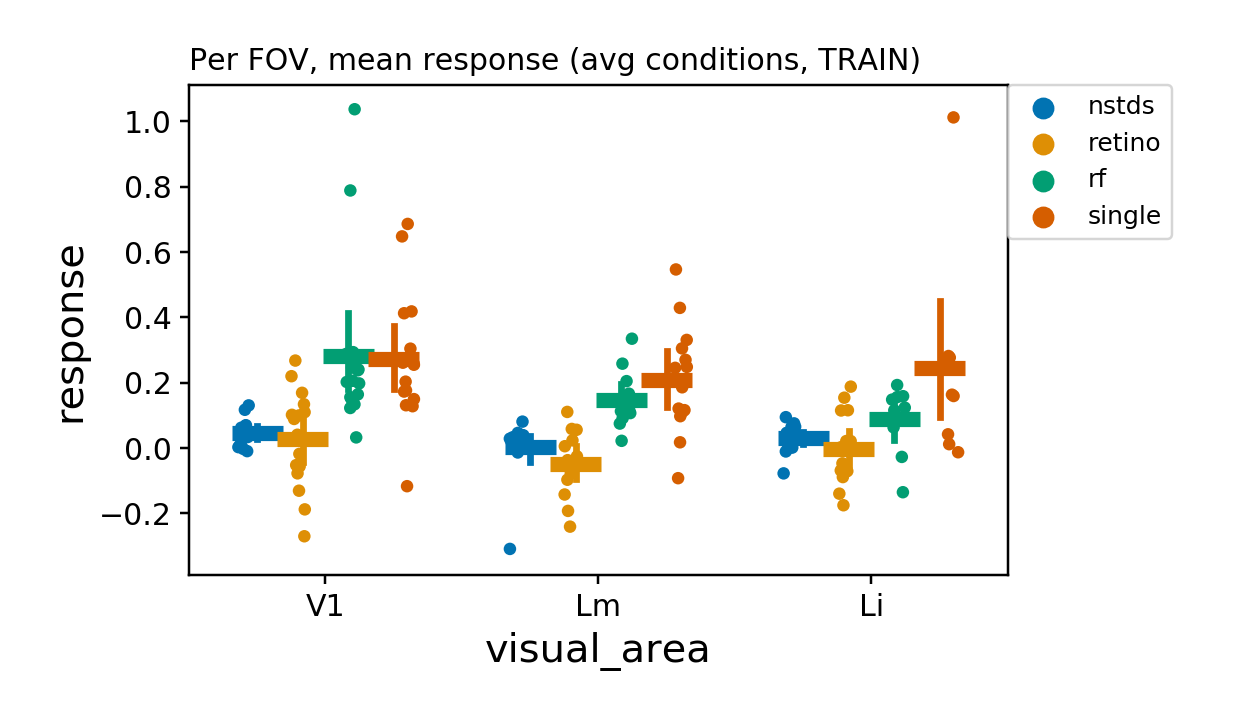

                          cell       trial  response  abs_response
visual_area filter                                                
Li          nstds   158.066179  744.926712  0.031961      0.223398
            retino  159.678254  699.520188 -0.003449      0.332584
            rf      142.864419  803.177414  0.088479      0.232006
            single  158.753640  815.311546  0.244655      0.354029
Lm          nstds   131.326038  729.659882  0.004424      0.256087
            retino  125.189071  728.214636 -0.047588      0.328814
            rf      141.025915  736.963742  0.147885      0.273162
            single  139.765136  733.550469  0.209371      0.329460
V1          nstds   150.678351  756.098385  0.046332      0.305732
            retino  134.866370  756.098385  0.027494      0.399419
            rf      151.415202  756.098385  0.280910      0.431737
            single  160.833473  764.812411  0.272686      0.476763


In [313]:
response_name='response'

n_hues = len(means_by_fov['filter'].unique())
cfg_str = 'TRAIN' if train_only else 'ALL'
fig, ax = pl.subplots(figsize=(7,4))
print(means_by_fov.groupby(['visual_area', 'filter']).mean())
sns.stripplot(x='visual_area', y=response_name, data=means_by_fov, ax=ax, 
              hue='filter', dodge=True, order=visual_areas)
sns.pointplot(x='visual_area', y=response_name, data=means_by_fov, ax=ax, 
              hue='filter', dodge=0.5, join=False, scale=3, markers='_', order=visual_areas)
ax.set_title('Per FOV, mean response (avg conditions, %s)'% cfg_str, loc='left')

# Get the handles and labels.
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
l = pl.legend(handles[0:n_hues], labels[0:n_hues], bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.)
pl.subplots_adjust(right=0.8, left=0.15, bottom=0.2)  

#### 2. SNR

In [186]:
# trial_epoch='plushalf'
mean_snr = aggr.get_mean_snr(experiment=experiment, traceid=traceid, responsive_test=responsive_test,
                                        responsive_thr=responsive_thr, trial_epoch=trial_epoch)
mean_snr[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

... loading SNR (aggr_by_cell_blobs_traces001_nstds-thr-10.00_snr_plushalf)
(266905, 5)


datakey  cell
visual_area               
Li              1069  1069
Ll               293   293
Lm              1964  1964
V1              2089  2089

In [187]:
snr_by_cell = mean_snr.groupby(['visual_area', 'datakey', 'cell']).mean().reset_index()
df0 = pd.concat([snr_by_cell[(snr_by_cell['visual_area']==v) 
                           & (snr_by_cell['datakey']==dk) & (snr_by_cell['cell'].isin(g['cell'].unique()))] \
                    for (v, dk), g in cells_ret.groupby(['visual_area', 'datakey'])])
df0['filter'] = 'retino'

df1 = pd.concat([snr_by_cell[(snr_by_cell['visual_area']==v) 
                           & (snr_by_cell['datakey']==dk) & (snr_by_cell['cell'].isin(g['cell'].unique()))] \
                    for (v, dk), g in cells_rf.groupby(['visual_area', 'datakey'])])
df1['filter'] = 'rf'

df2 = pd.concat([snr_by_cell[(snr_by_cell['visual_area']==v) 
                           & (snr_by_cell['datakey']==dk) & (snr_by_cell['cell'].isin(g['cell'].unique()))] \
                    for (v, dk), g in cells_sg.groupby(['visual_area', 'datakey'])])
df2['filter'] = 'pass_single'

df3 = pd.concat([snr_by_cell[(snr_by_cell['visual_area']==v) 
                           & (snr_by_cell['datakey']==dk) & (snr_by_cell['cell'].isin(g['cell'].unique()))] \
                    for (v, dk), g in cells_df.groupby(['visual_area', 'datakey'])])
df3['filter'] = responsive_test

snr_df = pd.concat([df0, df1, df2, df3], axis=0).reset_index(drop=True)


In [188]:
snr_df.head()

visual_area              datakey  cell        snr  filter
0          Li  20190315_JC070_fov1   104  14.568626  retino
1          Li  20190315_JC070_fov1   110  11.172725  retino
2          Li  20190315_JC070_fov1   113  12.924591  retino
3          Li  20190315_JC070_fov1   119  15.943619  retino
4          Li  20190315_JC070_fov1   128  16.029106  retino

<IPython.core.display.Javascript object>


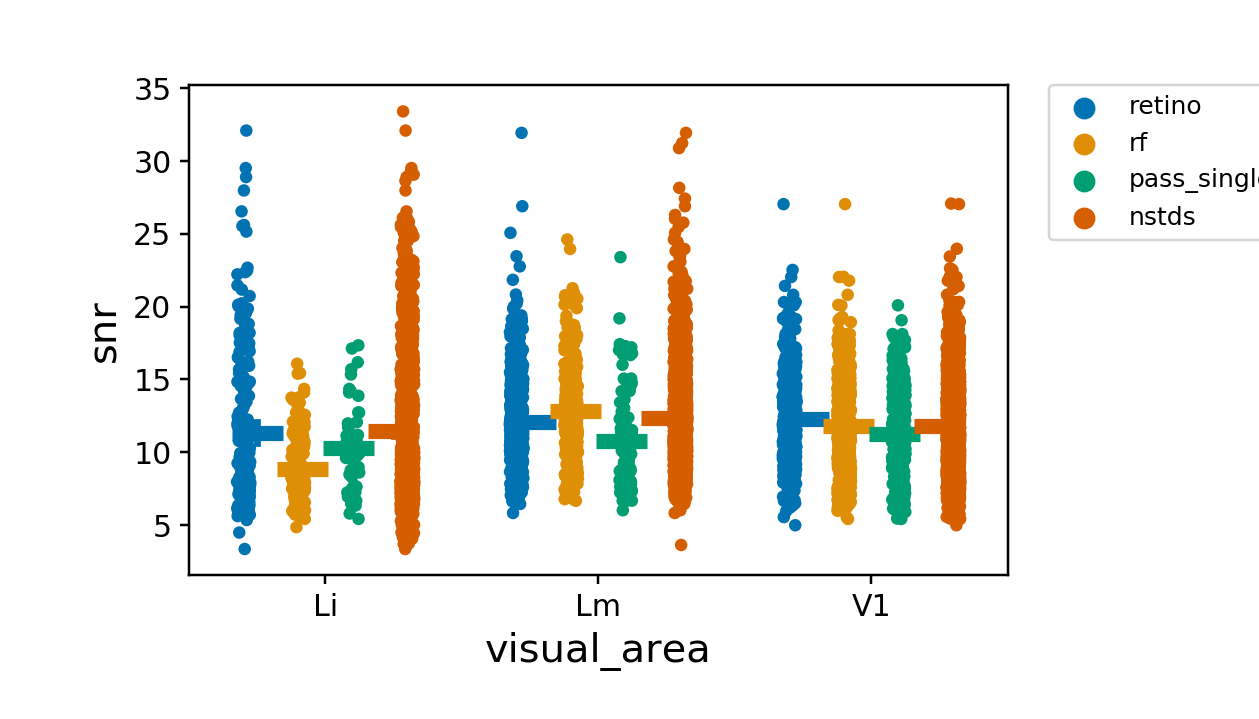

In [189]:

fig, ax = pl.subplots(figsize=(7,4))

sns.stripplot(x='visual_area', y='snr', data=snr_df, ax=ax, 
              hue='filter', dodge=True)
sns.pointplot(x='visual_area', y='snr', data=snr_df, ax=ax, 
              hue='filter', dodge=.5, join=False, scale=3, markers='_')

# Get the handles and labels.
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
l = pl.legend(handles[0:n_hues], labels[0:n_hues], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pl.subplots_adjust(left=0.15, bottom=0.2, right=0.8)


#### 3. ID dff thresholds

<IPython.core.display.Javascript object>


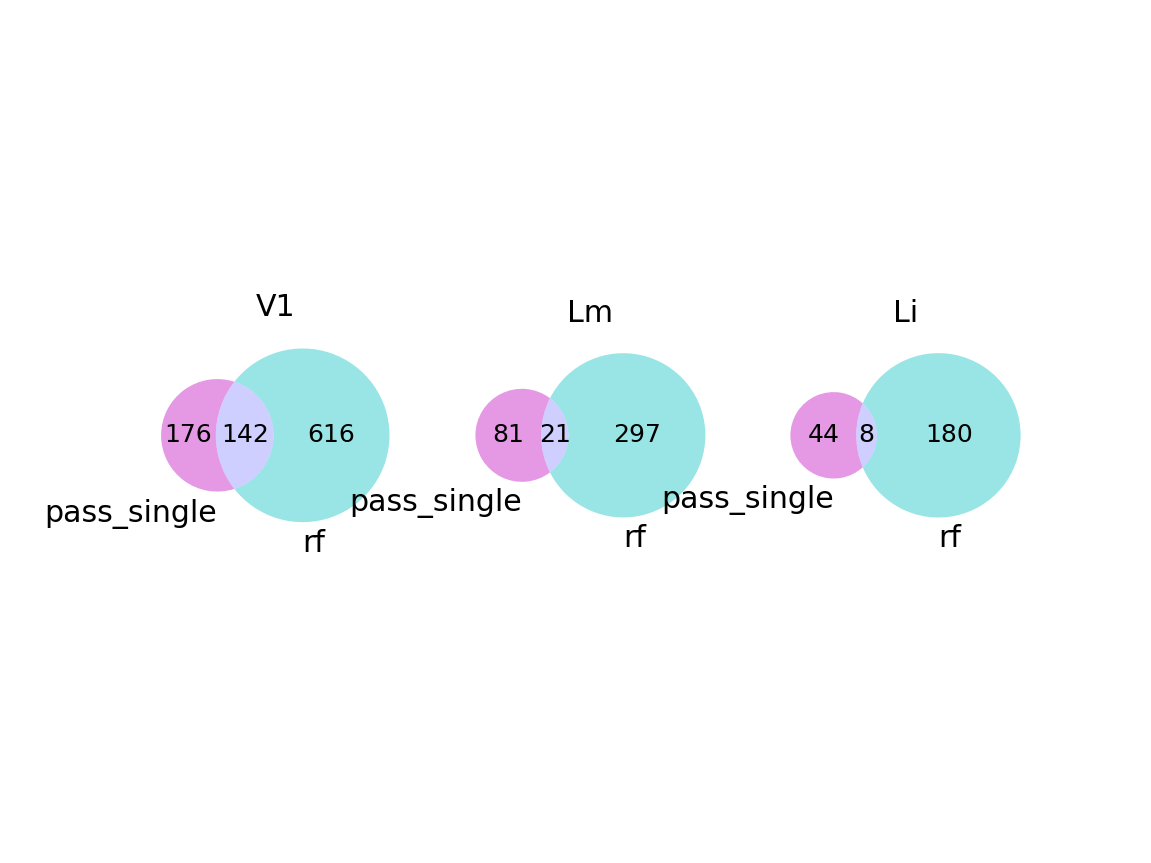

(552, 9)


In [191]:
f1 = 'pass_single'
f2 = 'rf'
fig, axn = pl.subplots(1,3)
h_=[]
for varea, gc in gcells.groupby(['visual_area']):
    ax=axn[visual_areas.index(varea)]

    filter_colors
    d0 = gc[gc['filter']==f1]['global_ix']
    d1 = gc[gc['filter']==f2]['global_ix']
    
    filter_order = (f1, f2)
    filter_c = ('m', 'c')
    mpvenn.venn2([set(d0), set(d1)], set_labels=filter_order, ax=ax, set_colors=filter_c)
    ax.set_title(varea)
    
    h_.append(gc[gc['global_ix'].isin(np.intersect1d(d0, d1))])
has_both = pd.concat(h_, axis=0).drop(labels=['filter'], axis=1).drop_duplicates().reset_index(drop=True)
print(has_both.shape)

<IPython.core.display.Javascript object>


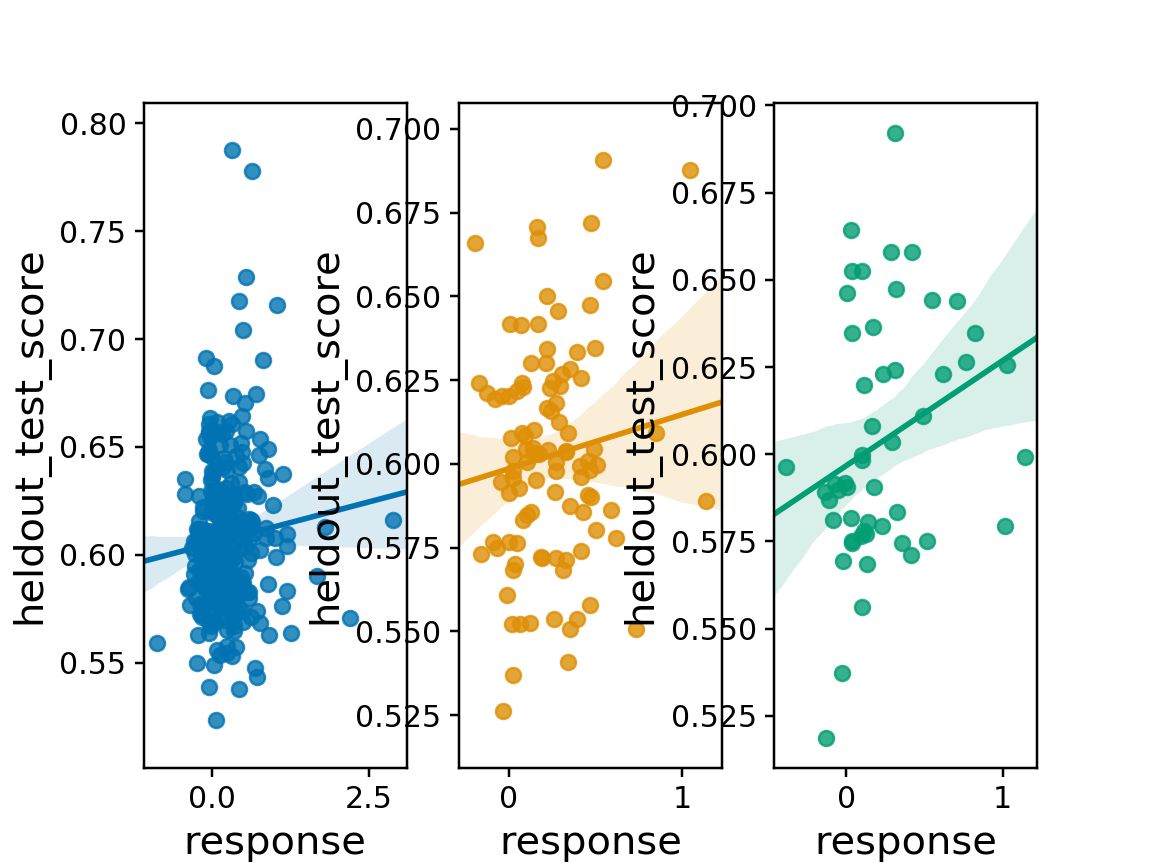

[V1, n=318] r=0.09 (p=0.12) | min-max=(-0.87, 2.89)
[Lm, n=102] r=0.12 (p=0.24) | min-max=(-0.20, 1.14)
[Li, n=52] r=0.28 (p=0.05) | min-max=(-0.38, 1.14)


In [330]:
filter_type = 'single'

fig, axn = pl.subplots(1, 3)

score_cols = ['cell', 'global_ix', 'datakey', 'visual_area', 'heldout_test_score']

for vi, visual_area in enumerate(visual_areas):
    ax=axn[vi]
    curr_scores = pass_scores[(pass_scores.visual_area==visual_area)][score_cols].copy()

    curr_resps = means_by_cell[(means_by_cell.visual_area==visual_area) & (means_by_cell['filter']==filter_type)
                             & (means_by_cell['datakey'].isin(curr_scores['datakey'].values))
                             & (means_by_cell['cell'].isin(curr_scores['cell'].values))].copy()

    assert curr_scores.shape[0]==curr_resps.shape[0]
    currdf = pd.merge(curr_scores, curr_resps)
    nc = len(currdf['global_ix'].unique())
    
    #ax.scatter(curr_resps['response'], curr_scores['heldout_test_score'])
    sns.regplot(currdf['response'], currdf['heldout_test_score'], ax=ax)
    pear_r, pear_p = spstats.pearsonr(currdf['response'], currdf['heldout_test_score'])
    minv, maxv = currdf['response'].min(), currdf['response'].max()
    print("[%s, n=%i] r=%.2f (p=%.2f) | min-max=(%.2f, %.2f)" % (visual_area, nc, pear_r, pear_p, minv, maxv))
    

In [ ]:
pear_r, pear_p = spstats.pearsonr()

<IPython.core.display.Javascript object>


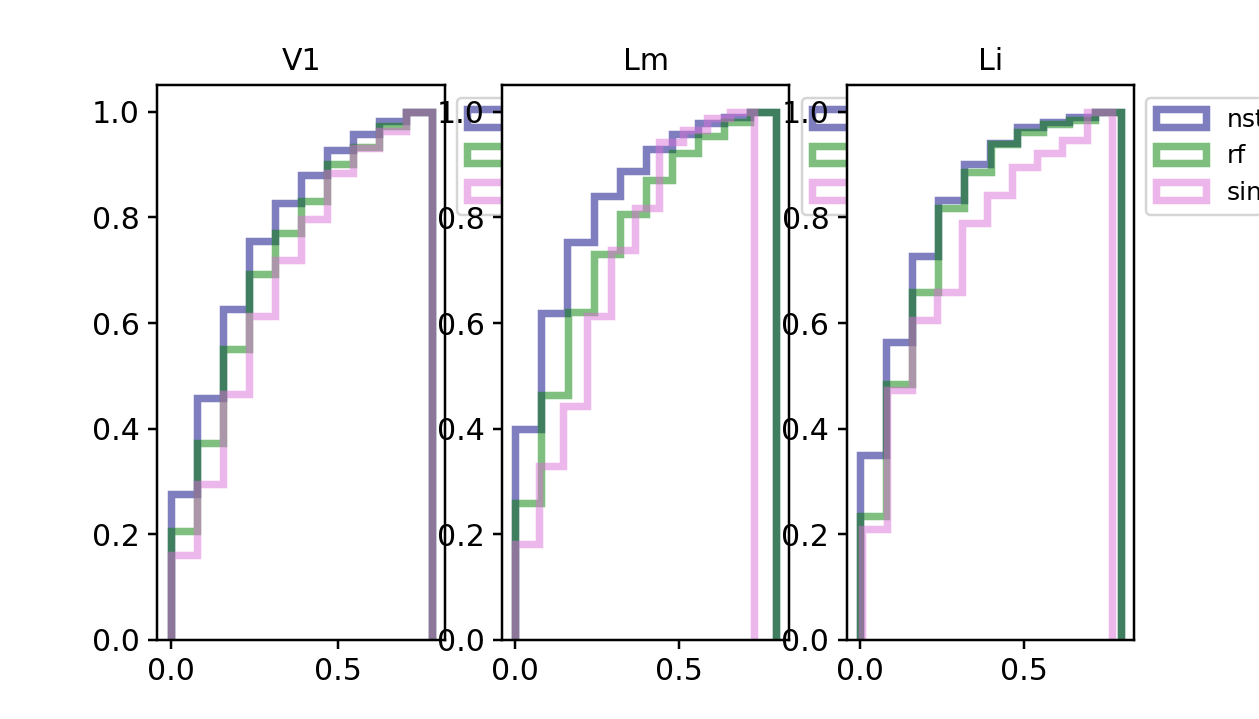

cell            32.533333
trial           32.533333
response        32.533333
abs_response    32.533333
dtype: float64
cell            27.924528
trial           27.924528
response        27.924528
abs_response    27.924528
dtype: float64
cell            17.87234
trial           17.87234
response        17.87234
abs_response    17.87234
dtype: float64


In [451]:
filter_colors.update({'single': 'orchid'})
response_name='response'
fig, axn = pl.subplots(1, 3, figsize=(7,4))

for vi, visual_area in enumerate(visual_areas):
    ax=axn[vi]
    df_ = means_by_cell[(means_by_cell['visual_area']==visual_area)
                      & (means_by_cell[response_name]<=0.8) & (means_by_cell[response_name]>=0.)].copy()

    print(df_.groupby(['filter', 'visual_area', 'datakey']).count().mean())

    #fig, ax = pl.subplots()
    for filter_type, d in df_.groupby(['filter']):
        if filter_type not in ['single', 'rf', 'nstds']:
            continue
        ax.hist(d[response_name], color=filter_colors[filter_type], cumulative=True, 
                normed=True, histtype='step', lw=3, label=filter_type, alpha=0.5)
    ax.legend(bbox_to_anchor=(1., 1))
    ax.set_title(visual_area)

In [431]:
reload(dc)

<module 'pipeline.python.classifications.decode_by_ncells' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_by_ncells.py'>

In [438]:
def filter_cells_by_dff(all_cells, MEANS, traceid='traces001', response_type='dff', 
                       minv=0., maxv=1.0, aggregate_dir='/n/coxfs01/julianarhee/aggregate-visual-areas'):
    
    ndata_df, cells_df = dc.get_cells_and_data(all_cells, MEANS, traceid=traceid, response_type=response_type, 
                                stack_neuraldf=True, overlap_thr=None, has_retino=False, threshold_snr=False) 
                                
    meandf = ndata_df.groupby(['visual_area', 'datakey', 'cell', 'config']).mean().reset_index()
    means_c = meandf.groupby(['visual_area', 'datakey', 'cell']).mean().reset_index()

    thr_resp = means_c[(means_c['response']<=maxv) & (means_c['response']>=minv)].reset_index(drop=True)

    thr_cells = pd.concat([cells_df[(cells_df['visual_area']==v) & (cells_df['datakey']==d)
                  & (cells_df['cell'].isin(g['cell'].unique()))] \
                for (v, d), g in thr_resp.groupby(['visual_area', 'datakey'])]).reset_index(drop=True)

    cells_fn = os.path.join(aggregate_dir, 'decoding', 'thr_dff_cells_m%.2f_M%.2f.pkl' % (minv, maxv))
    with open(cells_fn, 'wb') as f:
        pkl.dump(thr_cells, f, protocol=pkl.HIGHEST_PROTOCOL)
    print(cells_fn)
    
    return thr_cells

In [452]:
thresh_cells = filter_cells_by_dff(all_cells, MEANS, traceid=traceid, response_type=response_type, 
                       minv=0., maxv=0.8)
thresh_cells[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()


Segmentation: missing 9 dsets
Segmentation: missing 9 dsets
~~~~~~~~~~~~~~~~No Receptive Fields~~~~~~~~~~~~~~~~~~~~~~~~~
Assigned visual areas: [u'Li' u'Lm' u'V1']
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 2089, u'Lm': 1964, u'Li': 1069}
------------------------------------
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/thr_dff_cells_m0.00_M0.80.pkl


datakey  cell
visual_area               
Li               510   510
Lm               859   859
V1               858   858

In [454]:
cells_df[cells_df['datakey']=='20190315_JC070_fov1'].shape

(96, 9)

In [455]:
thresh_cells[thresh_cells['datakey']=='20190315_JC070_fov1'].shape

(58, 9)

In [430]:
thresh_cells = means_by_cell[(means_by_cell['filter']=='nstds') 
                & (means_by_cell[response_name]<=0.5) & (means_by_cell[response_name]>=0.)].copy().reset_index(drop=True)
thresh_cells[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area','datakey']).count()

cell
visual_area datakey                  
Li          20190315_JC070_fov1    62
            20190316_JC070_fov1    48
            20190319_JC067_fov1    12
            20190320_JC067_fov1     8
            20190321_JC070_fov1     7
            20190322_JC073_fov1    62
            20190422_JC076_fov1    13
            20190602_JC091_fov1    58
            20190606_JC091_fov1    31
            20190607_JC091_fov1    69
            20190609_JC099_fov1    41
            20190612_JC099_fov1    35
            20190614_JC091_fov1    59
            20190617_JC099_fov1    11
            20191018_JC113_fov1    25
            20191111_JC120_fov1     5
Lm          20190306_JC061_fov3    38
            20190322_JC073_fov1    22
            20190430_JC078_fov1    80
            20190504_JC078_fov1    57
            20190506_JC080_fov1   110
            20190508_JC083_fov1    76
            20190509_JC078_fov1    43
            20190512_JC083_fov1    62
            20190513_JC078_fov1    75
            20190517_JC083_fov1    60
            20190525_JC084_fov1    88
            20190603_JC080_fov1    68
            20190618_JC097_fov1    39
            20190627_JC091_fov1    92
V1          20190420_JC076_fov1    25
            20190501_JC076_fov1    87
            20190504_JC078_fov1    15
            20190507_JC083_fov1    37
            20190508_JC083_fov1    11
            20190509_JC078_fov1    15
            20190510_JC083_fov1    43
            20190511_JC083_fov1    35
            20190512_JC083_fov1    23
            20190517_JC083_fov1    10
            20190522_JC084_fov1    73
            20190613_JC097_fov1    69
            20190616_JC097_fov1   124
            20190617_JC097_fov1   140
            20190622_JC085_fov1    90
            20191006_JC110_fov1   117

In [379]:
cells_fn = os.path.join(aggregate_dir, 'decoding', 'thr_dff_cells.pkl')
with open(cells_fn, 'wb') as f:
    pkl.dump(thresh_cells, f, protocol=pkl.HIGHEST_PROTOCOL)
    
print(cells_fn)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/thr_dff_cells.pkl


<IPython.core.display.Javascript object>


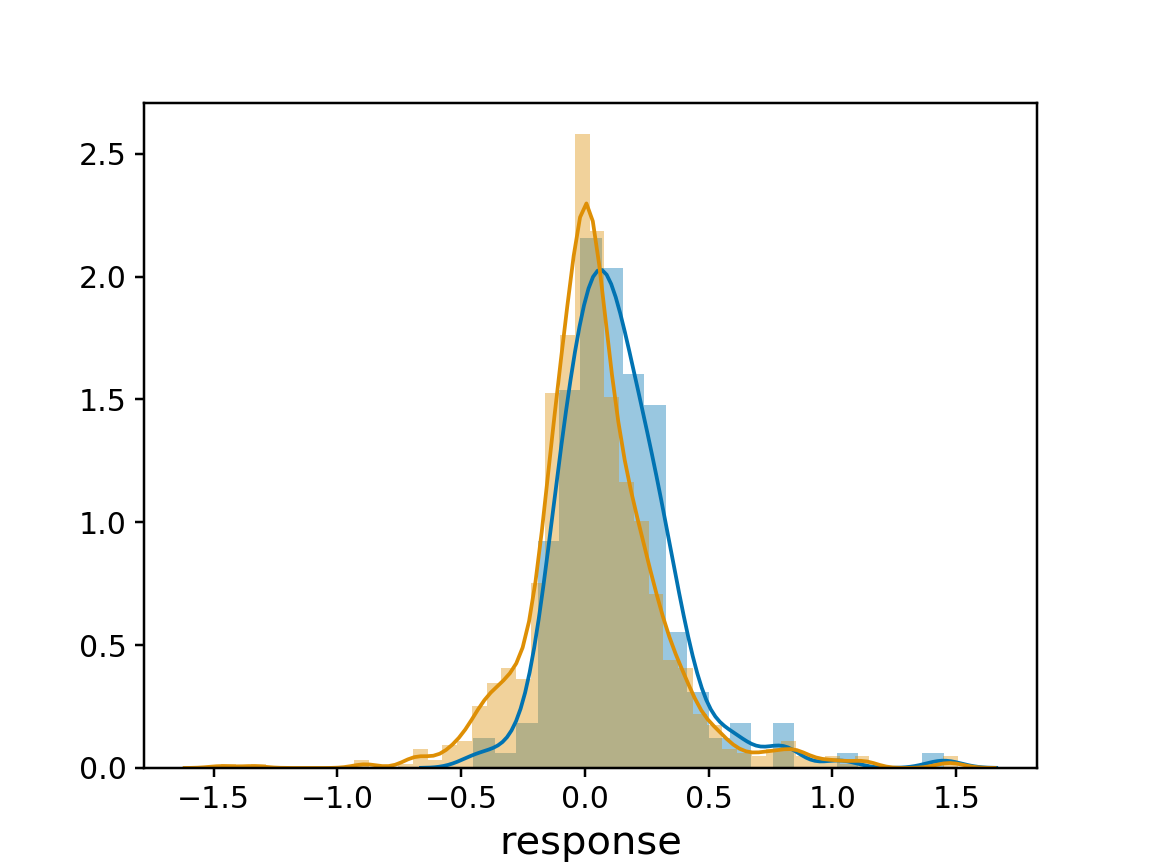

In [316]:
fig, ax = pl.subplots()
sns.distplot(df_[df_['filter']=='rf']['response'], ax=ax)
sns.distplot(df_[df_['filter']=='nstds']['response'], ax=ax)

In [240]:
df_.groupby(['filter', 'visual_area']).count()

datakey  cell  trial  response  abs_response
filter visual_area                                              
nstds  Li               787   787    787       787           787
retino Li               127   127    127       127           127
rf     Li               157   157    157       157           157
single Li                46    46     46        46            46

<IPython.core.display.Javascript object>


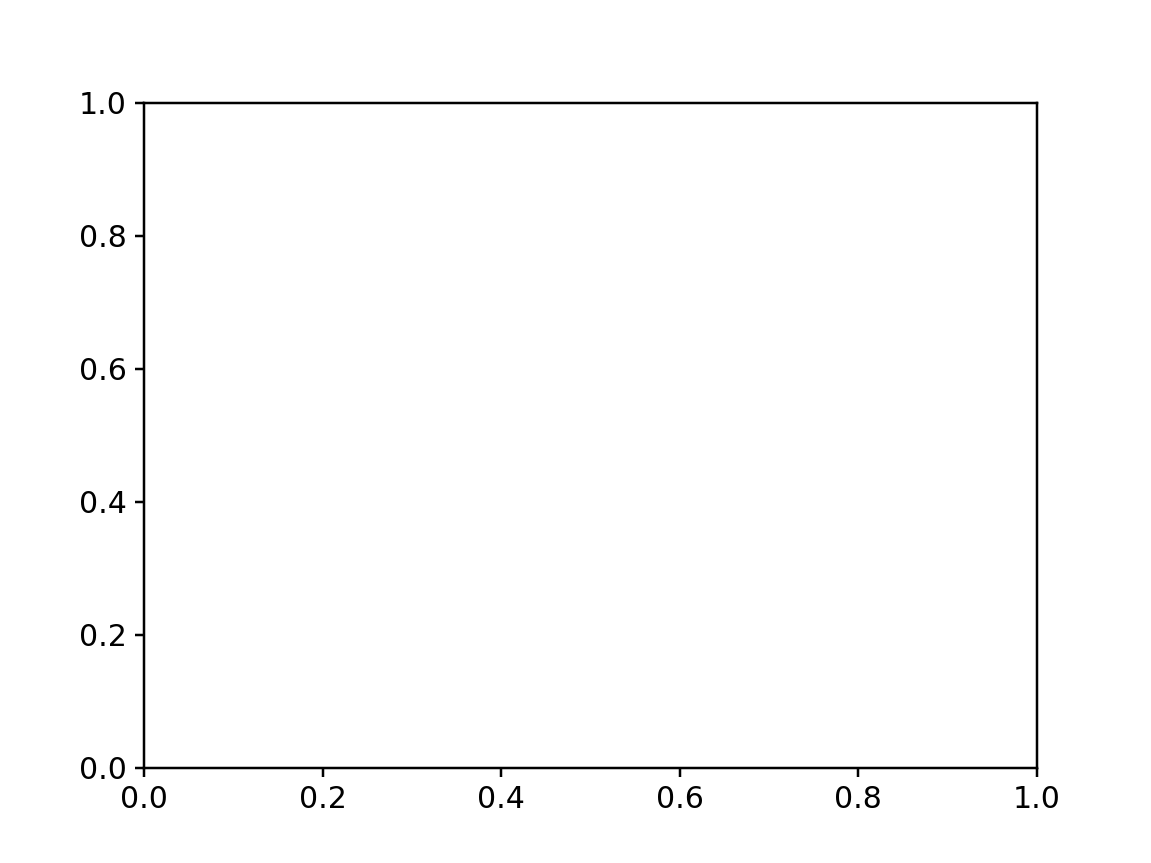

-0.8710421031479836

In [234]:
fig, ax = pl.subplots()
means_by_cell[means_by_cell['filter']=='single']['response'].min()


In [239]:
## Other metrics?

In [ ]:
# #datakey = '20190315_JC070_fov1'
# print(trial_epoch)
# d_=[]
# for (visual_area, datakey), g in mean_snr.groupby(['visual_area', 'datakey']):
#     # print("... %s: loading all metrics" % visual_area)
#     session, animalid, fovnum = putils.split_datakey_str(datakey)
#     metrics = aggr.load_trial_metrics(animalid, session, fovnum, experiment, traceid=traceid,
#                             responsive_test=responsive_test, responsive_thr=responsive_thr, epoch=trial_epoch)
#     tmpd = metrics[metrics['cell'].isin(g['cell'].unique())][['dff', 'stim_mean', 'stim_mean_df', 'base_std', 'cell', 'config', 'trial']]
#     tmpd['visual_area']=visual_area
#     tmpd['datakey']=datakey
#     d_.append(tmpd)
# METRICS = pd.concat(d_, axis=0).reset_index(drop=True)
# METRICS.head()

# Sparsity?

In [241]:
v='V1'
dk = '20190617_JC097_fov1'
rid = 0

for rid, g in meandf[(meandf['visual_area']==v) & (meandf['datakey']==dk)].groupby(['cell']):
    g

In [243]:
g[]

(10, 7)

# Get aggregate data

In [210]:
filter_by='most_fits'
blob_dsets = aggr.get_blob_datasets(filter_by=filter_by, as_dict=False)

Segmentation: missing 9 dsets
Segmentation: missing 3 dsets
[AL] Animalid does not exist: JC099 
[Ll] Animalid does not exist: JC067 
[Ll] Animalid does not exist: JC099 
[V1] Animalid does not exist: JC078 


In [211]:
all_dkeys = sdata[(sdata['experiment']==experiment)]['datakey'].unique()
unique_dkeys = blob_dsets['datakey'].unique()

n_drop = len(all_dkeys) - len(unique_dkeys)
print("Dropping %i dkeys (%i of %i dkeys unique)" % (n_drop, len(unique_dkeys), len(all_dkeys)))


Dropping 11 dkeys (31 of 42 dkeys unique)


In [212]:
reload(dc)

<module 'pipeline.python.classifications.decode_by_ncells' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_by_ncells.pyc'>

In [419]:
C_value=None
trial_epoch='plushalf'
analysis_type='by_fov'

overlap_thr=0
has_retino=False
# -------------------------------------------------------------------------------------

C_str = 'tuneC' if C_value is None else 'C%.2f' % float(C_value)
if has_retino:
    overlap_str = 'retino'
else:
    overlap_str = 'noRF' if overlap_thr is None else 'overlap%.1f' % float(overlap_thr)
data_id = '%s__%s-%s_%s_%s_%s' \
                % (analysis_type, response_type, responsive_test, overlap_str,
                                trial_epoch, C_str)
print(data_id)

df = dc.do_decode_within_fov(analysis_type=analysis_type, experiment=experiment, 
                    responsive_test=responsive_test, responsive_thr=responsive_thr,
                    response_type=response_type, traceid=traceid, trial_epoch=trial_epoch,
                    C_value=C_value, overlap_thr=overlap_thr, has_retino=has_retino, verbose=True)

df['animalid'] = [d.split('_')[1] for d in df['datakey']]
df['session'] = [d.split('_')[0] for d in df['datakey']]
df['fovnum'] = [int(d.split('_')[2][3:]) for d in df['datakey']]


by_fov__dff-nstds_overlap0.0_plushalf_tuneC
AGGREGATE: by_fov___dff-nstds_overlap0.0__plushalf__tuneC
Segmentation: missing 9 dsets
Segmentation: missing 9 dsets
JC091|20190602|FOV1_zoom2p0x -- by_fov_Li__dff-nstds_overlap0.0__plushalf__tuneC
JC091|20190606|FOV1_zoom2p0x -- by_fov_Li__dff-nstds_overlap0.0__plushalf__tuneC
JC091|20190607|FOV1_zoom2p0x -- by_fov_Li__dff-nstds_overlap0.0__plushalf__tuneC
JC099|20190609|FOV1_zoom2p0x -- by_fov_Li__dff-nstds_overlap0.0__plushalf__tuneC
JC099|20190612|FOV1_zoom2p0x -- by_fov_Li__dff-nstds_overlap0.0__plushalf__tuneC
JC091|20190614|FOV1_zoom2p0x -- by_fov_Li__dff-nstds_overlap0.0__plushalf__tuneC
JC099|20190617|FOV1_zoom2p0x -- by_fov_Li__dff-nstds_overlap0.0__plushalf__tuneC
JC113|20191018|FOV1_zoom2p0x -- by_fov_Li__dff-nstds_overlap0.0__plushalf__tuneC
JC120|20191111|FOV1_zoom2p0x -- by_fov_Li__dff-nstds_overlap0.0__plushalf__tuneC
JC099|20190612|FOV1_zoom2p0x -- by_fov_Ll__dff-nstds_overlap0.0__plushalf__tuneC
JC078|20190430|FOV1_zoom2p0x

In [420]:
dropdf = df[df['datakey'].isin(unique_dkeys)].copy()

In [421]:
df.shape, dropdf.shape

((6200, 18), (4600, 18))

In [422]:
df.groupby(['visual_area', 'condition']).mean()

C  fit_time  heldout_MI  heldout_aMI  \
visual_area condition                                                 
Li          data       17.868790  0.105205    0.054828     0.068469   
            shuffled   32.853546  0.438101    0.008349     0.000450   
Lm          data       16.371885  0.166225    0.043053     0.049976   
            shuffled   31.737929  0.457101    0.008739    -0.000333   
V1          data       10.953148  0.046824    0.113258     0.153031   
            shuffled   28.507254  0.795552    0.008271    -0.000372   

                       heldout_log2MI  heldout_test_score  score_time  \
visual_area condition                                                   
Li          data             0.079101            0.633587    0.000670   
            shuffled         0.012045            0.502461    0.000816   
Lm          data             0.062113            0.617536    0.000596   
            shuffled         0.012608            0.495404    0.000677   
V1          data             0.163397            0.697965    0.000823   
            shuffled         0.011933            0.499814    0.000964   

                       test_score  train_score    n_cells    n_trials  \
visual_area condition                                                   
Li          data         0.634041     0.709515  26.428571  340.000000   
            shuffled     0.510796     0.618824  26.428571  340.000000   
Lm          data         0.616604     0.711315  28.636364  292.727273   
            shuffled     0.505423     0.631553  28.636364  292.727273   
V1          data         0.696744     0.789706  57.615385  305.384615   
            shuffled     0.509244     0.686531  57.615385  305.384615   

                       iteration  fovnum  
visual_area condition                     
Li          data            49.5     1.0  
            shuffled        49.5     1.0  
Lm          data            49.5     1.0  
            shuffled        49.5     1.0  
V1          data            49.5     1.0  
            shuffled        49.5     1.0

In [423]:
df[['visual_area', 'datakey', 'n_cells']].drop_duplicates().groupby(['visual_area']).sum()

n_cells
visual_area         
Li               185
Lm               315
V1               749

In [424]:
subdir = data_id.split('__')[-1]

dst_dir = os.path.join(aggregate_dir, 'decoding', analysis_type, subdir)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/dff-nstds_overlap0.0_plushalf_tuneC


In [425]:
if 'pupil' in analysis_type:
    diffs=[]
    scores=[]
    for (visual_area, datakey), g in df.groupby(['visual_area', 'datakey']):
        n_low = int(g[g['arousal']=='low']['n_trials'].values)
        n_high = int(g[g['arousal']=='high']['n_trials'].values)
        if n_low!=n_high:
            print('[%s] %s, low=%i, high=%i' % (visual_area, datakey, n_low, n_high))
            diffs.append(n_high - n_low)
            score_high = float(g[g['arousal']=='high'][metric].values)
            score_low = float(g[g['arousal']=='low'][metric].values)
            scores.append(score_high-score_low)     
            
    diffs=np.array(diffs)
    scores=np.array(scores)
    diff_ixs = np.argsort(diffs)

    f, ax = pl.subplots(figsize=(4,4))
    ax.scatter(diffs, scores)
    ax.set_xlim([-16, 16])
    f.text(0, 0.9, "Difference in trial # vs. score difference (low v high)")
    pear_r, pear_p = spstats.pearsonr(diffs, scores)
    ax.set_title('pearson r=%.2f (p=%.2f)' %(pear_r, pear_p), loc='left', fontsize=12)
    pl.subplots_adjust(top=0.7, bottom=0.2, left=0.2)

    ax.set_xlabel('n trials diff')
    ax.set_ylabel('score diff')
    
    figname = 'ntrials_v_score_diffs__%s' % C_str
    putils.label_figure(f, data_id)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    

## N cells v accuracy

<IPython.core.display.Javascript object>


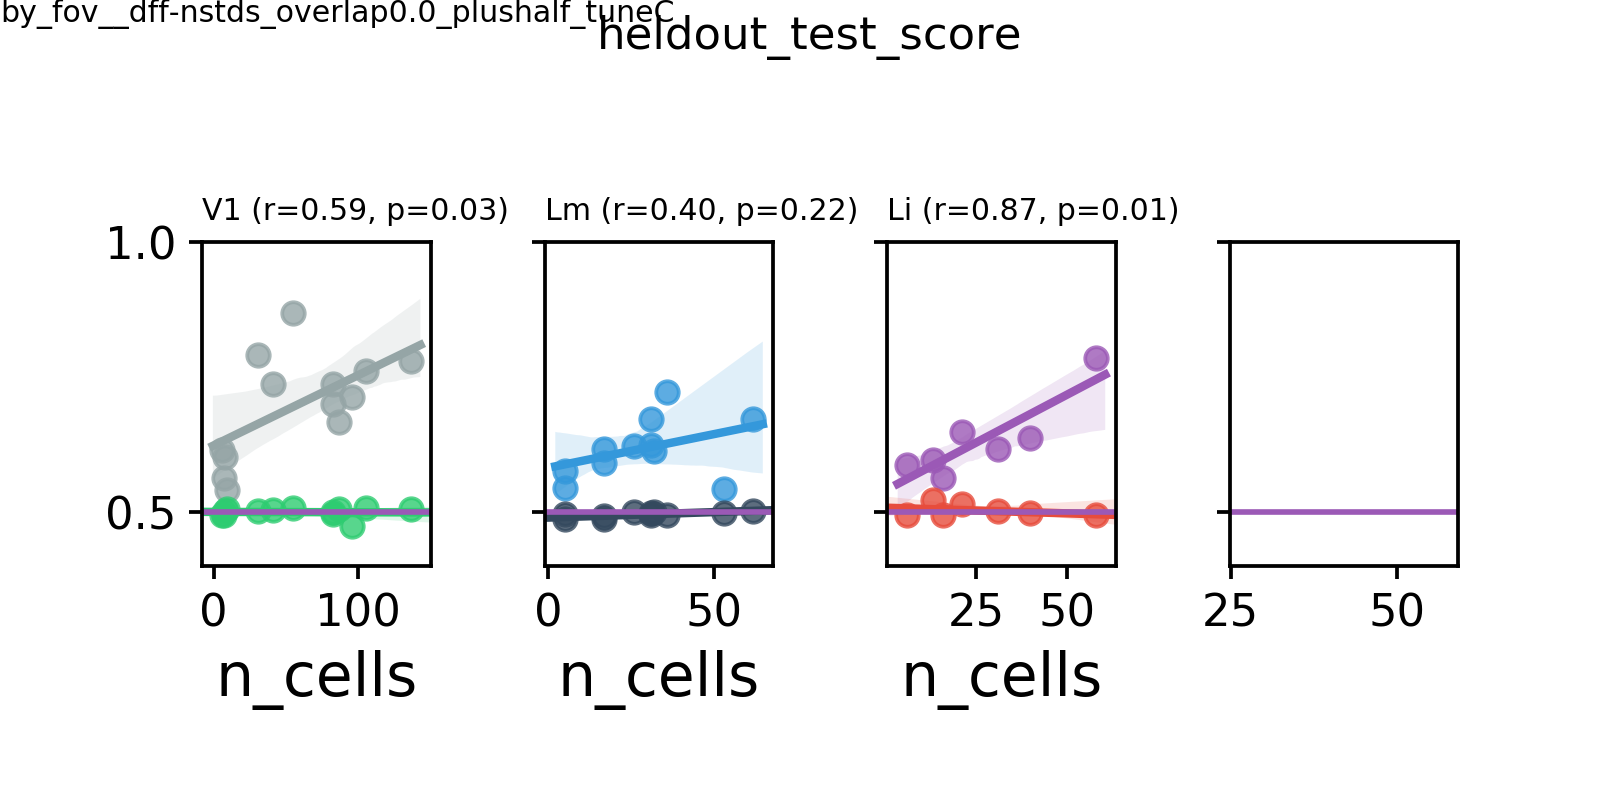

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/dff-nstds_overlap0.0_plushalf_tuneC', 'corr_ncells_heldout_test_score_by_fov__dff-nstds_overlap0.0_plushalf_tuneC__all_datasets')


In [426]:
visual_areas = ['V1', 'Lm', 'Li', 'Ll']
metric='heldout_test_score'

if 'pupil' in analysis_type:
    xdf = df[df['arousal']=='all'].copy()
else:
    xdf = df.copy() #[df['condition']=='data'].copy()
    
f, axn = pl.subplots(1, len(visual_areas), dpi=dpi, figsize=(6,3), sharex=False, sharey=True)
f.patch.set_alpha(1)

mean_scores = xdf.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()
for ai, (visual_area, vdf) in enumerate(mean_scores[mean_scores['condition']=='data'].groupby(['visual_area'])):
    ax=axn[2-ai]
    sns.regplot(x='n_cells', y=metric, data=vdf, ax=ax)
    pear_r, pear_p = spstats.pearsonr(vdf['n_cells'].values, vdf[metric].values)
    ax.set_title('%s (r=%.2f, p=%.2f)' % (visual_area, pear_r, pear_p), loc='left', fontsize=8)
    ax.set_ylabel('')


mean_scores = xdf.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()
for ai, (visual_area, vdf) in enumerate(mean_scores[mean_scores['condition']=='shuffled'].groupby(['visual_area'])):
    ax=axn[2-ai]
    sns.regplot(x='n_cells', y=metric, data=vdf, ax=ax)
    pear_r, pear_p = spstats.pearsonr(vdf['n_cells'].values, vdf[metric].values)
    #ax.set_title('%s (r=%.2f, p=%.2f)' % (visual_area, pear_r, pear_p), loc='left', fontsize=8)
    ax.set_ylabel('')

for ax in axn.flat:
    ax.set_yticks([0, 0.5, 1.0])
    ax.set_ylim([0.4, 1])
    ax.axhline(y=0.5)
    
f.suptitle(metric)
putils.label_figure(f, data_id)
pl.subplots_adjust(wspace=0.5, top=0.7, bottom=0.3)

figname = 'corr_ncells_%s_%s__%s' % (metric, data_id, dset_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

### Bin dsets by N_CELLS

In [427]:
n_bins=3
print(pd.cut(df['n_cells'], n_bins, labels=np.arange(0, n_bins)).value_counts())
print(pd.cut(df['n_cells'], n_bins).value_counts())


# tmp_keys = ['20190507_JC083_fov1', '20190511_JC083_fov1']

df['ncells_bin'] = pd.qcut(df['n_cells'], n_bins) #, labels=np.arange(0, n_bins))

print(pd.qcut(df['n_cells'], n_bins).value_counts())


0    4200
1    1400
2     600
Name: n_cells, dtype: int64
(4.868, 49.0]    4200
(49.0, 93.0]     1400
(93.0, 137.0]     600
Name: n_cells, dtype: int64
(4.999, 17.0]    2200
(41.0, 137.0]    2000
(17.0, 41.0]     2000
Name: n_cells, dtype: int64


In [428]:
# df.groupby(['condition', 'visual_area', 'ncells_bin']).mean()

<IPython.core.display.Javascript object>


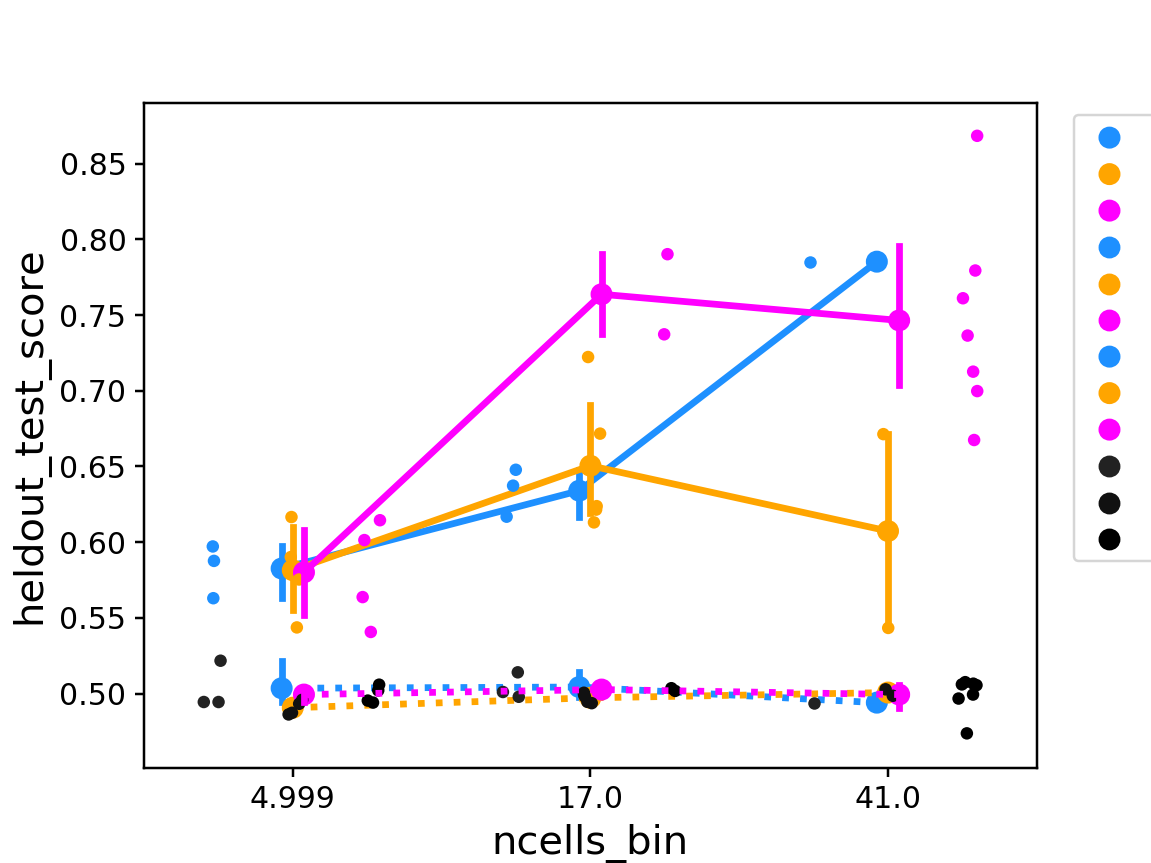

In [467]:
# df.groupby(['condition', 'visual_area', 'ncells_bin']).mean()
line_styles = {'data': '-', 'shuffled': ':'}
fig, ax = pl.subplots()
for cond, cond_df in df.groupby(['condition']):
    
    mean_ = cond_df.groupby(['visual_area', 'datakey', 'ncells_bin']).mean().reset_index()
    
    #for visual_area, vdf in cond_df.groupby(['visual_area']):

    #mean_ = vdf.groupby(['ncells_bin']).mean().reset_index()

    #tmpd = vdf.groupby(['datakey', 'ncells_bin']).mean().reset_index()
    #bin_names = mean_['ncells_bin'].values
    bin_names = [i.left for i in mean_.groupby(['ncells_bin']).mean().reset_index()['ncells_bin']]

    sns.pointplot(x='ncells_bin', y=metric, data=mean_, ax=ax, hue='visual_area', dodge=True,
                  markers='o', scale=1, palette=area_colors, linestyles=line_styles[cond]) #, capsize=1, )

    if cond=='shuffled':
        sns.stripplot(x='ncells_bin', y=metric, data=mean_, ax=ax, hue='visual_area', dodge=True,
                  marker='o', color='k') #, linestyles=line_styles[cond]) #, capsize=1, )

    else:   
        sns.stripplot(x='ncells_bin', y=metric, data=mean_, ax=ax, hue='visual_area', dodge=True,
                  marker='o', palette=area_colors)

    #ax.plot(np.arange(0, len(bin_names)), mean_[metric].values, color=area_colors[visual_area], linestyle=line_styles[cond])
    ax.set_xticks(np.arange(0, len(bin_names)))
    ax.set_xticklabels(bin_names)
ax.legend(bbox_to_anchor=(1.2, 1))

# Average classifier accuracy

In [499]:

drop_repeats=False
dset_str = 'drop_repeats' if (drop_repeats and filter_by is not None) else 'all_datasets'
print(dset_str)
visual_areas = ['V1', 'Lm', 'Li', 'Ll']
DF = dropdf.copy() if drop_repeats else df.copy()
print(DF.shape)
min_ncells=0

bad_training = [] #df[df['test_score']<0.25]['datakey'].unique()
few_cells = DF[DF['n_cells']<min_ncells]['datakey'].unique()
excluded = np.union1d(bad_training, few_cells)

plotdf = DF[~DF['datakey'].isin(excluded)]
print("Excluded:", excluded)

all_datasets
(6200, 19)
('Excluded:', array([], dtype=object))


In [500]:
meandf = plotdf.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()

passdf = pd.concat([g for (v, k), g in meandf.groupby(['visual_area', 'datakey']) \
    if float(g[g['condition']=='shuffled'][metric]) < float(g[g['condition']=='data'][metric])])
passdf.groupby(['condition', 'visual_area']).mean()
# for (v, k), g in meandf.groupby(['visual_area', 'datakey']):
#     g

C  fit_time  heldout_MI  heldout_aMI  \
condition visual_area                                                 
data      Li           17.868790  0.105205    0.054828     0.068469   
          Lm           16.371885  0.166225    0.043053     0.049976   
          V1           10.953148  0.046824    0.113258     0.153031   
shuffled  Li           32.853546  0.438101    0.008349     0.000450   
          Lm           31.737929  0.457101    0.008739    -0.000333   
          V1           28.507254  0.795552    0.008271    -0.000372   

                       heldout_log2MI  heldout_test_score  score_time  \
condition visual_area                                                   
data      Li                 0.079101            0.633587    0.000670   
          Lm                 0.062113            0.617536    0.000596   
          V1                 0.163397            0.697965    0.000823   
shuffled  Li                 0.012045            0.502461    0.000816   
          Lm                 0.012608            0.495404    0.000677   
          V1                 0.011933            0.499814    0.000964   

                       test_score  train_score    n_cells    n_trials  \
condition visual_area                                                   
data      Li             0.634041     0.709515  26.428571  340.000000   
          Lm             0.616604     0.711315  28.636364  292.727273   
          V1             0.696744     0.789706  57.615385  305.384615   
shuffled  Li             0.510796     0.618824  26.428571  340.000000   
          Lm             0.505423     0.631553  28.636364  292.727273   
          V1             0.509244     0.686531  57.615385  305.384615   

                       iteration  fovnum  
condition visual_area                     
data      Li                49.5     1.0  
          Lm                49.5     1.0  
          V1                49.5     1.0  
shuffled  Li                49.5     1.0  
          Lm                49.5     1.0  
          V1                49.5     1.0

In [501]:
meandf.groupby(['condition', 'visual_area']).mean()


C  fit_time  heldout_MI  heldout_aMI  \
condition visual_area                                                 
data      Li           17.868790  0.105205    0.054828     0.068469   
          Lm           16.371885  0.166225    0.043053     0.049976   
          V1           10.953148  0.046824    0.113258     0.153031   
shuffled  Li           32.853546  0.438101    0.008349     0.000450   
          Lm           31.737929  0.457101    0.008739    -0.000333   
          V1           28.507254  0.795552    0.008271    -0.000372   

                       heldout_log2MI  heldout_test_score  score_time  \
condition visual_area                                                   
data      Li                 0.079101            0.633587    0.000670   
          Lm                 0.062113            0.617536    0.000596   
          V1                 0.163397            0.697965    0.000823   
shuffled  Li                 0.012045            0.502461    0.000816   
          Lm                 0.012608            0.495404    0.000677   
          V1                 0.011933            0.499814    0.000964   

                       test_score  train_score    n_cells    n_trials  \
condition visual_area                                                   
data      Li             0.634041     0.709515  26.428571  340.000000   
          Lm             0.616604     0.711315  28.636364  292.727273   
          V1             0.696744     0.789706  57.615385  305.384615   
shuffled  Li             0.510796     0.618824  26.428571  340.000000   
          Lm             0.505423     0.631553  28.636364  292.727273   
          V1             0.509244     0.686531  57.615385  305.384615   

                       iteration  fovnum  
condition visual_area                     
data      Li                49.5     1.0  
          Lm                49.5     1.0  
          V1                49.5     1.0  
shuffled  Li                49.5     1.0  
          Lm                49.5     1.0  
          V1                49.5     1.0

29 unique datakeys


<IPython.core.display.Javascript object>


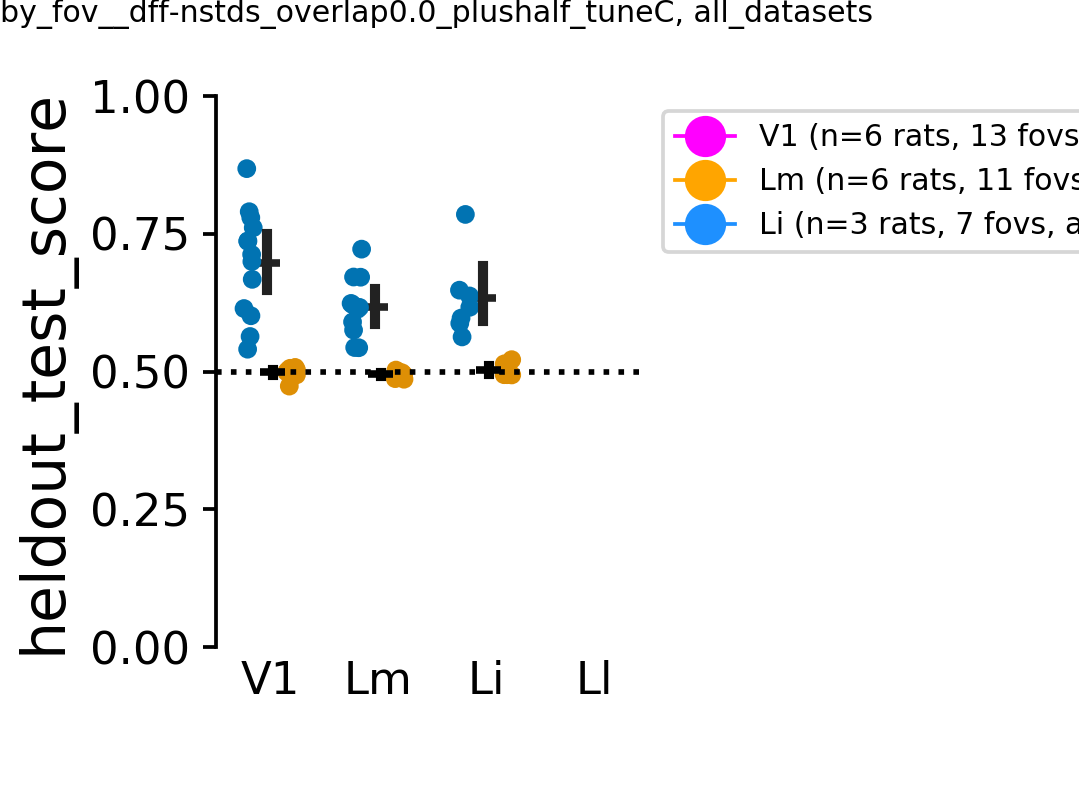

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/dff-nstds_overlap0.0_plushalf_tuneC', 'heldout_test_score_shuffled-v-true_by_fov__dff-nstds_overlap0.0_plushalf_tuneC__all_datasets')


In [502]:
metric = 'heldout_test_score'
#metric = 'test_score'

if 'pupil' in analysis_type:
    xdf = plotdf[plotdf['arousal']=='all']
else:
    xdf = plotdf.copy() #plotdf.copy()
    
df_ = passdf.copy() #xdf.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()
print("%i unique datakeys" % len(df_['datakey'].unique()))

f, ax = pl.subplots(dpi=dpi, figsize=(4,3))
f.patch.set_alpha(1)

# PLOT.
sns.pointplot(x='visual_area', y=metric, data=df_, ax=ax, 
              order=visual_areas, hue='condition', 
             color='k', markers='_', scale=1, join=False, dodge=True) #facecolor='none', lw=2)

sns.stripplot(x='visual_area', y=metric, data=df_, ax=ax, 
              hue='condition',palette='colorblind', 
              order=visual_areas, zorder=1, s=5, dodge=True) #. palette=area_colors, 

leg = aggr.get_counts_for_legend(df_, area_colors=area_colors, marker='o')
ax.legend(handles=leg, bbox_to_anchor=(1., 1), fontsize=8)

if metric=='heldout_test_score':
    ax.set_yticks(np.linspace(0, 1, 5))
    sns.despine(ax=ax, trim=True)
    ax.axhline(y=0.5, ls=':', c='k')
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
sns.despine(bottom=True)
 
putils.label_figure(f, '%s, %s' % (data_id, dset_str))
pl.subplots_adjust(left=0.2, bottom=0.2, right=0.6)



#### Save
figname = '%s_shuffled-v-true_%s__%s' % (metric, data_id, dset_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [440]:
dset_str

'all_datasets'

# Compare accuracy for data across areas

In [435]:
area_colors.update({"Li": 'dodgerblue', 'Ll': 'k'})

In [497]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

<IPython.core.display.Javascript object>


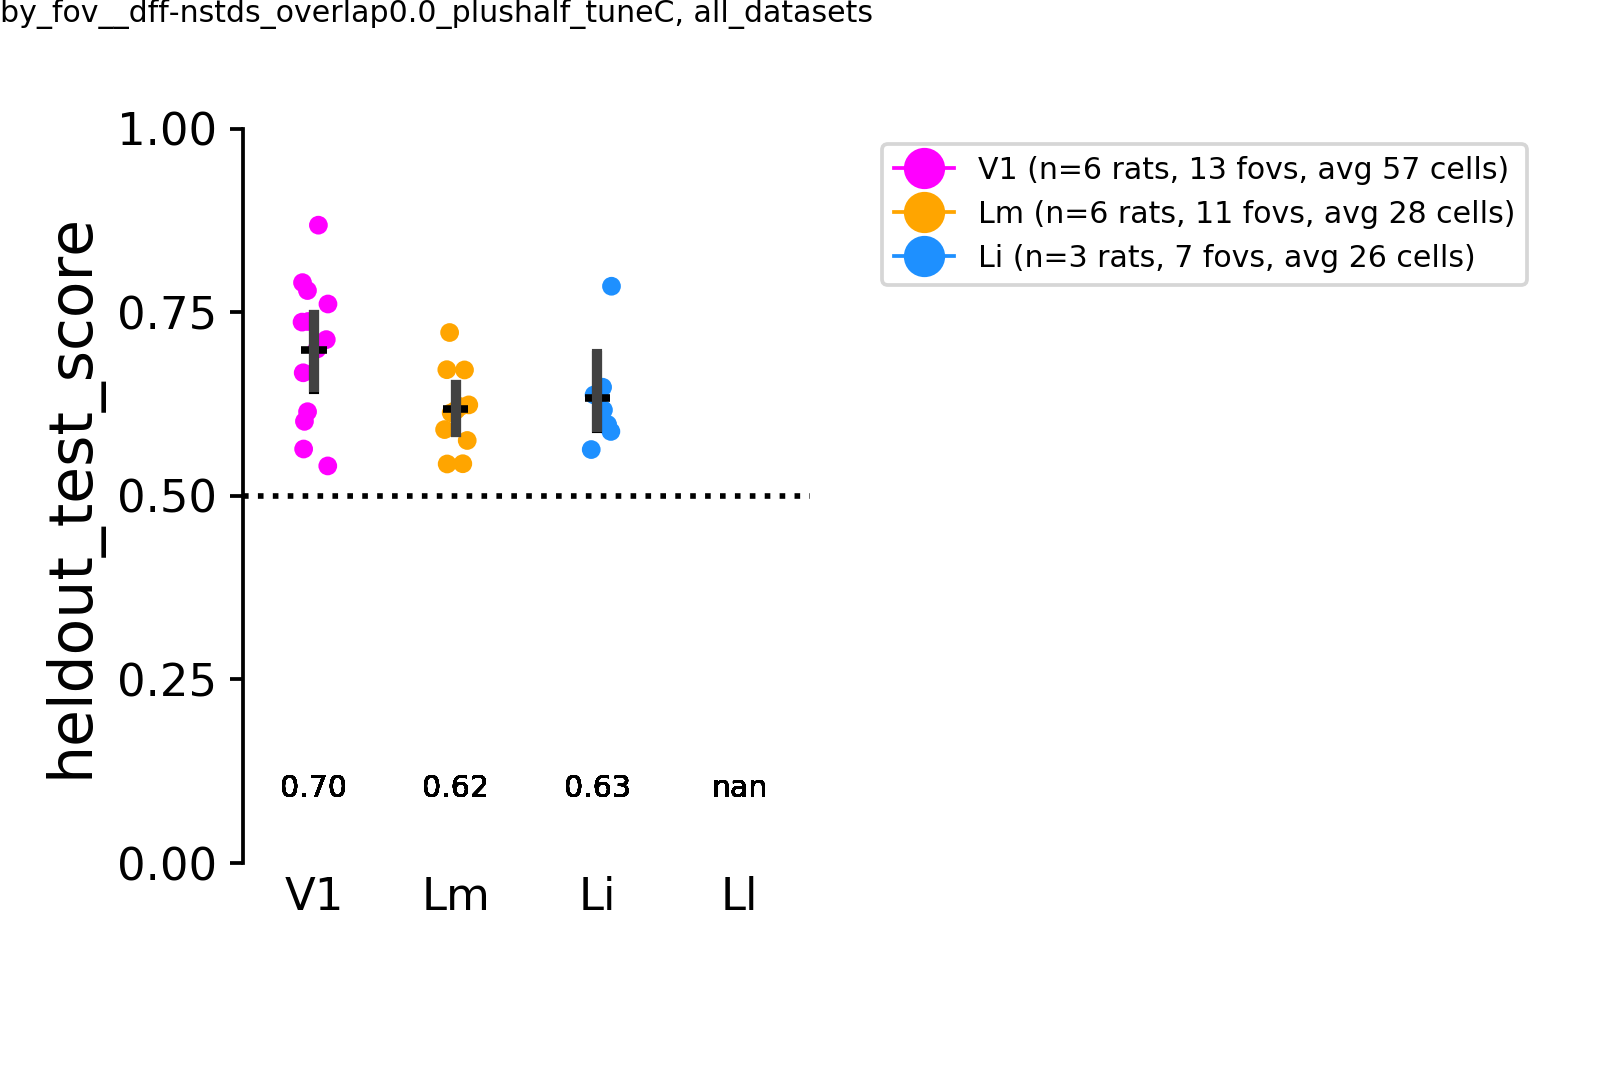

visual_area
Li    26.428571
Lm    28.636364
V1    57.615385
Name: n_cells, dtype: float64
********* [heldout_test_score] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.084 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.133 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.393 (fdr_bh), reject H0=False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/dff-nstds_overlap0.0_plushalf_tuneC', 'overall_heldout_test_score_by_fov__dff-nstds_overlap0.0_plushalf_tuneC__all_datasets')


In [503]:
metric = 'heldout_test_score'
#metric='heldout_log2MI'
#metric = 'test_score'
multi_comp_test='fdr_bh'


f, ax = pl.subplots(dpi=dpi, figsize=(6,4))
f.patch.set_alpha(1)

if 'pupil' in analysis_type:
    xdf = plotdf[plotdf['arousal']=='all']
else:
    xdf = plotdf.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()

#df_ = passdf.copy() #xdf[(xdf['condition']=='data')].copy()
df_ = passdf[passdf['condition']=='data'].copy()
print(df_.groupby(['visual_area']).mean()['n_cells'])

sns.stripplot(x='visual_area', y=metric, data=df_, ax=ax,
             palette=area_colors, order=visual_areas, zorder=1, s=5)
sns.pointplot(x='visual_area', y=metric, data=df_, ax=ax, order=visual_areas,
              markers='_', color='k', join=False, zorder=0)
sns.barplot(x='visual_area', y=metric, data=df_, ax=ax,
             color='none', facecolor='none', edgecolor='none', order=visual_areas)

df_.apply(aggr.annotateBars, ax=ax, axis=1, 
             fontsize=8, fontcolor='k', fmt='%.2f', xytext=(0, 20))
    
#### Stats
statsresults, ax = aggr.plot_mannwhitney(df_, metric=metric, 
                                         multi_comp_test=multi_comp_test, ax=ax)

#### Legend
leg = aggr.get_counts_for_legend(df_, area_colors=area_colors, marker='o')
ax.legend(handles=leg, bbox_to_anchor=(1.1, 1), fontsize=8)

#### Formatting
if metric=='heldout_test_score':
    ax.set_yticks(np.linspace(0, 1, 5))
    sns.despine(ax=ax, trim=True)
    ax.axhline(y=0.5, ls=':', c='k')
    
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
sns.despine(bottom=True)
 
putils.label_figure(f, '%s, %s' % (data_id, dset_str))
pl.subplots_adjust(left=0.15, bottom=0.2, right=0.5)

#### Save

#### Save
figname = 'overall_%s_%s__%s' % (metric, data_id, dset_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [480]:
df_.groupby(['visual_area']).mean()['n_cells']

visual_area
Li    22.500000
Lm    27.222222
V1    67.100000
Name: n_cells, dtype: float64

In [452]:
df_

visual_area              datakey condition         C  fit_time  heldout_MI  \
0           Li  20190602_JC091_fov1      data   0.03070  0.003669    0.185412   
2           Li  20190606_JC091_fov1      data  35.32033  0.135654    0.014885   
4           Li  20190607_JC091_fov1      data  23.68873  0.393171    0.036250   
6           Li  20190609_JC099_fov1      data  31.23730  0.139067    0.052685   
8           Li  20190612_JC099_fov1      data  10.31230  0.022308    0.029852   
10          Li  20190614_JC091_fov1      data   0.52687  0.011321    0.045978   
12          Li  20191018_JC113_fov1      data  23.96530  0.031244    0.018737   
14          Lm  20190430_JC078_fov1      data   3.41776  0.028361    0.040599   
16          Lm  20190504_JC078_fov1      data   2.54188  0.002135    0.018603   
18          Lm  20190506_JC080_fov1      data  13.62790  0.135979    0.067996   
20          Lm  20190508_JC083_fov1      data  11.11780  0.133619    0.069841   
22          Lm  20190512_JC083_fov1      data  31.60261  0.354386    0.032465   
24          Lm  20190513_JC078_fov1      data  16.74775  0.048679    0.024031   
26          Lm  20190517_JC083_fov1      data  23.52133  0.057517    0.034726   
28          Lm  20190525_JC084_fov1      data  16.51060  0.127742    0.111398   
30          Lm  20190603_JC080_fov1      data  45.26965  0.931134    0.012468   
32          Lm  20190618_JC097_fov1      data   0.12088  0.003062    0.049750   
34          Lm  20190627_JC091_fov1      data  15.61258  0.005861    0.011709   
36          V1  20190420_JC076_fov1      data   0.42625  0.001820    0.035083   
38          V1  20190501_JC076_fov1      data   5.89942  0.007250    0.012788   
40          V1  20190507_JC083_fov1      data   0.38080  0.002978    0.318090   
42          V1  20190508_JC083_fov1      data   0.54694  0.001627    0.052993   
44          V1  20190510_JC083_fov1      data  35.54281  0.262987    0.189933   
46          V1  20190511_JC083_fov1      data  34.75675  0.260073    0.129398   
48          V1  20190512_JC083_fov1      data  64.21546  0.039709    0.015744   
50          V1  20190522_JC084_fov1      data   0.06490  0.005382    0.156123   
52          V1  20190613_JC097_fov1      data   0.03331  0.005305    0.101449   
54          V1  20190616_JC097_fov1      data   0.09640  0.007753    0.176905   
56          V1  20190617_JC097_fov1      data   0.02071  0.003027    0.093852   
58          V1  20190622_JC085_fov1      data   0.38638  0.005808    0.065241   
60          V1  20191006_JC110_fov1      data   0.02080  0.004998    0.124752   

    heldout_aMI  heldout_log2MI  heldout_test_score  score_time  test_score  \
0      0.258011        0.267492            0.785345    0.000509    0.776971   
2      0.010014        0.021475            0.562969    0.000686    0.570954   
4      0.040371        0.052298            0.616833    0.000533    0.616667   
6      0.064458        0.076008            0.647833    0.000619    0.647542   
8      0.031020        0.043067            0.597167    0.000417    0.591792   
10     0.054657        0.066333            0.637333    0.000695    0.639708   
12     0.020750        0.027031            0.587632    0.001232    0.594653   
14     0.046368        0.058573            0.623793    0.000573    0.615886   
16     0.014448        0.026839            0.575333    0.000374    0.575417   
18     0.086423        0.098098            0.671724    0.000502    0.658719   
20     0.089106        0.100759            0.671379    0.000692    0.670770   
22     0.035321        0.046837            0.613065    0.000744    0.613810   
24     0.022152        0.034670            0.590172    0.000535    0.593143   
26     0.035739        0.050099            0.616600    0.000483    0.619150   
28     0.150224        0.160714            0.722333    0.000672    0.718208   
30     0.005414        0.017988            0.543333    0.000775    0.547000   
32     0.060032        0.071774            0.621500    0.000808    

# Split by arousal

<IPython.core.display.Javascript object>


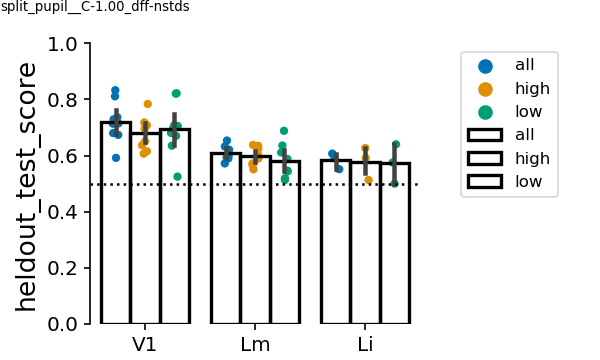

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/split_pupil', 'split_low-v-high_heldout_test_score__C-1.00')


In [391]:
if 'pupil' in analysis_type:
    metric='heldout_test_score'
    f, ax = pl.subplots(dpi=dpi, figsize=(5,3))
    f.patch.set_alpha(1)

    sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax, hue='arousal',
                order=visual_areas,
                 edgecolor=('k', 'k', 'k'), facecolor='none', lw=2)

    sns.stripplot(x='visual_area', y=metric, data=plotdf, ax=ax, hue='arousal',
                 palette='colorblind', order=visual_areas, zorder=1, s=5, dodge=True)

    sns.despine(bottom=True, ax=ax)
    ax.set_ylim([0, 1])
    ax.axhline(y=0.5, ls=':', c='k')
    ax.legend(bbox_to_anchor=(1.1, 1))

    putils.label_figure(f, data_id)
    pl.subplots_adjust(right=0.7, bottom=0.1, left=0.15)

    figname = 'split_low-v-high_%s__%s' % (metric, C_str)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

In [24]:
def plot_pairwise_by_axis(plotdf, curr_metric='abs_coef', c1='az', c2='el', 
                          compare_var='cond', fontsize=10, fontcolor='k', fmt='%.2f', xytext=(0, 10),
                          area_colors=None, legend=True):

    fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)
    ax = aggr.pairwise_compare_single_metric(plotdf, curr_metric=curr_metric, ax=ax,
                                                c1=c1, c2=c2, compare_var=compare_var)
    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=fontsize, fontcolor=fontcolor, fmt=fmt, xytext=xytext)
    
    # Set x labels
    aggr.set_split_xlabels(ax, a_label=c1, b_label=c2)

    if legend:
        # Get counts of samples for legend
        legend_elements = aggr.get_counts_for_legend(plotdf, area_colors=area_colors, markersize=10, marker='_')
        ax.legend(handles=legend_elements, bbox_to_anchor=(1.5,1.1), fontsize=8)

    return fig


In [25]:
reload(rfutils)

<module 'pipeline.python.classifications.rf_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/rf_utils.pyc'>

<IPython.core.display.Javascript object>


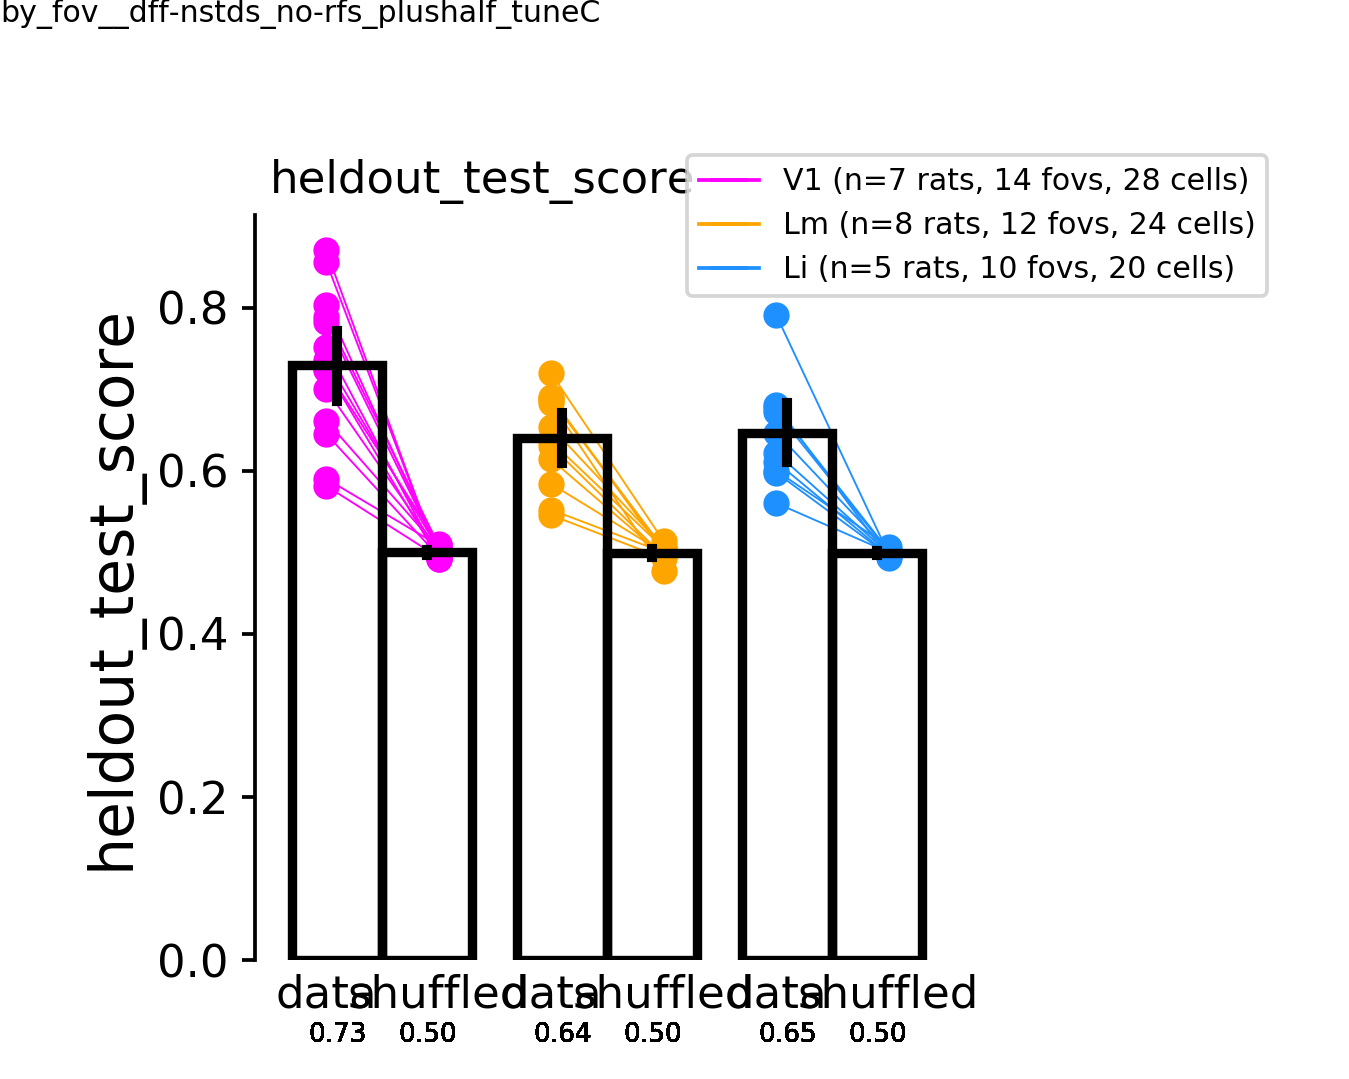

V1: (t-stat:9.52, p=0.00)
Lm: (t-stat:8.79, p=0.00)
Li: (t-stat:7.09, p=0.00)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/dff-nstds_no-rfs_plushalf_tuneC', 'paired_low-v-high_heldout_test_score__tuneC')


In [26]:
metric = 'heldout_test_score'
#metric = 'abs_coef'

if 'pupil' in analysis_type:
    currdf = plotdf[plotdf['arousal'].isin(['low', 'high'])]
    c1='low'
    c2='high'
    compare_var='arousal'
else:
    currdf = xdf.copy()
    c1='data'
    c2='shuffled'
    compare_var='condition'

for metric in ['heldout_test_score']: #, 'heldout_log2MI', 'n_trials']:
    fig = plot_pairwise_by_axis(currdf, curr_metric=metric, 
                                c1=c1, c2=c2, compare_var=compare_var,
                               area_colors=area_colors, fontsize=7, 
                                fontcolor='k', fmt='%.2f', xytext=(0, -20))
    
    pl.subplots_adjust(left=0.2, right=0.7, top=0.8)
    fig.axes[0].set_title(metric, loc='left')
    
    putils.label_figure(fig, data_id)
    
    figname = 'paired_low-v-high_%s__%s' % (metric, C_str)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

In [164]:
currdf.head()

visual_area              datakey condition        C  fit_time  heldout_MI  \
0          Li  20190315_JC070_fov1      data  0.59230  0.007353    0.056369   
1          Li  20190315_JC070_fov1  shuffled  0.59230  0.019664    0.013749   
2          Li  20190316_JC070_fov1      data  2.60830  0.057331    0.026365   
3          Li  20190316_JC070_fov1  shuffled  2.60830  0.156536    0.011177   
4          Li  20190602_JC091_fov1      data  0.01252  0.005942    0.201627   

   heldout_aMI  heldout_log2MI  heldout_test_score  score_time  test_score  \
0     0.070156        0.081324            0.650500    0.001202    0.648271   
1     0.007640        0.019835            0.489667    0.001378    0.500019   
2     0.026087        0.038037            0.595000    0.001279    0.600804   
3     0.003867        0.016124            0.490833    0.001535    0.502213   
4     0.283002        0.290886            0.799655    0.001729    0.789154   

   train_score  n_cells  n_trials  iteration  fovnum animalid   session  
0     0.857830     96.0     300.0       49.5     1.0    JC070  20190315  
1     0.779010     96.0     300.0       49.5     1.0    JC070  20190315  
2     0.813341     84.0     300.0       49.5     1.0    JC070  20190316  
3     0.766602     84.0     300.0       49.5     1.0    JC070  20190316  
4     0.920355    137.0     290.0       49.5     1.0    JC091  20190602

<IPython.core.display.Javascript object>


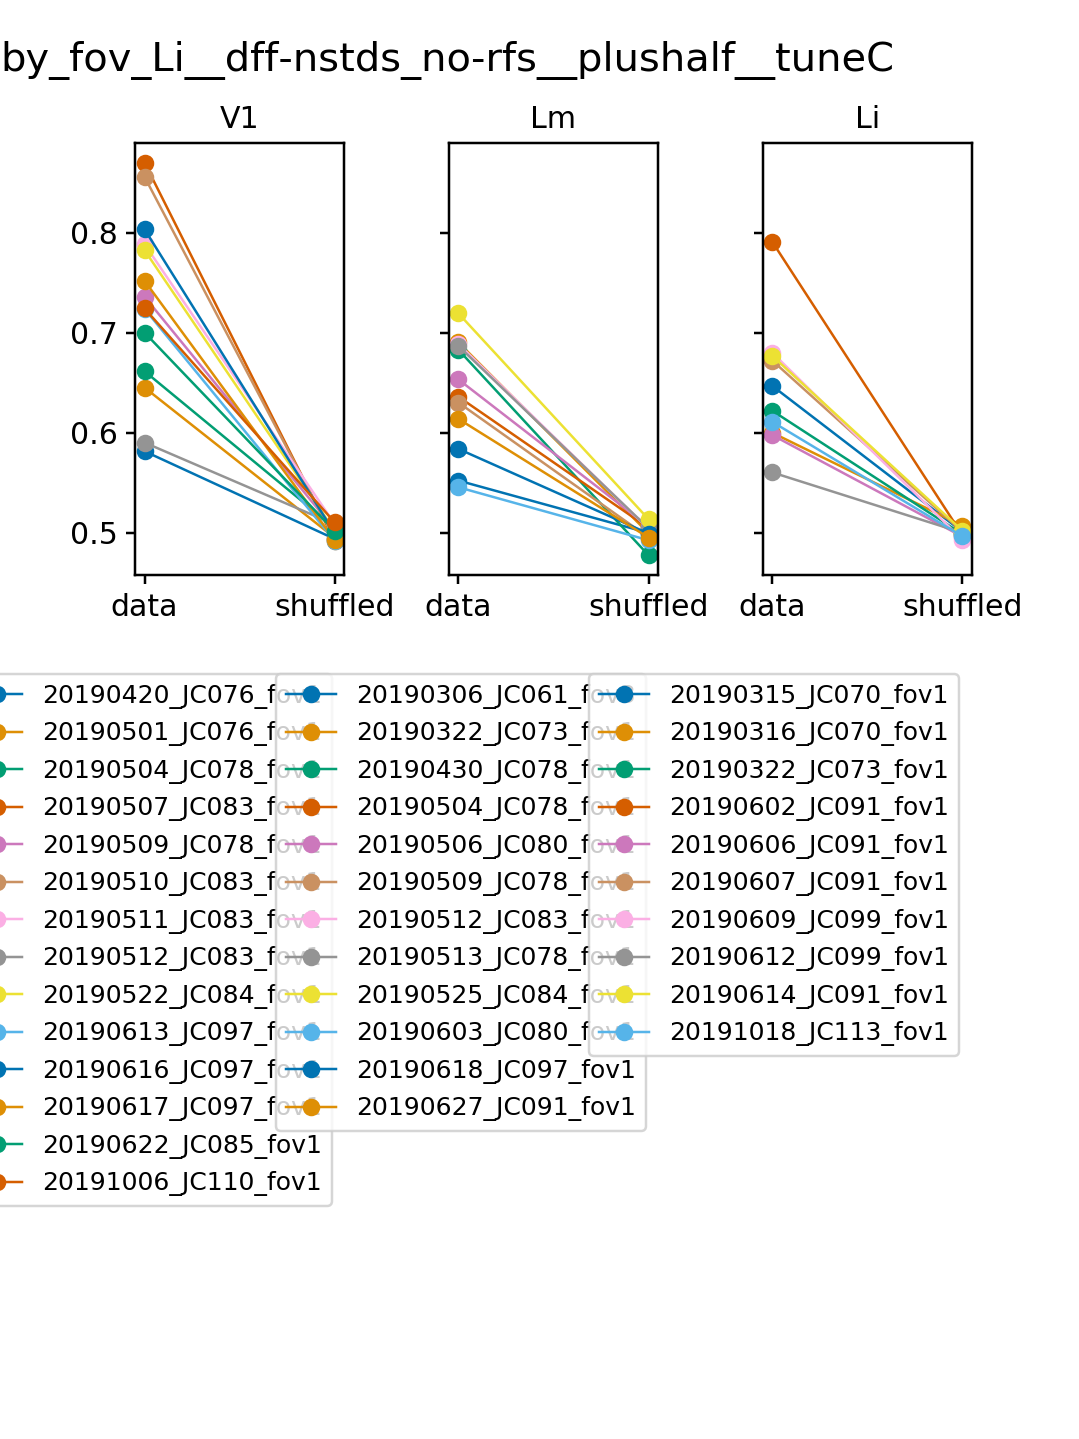

V1: (t-stat:9.52, p=0.00)
Lm: (t-stat:8.79, p=0.00)
Li: (t-stat:7.09, p=0.00)


In [27]:
if 'pupil' in analysis_type:
    currdf = plotdf[plotdf['arousal'].isin(['low', 'high'])]
    c1='low'
    c2='high'
    compare_var='arousal'
else:
    currdf = xdf.copy()
    c1='data'
    c2='shuffled'
    compare_var='condition'
    
    
    
curr_metric='heldout_test_score'
offset = 0.25
marker='o'

f, axn = pl.subplots(1,3, figsize=(6,8), sharey=True)

aix=0
for ai, visual_area in enumerate(visual_areas):
    ax=axn[ai]
    
    df_ = currdf[currdf['visual_area']==visual_area].copy()
    a_vals = df_[df_[compare_var]==c1].sort_values(by='datakey')[curr_metric].values
    b_vals = df_[df_[compare_var]==c2].sort_values(by='datakey')[curr_metric].values

    by_exp = [(a, e) for a, e in zip(a_vals, b_vals)]
    color_list = sns.color_palette('colorblind', n_colors=len(by_exp))
    labels = df_[df_[compare_var]==c1].sort_values(by='datakey')['datakey'].values
    
    for pi, (p, plabel) in enumerate(zip(by_exp, labels)):
        ax.plot([aix-offset, aix+offset], p, marker=marker, color=color_list[pi], 
                alpha=1, lw=1,  zorder=0, markerfacecolor=None, 
                markeredgecolor=color_list[pi], label=plabel)
        
    ax.set_xticks([aix-offset, aix+offset])
    ax.set_xticklabels([c1, c2])
    tstat, pval = spstats.ttest_rel(a_vals, b_vals)
    print("%s: (t-stat:%.2f, p=%.2f)" % (visual_area, tstat, pval))
    aix = aix+1
    ax.set_title(visual_area)
    
    ax.legend(bbox_to_anchor=(1, -0.2))

#     # Plot average
#     sns.barplot([0, 1], curr_metric, data=df_, 
#                 hue=compare_var, hue_order=[c1, c2], #zorder=0,
#                 ax=ax, #order=visual_areas,
#                 errcolor="k", edgecolor=('k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
#     #ax.legend_.remove()

# rfutils.set_split_xlabels(ax, a_label=c1, b_label=c2)

f.text(0, 0.95, '%s' % results_id, fontsize=16)
pl.subplots_adjust(bottom=0.6, wspace=0.5, top=0.9)


# figname = 'paired_low-v-high_color-FOV_%s__%s' % (metric, C_str)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# print(dst_dir, figname)

In [166]:
currdf[(currdf['condition']=='data') & (currdf['visual_area']=='Li') & (currdf[metric]<=0.5)]

Empty DataFrame
Columns: [visual_area, datakey, condition, C, fit_time, heldout_MI, heldout_aMI, heldout_log2MI, heldout_test_score, score_time, test_score, train_score, n_cells, n_trials, iteration, fovnum]
Index: []

In [40]:
bds = glob.glob(os.path.join(rootdir, 'JC*', '2019*', '*%s' % fov_type, 'combined_blobs*', 
                            'traces', '%s*' % traceid, 'decoding', 'splitpupil*.pkl'))
bds

['/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_ea0b53_traces001_92d492_traces001_af4cfd_traces001_9188fa_traces001_b44714_traces001_133108/decoding/splitpupil_results_V1_tuneC__dff-nstds.pkl',
 '/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_dea723_traces001_8cef6c_traces001_abf256_traces001_fb7bfa_traces001_452942_traces001_c0afbd/decoding/splitpupil_results_Lm_tuneC__dff-nstds.pkl',
 '/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_573669_traces001_3d2687_traces001_17838a_traces001_452178_traces001_c84a17_traces001_faae98/decoding/splitpupil_results_Li_tuneC__dff-nstds.pkl',
 '/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_2afecb_traces001_8b62a3_traces001_fa925f_traces001_bcbaba_traces001_821fff_traces001_361c93/decoding/splitpupil_results_Li_tuneC__dff-nstds.pkl',
 '/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/combined_b

In [37]:
rfile = bds[1]
with open(rfile, 'rb') as f:
    d = pkl.load(f)
d.groupby(['arousal']).mean()

C  fit_time  heldout_MI  heldout_aMI  heldout_log2MI  \
arousal                                                               
all      0.02386  0.171685    0.170252     0.237016        0.245622   
high     0.03430  0.025259    0.084630     0.084727        0.122095   
low      0.03484  0.029401    0.080132     0.081467        0.115606   

         heldout_test_score  n_cells  n_trials  score_time  test_score  \
arousal                                                                  
all                0.776333      294       300    0.032981    0.758129   
high               0.664211      294        93    0.009571    0.637845   
low                0.676000      294       100    0.008663    0.702166   

         train_score  
arousal               
all         0.974251  
high        0.974595  
low         0.979818

In [36]:
d.groupby(['arousal']).mean()

C  fit_time  heldout_MI  heldout_aMI  heldout_log2MI  \
arousal                                                               
all      0.02962  0.070754    0.193766     0.271013        0.279545   
high     0.03142  0.013911    0.145102     0.179215        0.209338   
low      0.01180  0.015889    0.119079     0.141496        0.171794   

         heldout_test_score  n_cells  n_trials  score_time  test_score  \
arousal                                                                  
all                0.792069      136       290    0.021631    0.793375   
high               0.731000      136        97    0.005092    0.740175   
low                0.722857      136       102    0.006979    0.731188   

         train_score  
arousal               
all         0.917475  
high        0.967003  
low         0.949439

In [19]:
metric='heldout_test_score'
res[metric].mean(), res[metric].std()

(0.7258333333333333, 0.059429338210849815)

# Equal trial counts

In [69]:
trial_epoch = 'stimulus'
MEANS = aggr.load_aggregate_data(experiment, responsive_test=responsive_test, responsive_thr=responsive_thr, 
               response_type=response_type, epoch=trial_epoch)

MEANS = equal_counts_per_condition(MEANS)


...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl
20190512_JC083_fov1: n=31
20190606_JC091_fov1: n=32
20190605_JC090_fov1: n=32
20190602_JC091_fov1: n=29
20190508_JC083_fov1: n=29
20190617_JC097_fov1: n=29
20190430_JC078_fov1: n=29
20191006_JC110_fov1: n=33
20190617_JC099_fov1: n=19
20190513_JC078_fov1: n=29
20190502_JC076_fov1: n=26


In [66]:
len(curr_counts.unique())


3

# Classify A/B, by NCELLS

In [39]:
train_str = 'traintest_by-ncells' 
glob.glob(os.path.join(decoding_dir, 'by_ncells', '%s_iter*.pkl' % (train_str)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells/traintest_by-ncells_iter-500_overlap-0.80_results_20200926.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells/traintest_by-ncells_iter-50_overlap-0.80_results_20200926.pkl']

In [95]:
dst_dir = os.path.join(decoding_dir, 'by_ncells')
os.listdir(dst_dir)

['traintest_by-ncells_iter-500_overlap-0.80_results_20200926.pkl',
 'traintest_by-ncells_iter-500_overlap-0.80_params_20200926.json',
 'traintest_by-ncells_iter-500__heldout_test_scorezoom_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_iter-500__heldout_test_score_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_iter-500__heldout_log2MI_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_iter-500__heldout_log2MIzoom_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_iter-500__heldout_aMI_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_iter-500__heldout_aMIzoom_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_overlap-0.80_decode_heldout_log2MI_20200926.svg',
 'traintest_by-ncells_overlap-0.80_decode_heldout_log2MIzoom_20200926.svg',
 'traintest_by-ncells_overlap-0.80_decode_heldout_test_scorezoom_20200926.svg',
 'traintest_by-ncells_overlap-0.80_d

In [96]:
n_iterations = 500
overlap_thr=0.8
train_str = 'traintest_by-ncells' 
glob.glob(os.path.join(dst_dir, '%s_iter-%i_overlap-%.2f_*.pkl' % (train_str, n_iterations, overlap_thr)))
#glob.glob(os.path.join(dst_dir, '*overlap-%.2f_*.pkl' % (overlap_thr)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells/traintest_by-ncells_iter-500_overlap-0.80_results_20200926.pkl']

In [97]:
results_dfile = glob.glob(os.path.join(dst_dir, 
                                      '%s_iter-%i_overlap-%.2f_*.pkl' % (train_str, n_iterations, overlap_thr)))[0]

# results_dfile = glob.glob(os.path.join(dst_dir, 
#                                        '*overlap-%.2f_*.pkl' % (overlap_thr)))[0]
#results_dfile = os.path.join(dst_dir, 'results_20200924.pkl')
# 'results_overlap-0.80.pkl' 200 cells, incoplete

with open(results_dfile, 'rb') as f:
    results = pkl.load(f)
if isinstance(results, dict):
    print(results.keys())
    results = results['pooled']
    #sdf = resultsdict['sdf']
else:
    results = results
    
results_basename = os.path.splitext(os.path.split(results_dfile)[-1])[0]
params_dfile = '%s.json' % os.path.splitext(results_dfile)[0].replace('results', 'params')
if os.path.exists(params_dfile):
    with open(params_dfile, 'r') as f:
        params = json.load(f)
    print("Train/test params for %s:" % train_str)
    pp.pprint(params)
else:
    print("No params")
print("File basename: %s" % results_basename)

['pooled']
Train/test params for traintest_by-ncells:
{   u'C_value': None,
    u'cv': True,
    u'cv_nfolds': 5,
    u'n_iterations': 500,
    u'overlap_thr': 0.8,
    u'test_split': 0.2}
File basename: traintest_by-ncells_iter-500_overlap-0.80_results_20200926


In [98]:
results.keys()

Index([u'C', u'C_sem', u'C_std', u'fit_time', u'fit_time_sem', u'fit_time_std',
       u'heldout_MI', u'heldout_MI_sem', u'heldout_MI_std', u'heldout_aMI',
       u'heldout_aMI_sem', u'heldout_aMI_std', u'heldout_log2MI',
       u'heldout_log2MI_sem', u'heldout_log2MI_std', u'heldout_test_score',
       u'heldout_test_score_sem', u'heldout_test_score_std', u'n_units',
       u'overlap', u'score_time', u'score_time_sem', u'score_time_std',
       u'test_accuracy', u'test_accuracy_sem', u'test_accuracy_std',
       u'test_precision_macro', u'test_precision_macro_sem',
       u'test_precision_macro_std', u'test_recall_macro',
       u'test_recall_macro_sem', u'test_recall_macro_std', u'train_accuracy',
       u'train_accuracy_sem', u'train_accuracy_std', u'train_precision_macro',
       u'train_precision_macro_sem', u'train_precision_macro_std',
       u'train_recall_macro', u'train_recall_macro_sem',
       u'train_recall_macro_std', u'visual_area'],
      dtype='object')

In [99]:
date_str = results_basename.split('_')[-1]
plot_str = '_test_%s_overlap-%.2f' % (train_str, overlap_thr)
fig_str = '%s_%s' % (response_str, filter_str)
data_id = '%s|%s' % (traceid, fig_str)
print(data_id)
print(plot_str)
print(date_str)

traces001|dff_nstds-thr-10.00_filter_first_blobsonly
_test_traintest_by-ncells_overlap-0.80
20200926


In [100]:
reload(dutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.pyc'>

<IPython.core.display.Javascript object>


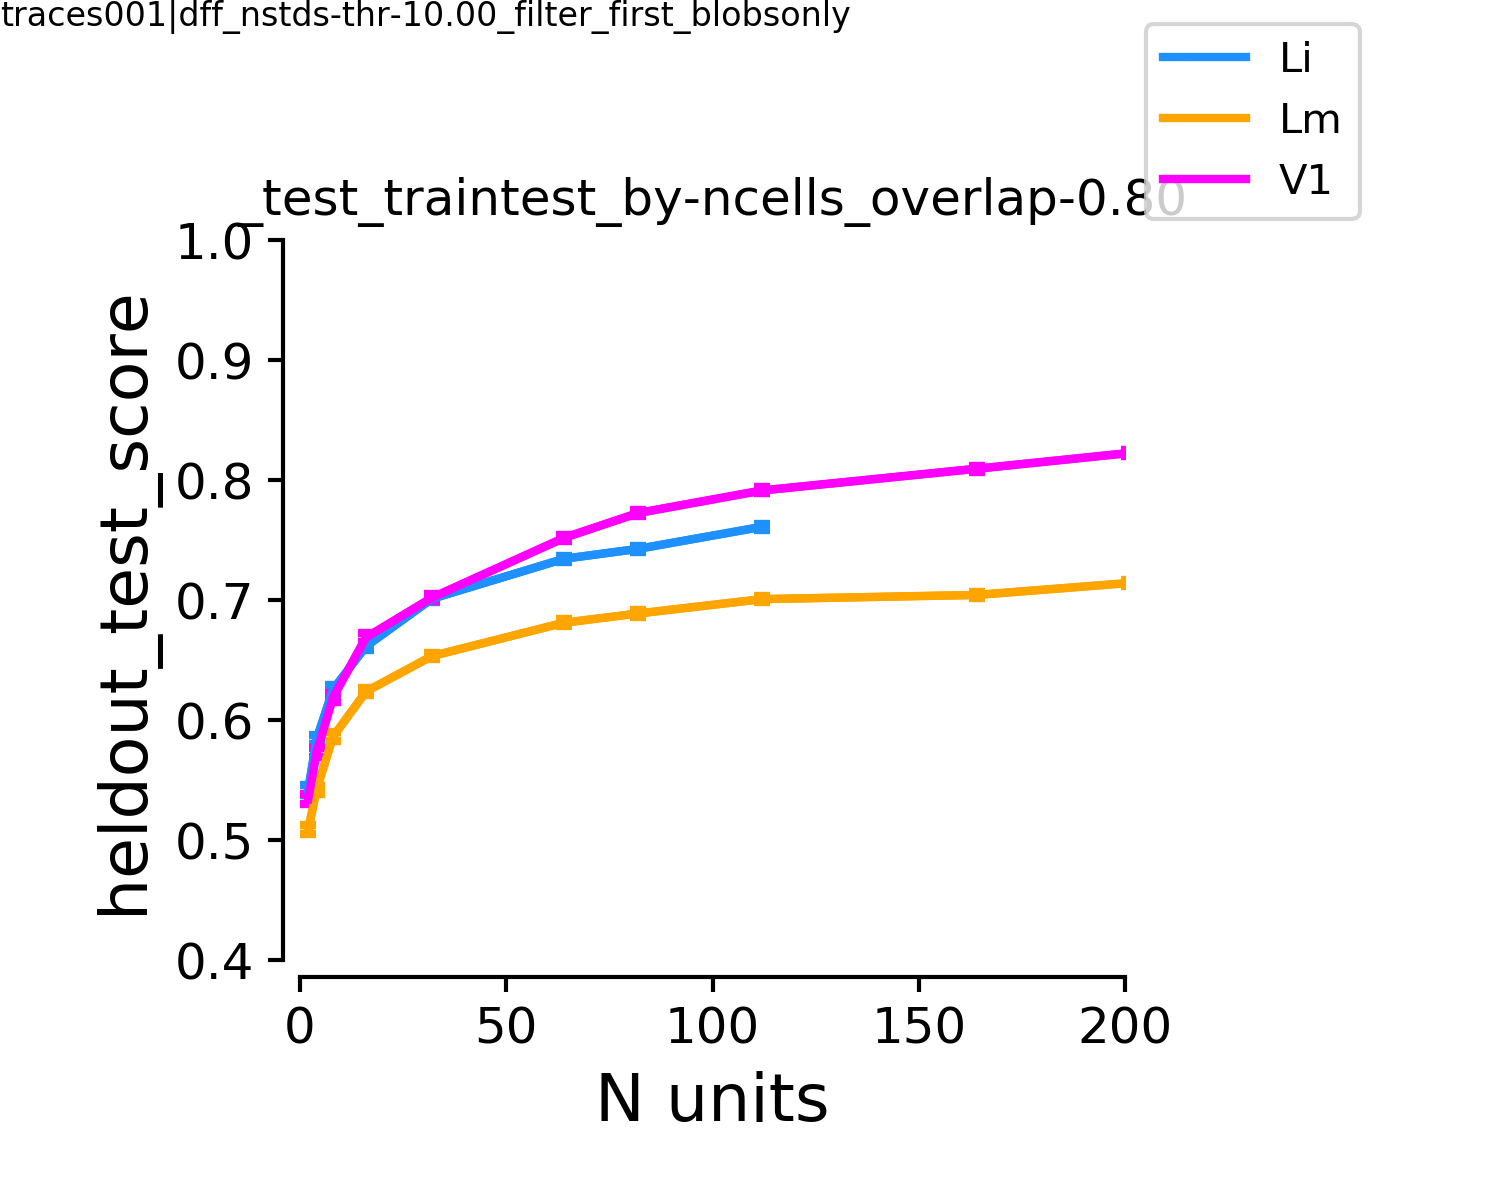

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells', '_test_traintest_by-ncells_overlap-0.80_decode_heldout_test_scorezoom')


<IPython.core.display.Javascript object>


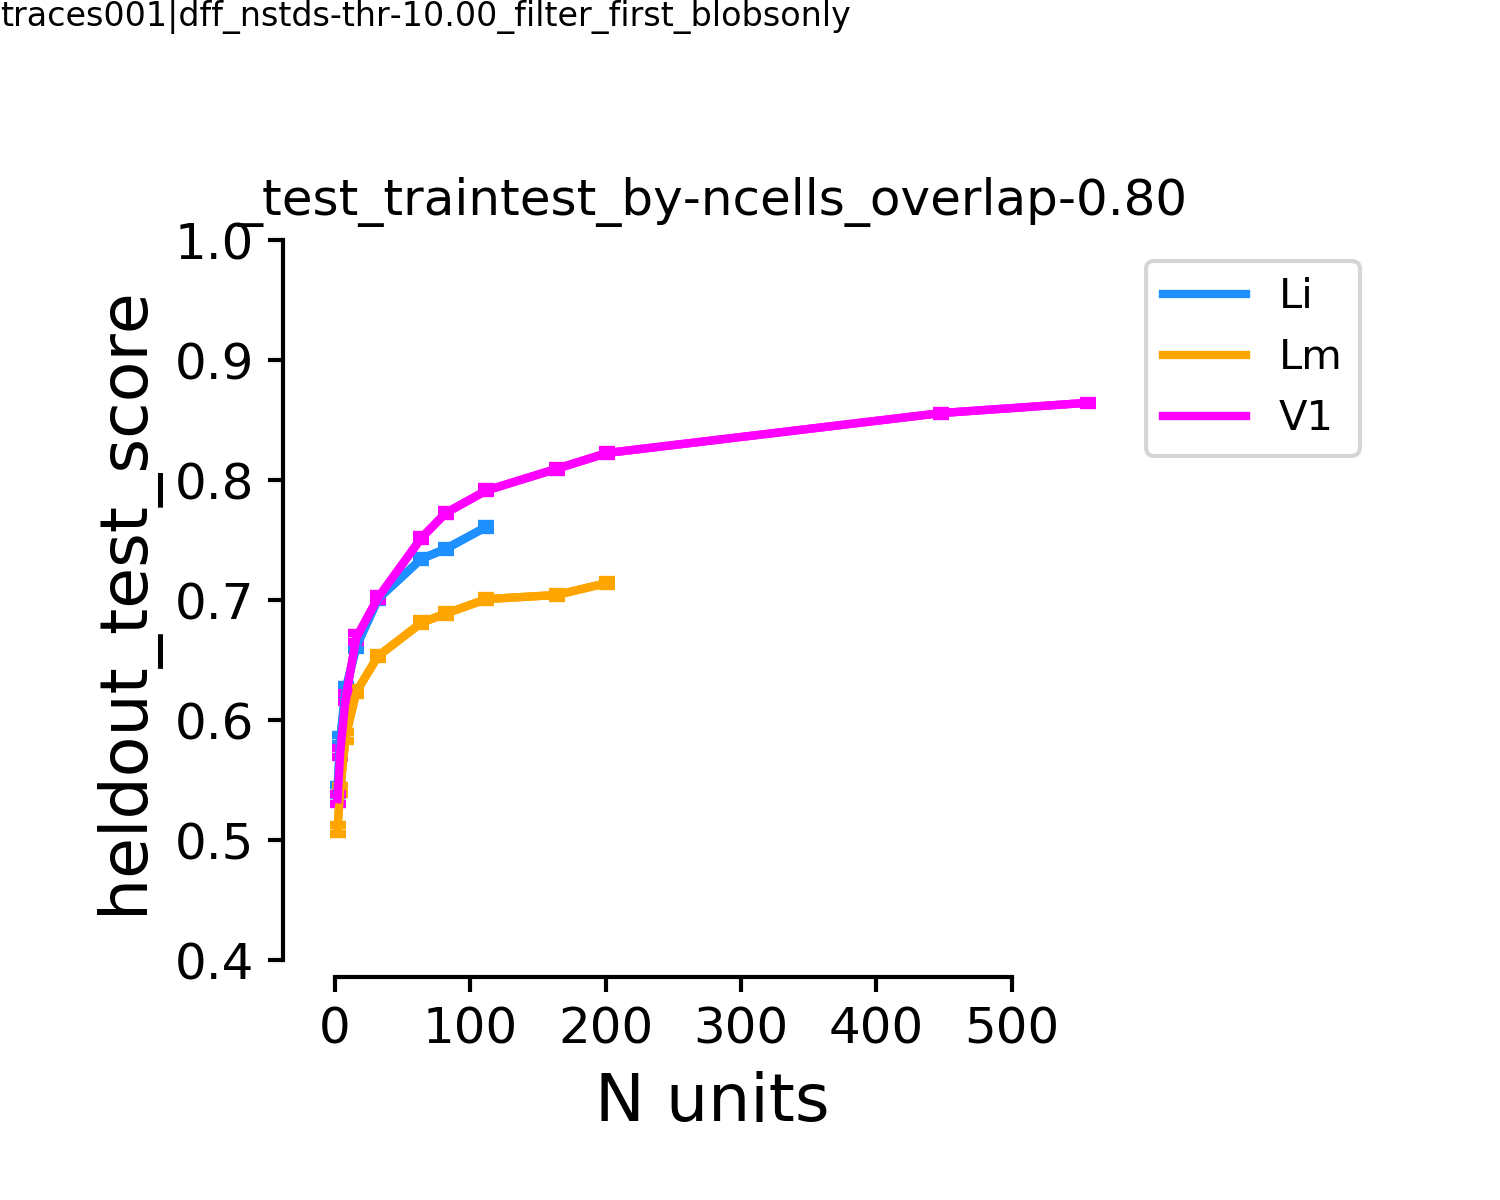

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells', '_test_traintest_by-ncells_overlap-0.80_decode_heldout_test_score')


In [101]:
metric = 'heldout_test_score'
dutils.default_classifier_by_ncells(results, metric=metric, plot_str=plot_str, date_str=date_str,
                                    dst_dir=dst_dir, data_id=data_id, area_colors=area_colors, xlim=200)
                                    

# Test Generalization -- size

In [60]:
n_train_configs=4
n_iterations = 100
sample_ncells=112
train_str = 'train-%i_sample-%i_iter-%i' % (n_train_configs, sample_ncells, n_iterations)  

overlap_thr=0.8
glob.glob(os.path.join(decoding_dir, 'match_RF_overlap', '%s*.pkl' % (train_str)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap/train-4_sample-112_iter-100_results.pkl']

In [65]:
overlap_dir = os.path.join(decoding_dir, 'match_RF_overlap')
results_dfile = glob.glob(os.path.join(overlap_dir, '%s*.pkl' % (train_str)))[0]
with open(results_dfile, 'rb') as f:
    results = pkl.load(f)

results_basename = os.path.splitext(os.path.split(results_dfile)[-1])[0]
print("File basename: %s" % results_basename)

File basename: train-4_sample-112_iter-100_results


In [12]:
animalid = 'JC097'
session = '20190616'
fovnum = 1
exp = util.Objects(animalid, session, 'FOV%i_zoom2p0x' % fovnum, traceid=traceid)
sdf = exp.get_stimuli()


In [67]:
plot_str = '%s_overlap-%.2f' % (train_str, overlap_thr)
fig_str = '%s_%s' % (response_str, filter_str)
data_id = '%s|%s' % (traceid, fig_str)
print(data_id)

traces001|dff_nstds-thr-10.00_filter_first_blobsonly


In [71]:
reload(dutils)

<module 'pipeline.python.classifications.decode_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/decode_utils.py'>

<IPython.core.display.Javascript object>


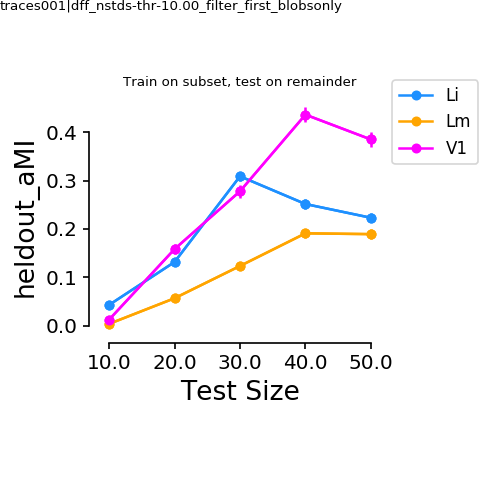

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap', 'train-4_sample-112_iter-100_overlap-0.80_generalize_size')


<IPython.core.display.Javascript object>


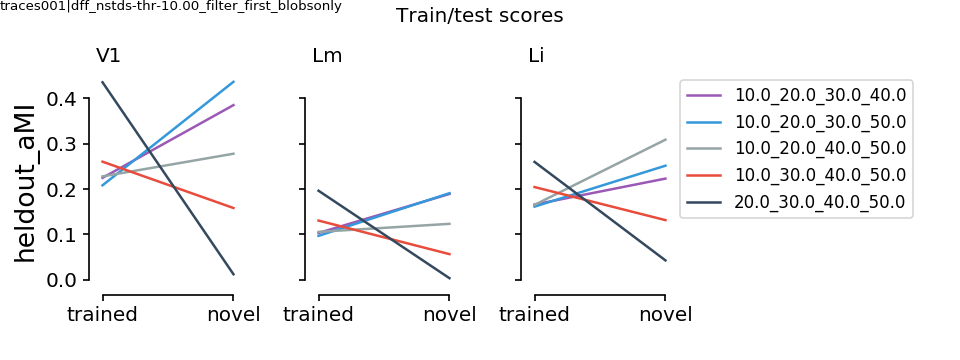

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap', 'train-4_sample-112_iter-100_overlap-0.80_generalize_size__avg-novel-v-trained')


<IPython.core.display.Javascript object>


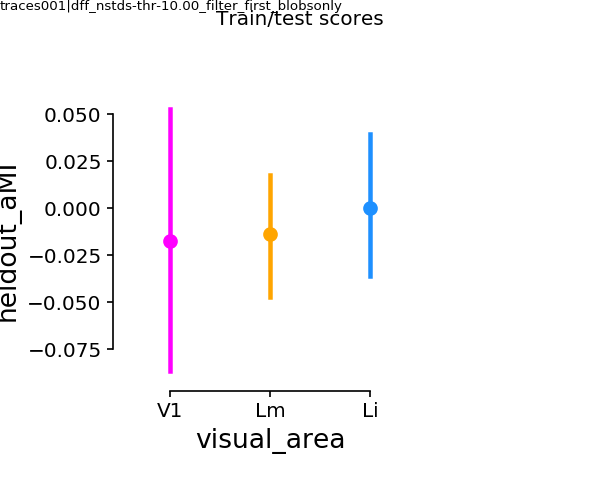

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap', 'train-4_sample-112_iter-100_overlap-0.80_generalize_size__avg-novel-v-trained-difference')


In [73]:
metric = 'heldout_aMI'
dutils.default_train_test_subset(results, sdf, metric=metric, area_colors=area_colors, 
                                 plot_str=plot_str, data_id=data_id, dst_dir=overlap_dir)


In [77]:
results.head()

C  fit_time  heldout_MI  heldout_aMI  heldout_log2MI  \
0  0.010  0.002216    0.055217     0.065015        0.079662   
1  0.010  0.002216    0.167874     0.232338        0.242191   
2  0.001  0.002637    0.134455     0.180996        0.193977   
3  0.001  0.002637    0.062245     0.077773        0.089801   
4  0.010  0.002267    0.153134     0.208435        0.220926   

   heldout_test_score  score_time  test_accuracy  test_precision_macro  \
0            0.659574    0.002186       0.773052              0.780050   
1            0.758621    0.002186       0.773052              0.780050   
2            0.744681    0.002641       0.696989              0.728557   
3            0.637931    0.002641       0.696989              0.728557   
4            0.765957    0.002227       0.675786              0.691301   

   test_recall_macro       test_transform  train_accuracy  \
0           0.773099  10.0_20.0_30.0_40.0        0.878349   
1           0.773099                 50.0        0.878349   
2           0.698246  10.0_20.0_30.0_50.0        0.772837   
3           0.698246                 40.0        0.772837   
4           0.675439  10.0_20.0_40.0_50.0        0.850086   

   train_precision_macro  train_recall_macro      train_transform  iteration  \
0               0.878713            0.878306  10.0_20.0_30.0_40.0          0   
1               0.878713            0.878306  10.0_20.0_30.0_40.0          0   
2               0.806416            0.773706  10.0_20.0_30.0_50.0          0   
3               0.806416            0.773706  10.0_20.0_30.0_50.0          0   
4               0.851258            0.850153  10.0_20.0_40.0_50.0          0   

   n_units visual_area  overlap  
0      112          Li      0.8  
1      112          Li      0.8  
2      112          Li      0.8  
3      112          Li      0.8  
4      112          Li      0.8

# Test generalization - 1 size

In [83]:
n_train_configs=1
n_iterations = 100
sample_ncells=112
train_str = 'train-%i_sample-%i_iter-%i' % (n_train_configs, sample_ncells, n_iterations)  

overlap_thr=0.8
glob.glob(os.path.join(decoding_dir, 'train-1_test-1', '%s*.pkl' % (train_str)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1/train-1_sample-112_iter-100_results.pkl']

In [84]:
dst_dir = os.path.join(decoding_dir, 'train-1_test-1')
results_dfile = glob.glob(os.path.join(dst_dir, '%s*.pkl' % (train_str)))[0]
with open(results_dfile, 'rb') as f:
    results = pkl.load(f)

results_basename = os.path.splitext(os.path.split(results_dfile)[-1])[0]
print("File basename: %s" % results_basename)

File basename: train-1_sample-112_iter-100_results


In [85]:
plot_str = '%s_overlap-%.2f' % (train_str, overlap_thr)
fig_str = '%s_%s' % (response_str, filter_str)
data_id = '%s|%s' % (traceid, fig_str)
print(data_id)

traces001|dff_nstds-thr-10.00_filter_first_blobsonly


<IPython.core.display.Javascript object>


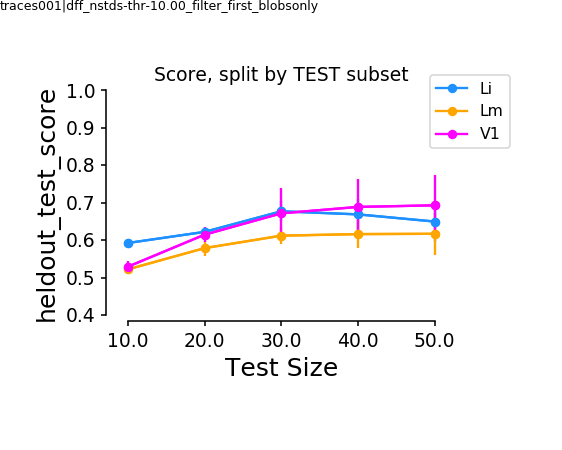

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1', 'train-1_sample-112_iter-100_overlap-0.80_heldout_test_score_by-test-size')


In [468]:
metric = 'heldout_test_score'
testdf = pd.concat([g[g['test_transform']!=train].groupby(['visual_area', 'test_transform']).mean() \
           for (visual_area, train), g in results.groupby(['visual_area', 'train_transform'])]).reset_index()


fig, ax = pl.subplots(figsize=(5,4), dpi=150)
# dutils.plot_scores_by_test_set(results, sdf, metric=metric, area_colors=area_colors, ax=ax, plot_sem=True)

sizes = [str(s) for s in sdf['size'].unique()]
markersize=5
for visual_area, vdf in testdf.groupby(['visual_area']):
    #for train, traindf in vdf.groupby(['train_transform']):
    mean_vals = vdf.groupby(['test_transform']).mean()[metric]
    sem_vals = vdf.groupby(['test_transform']).sem()[metric]

    ax.plot(np.arange(0, len(sizes)), mean_vals, color=area_colors[visual_area],
               marker='o', markersize=markersize, label=visual_area)
    ax.errorbar(np.arange(0, len(sizes)), mean_vals, yerr=sem_vals, color=area_colors[visual_area],
               marker='o', markersize=markersize, label=None)

    ax.set_xticks(np.arange(0, len(sizes)))
    ax.set_xticklabels(sizes)

ax.set_xlabel('Test Size', fontsize=16)
ax.set_ylabel(metric, fontsize=16)
pl.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.3, wspace=0.3)

ax.legend(bbox_to_anchor=(1.2, 1.1))

if metric=='heldout_test_score':
    ax.set_ylim([0.4, 1])
else:
    ax.set_ylim([0, 0.4])
sns.despine(trim=True,offset=4)

putils.label_figure(fig, data_id)
ax.set_title("Score, split by TEST subset")

figname = '%s_%s_by-test-size' % (plot_str, metric)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [385]:
sizes = sdf['size'].unique()

#### Relative score

In [517]:
subtract_novel=True
metric = 'heldout_test_score'

metric_names = [p for p in results.columns if 'heldout' in p or 'C' in p]
mean_results=results.groupby(['visual_area', 'train_transform', 'test_transform']).mean()[metric_names].reset_index()

relative_df = pd.concat([pd.DataFrame({
                          'trained': [float(g[g['test_transform']==train][metric].values) for _ in np.arange(0, len(g)-1)],
                          'novel': g[g['test_transform']!=train][metric],
                          'visual_area': [visual_area for _ in np.arange(0, len(g)-1)], 
                          'train_transform': [train for _ in np.arange(0, len(g)-1)], 
                          'test_transform': g[g['test_transform']!=train]['test_transform']}) \
             for (visual_area,train), g in mean_results.groupby(['visual_area', 'train_transform'])])

if subtract_novel:
    relative_df['relative_%s' % metric] = (relative_df['trained'] - relative_df['novel']) #/ relative_df['trained']
else:
    relative_df['relative_%s' % metric] = (relative_df['novel'] - relative_df['trained']) #/ relative_df['trained']

relative_str='subtract-novel' if subtract_novel else 'subtract-trained'

<IPython.core.display.Javascript object>


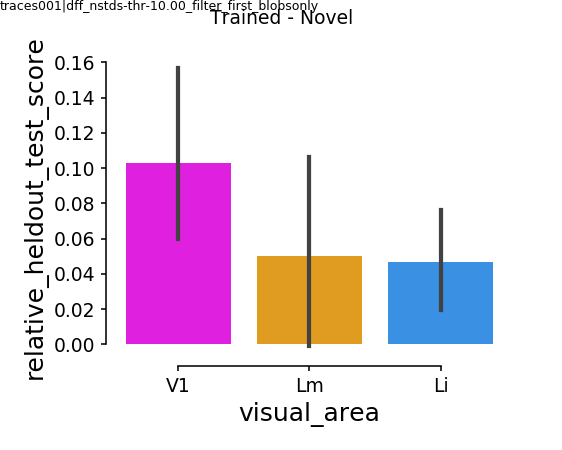

********* [relative_heldout_test_score] Mann-Whitney U test(mc=holm) **********
[('V1', 'Lm')] p=0.115 (holm), reject H0=False
[('V1', 'Li')] p=0.115 (holm), reject H0=False
[('Lm', 'Li')] p=0.299 (holm), reject H0=False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1', 'train-1_sample-112_iter-100_overlap-0.80_avg-novel-v-trained_relative_heldout_test_score_subtract-novel')


In [518]:
fig, ax = pl.subplots(1, dpi=dpi, figsize=(5,4), sharex=True, sharey=True)
sns.barplot(x='visual_area', y='relative_%s' % metric, data=relative_df, ax=ax,
           order=visual_areas, palette=area_colors)
#sns.stripplot(x='visual_area', y='relative_%s' % metric, data=relative_df, ax=ax,
#            hue='test_transform', palette='colorblind', order=visual_areas, dodge=True)
statresults, ax = aggr.plot_mannwhitney(relative_df, metric='relative_%s' % metric, multi_comp_test='holm', ax=ax)
sns.despine(trim=True, offset=4)

pl.subplots_adjust(left=0.2, right=0.9, bottom=0.2)

putils.label_figure(fig, data_id)


if subtract_novel:
    fig.suptitle('Trained - Novel')
else:
    fig.suptitle('Novel - Trained')

figname = '%s_avg-novel-v-trained_relative_%s_%s' % (plot_str, metric, relative_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


<IPython.core.display.Javascript object>


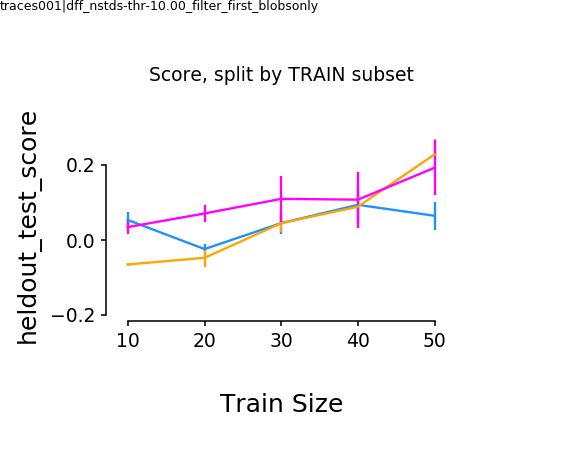

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1', 'train-1_sample-112_iter-100_overlap-0.80_heldout_test_score_by-train-size')


In [465]:
# Plot.

sizes = sdf['size'].unique()

fig, ax = pl.subplots(1, dpi=dpi, figsize=(5,4), sharex=True, sharey=True)

for visual_area, vdf in relative_df.groupby(['visual_area']):
    ai = visual_areas.index(visual_area)
    
    mean_vals = vdf.groupby(['train_transform']).mean()['relative_%s' % metric]
    sem_vals = vdf.groupby(['train_transform']).sem()['relative_%s' % metric]
    xv = sizes
    
    ax.errorbar(xv, mean_vals, yerr=sem_vals, color=area_colors[visual_area])

    #ax.axhline(y=0.5, color='k', linestyle=':')
    #ax.set_ylim([0.4, 1])
    ax.set_xticks(sizes)
    ax.set_xticklabels([int(s) for s in sizes])
    
ax.set_ylim([-0.2, 0.4])
fig.text(0.5, 0.1, 'Train Size', ha="center", va="center", fontsize=16)
fig.text(0.05,0.5, metric, ha="center", va="center", rotation=90, fontsize=16)
pl.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.3, wspace=0.3)
sns.despine(trim=True, offset=4)


putils.label_figure(fig, data_id)

ax.set_title("Score, split by TRAIN subset")
figname = '%s_%s_by-train-size' % (plot_str, metric)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [479]:
reldf.head()

heldout_log2MI  iteration visual_area  train_transform  test_transform
0             0.0          0          Li             10.0            10.0
1             0.0          1          Li             10.0            10.0
2             0.0          2          Li             10.0            10.0
3             0.0          3          Li             10.0            10.0
4             0.0          4          Li             10.0            10.0

<IPython.core.display.Javascript object>


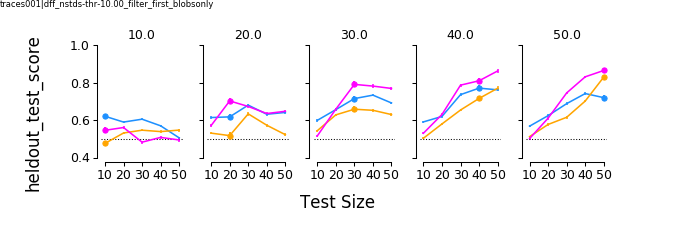

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1', 'train-1_sample-112_iter-100_overlap-0.80_heldout_test_score_split-train-test-transform')


In [480]:
# Plot.

metric = 'heldout_test_score'

fig, axn = pl.subplots(1, 5, figsize=(9,3), sharey=True, sharex=False)
sizes = sdf['size'].unique()

marker='o'
markersize=5
for ax, (train_transform, traindf) in zip(axn.flat, results.groupby(['train_transform'])):
    
    for visual_area, vdf in traindf.groupby(['visual_area']):

        mean_vals = vdf.groupby(['test_transform']).mean()[metric]
        sem_vals = vdf.groupby(['test_transform']).sem()[metric]
        xv = vdf.groupby(['test_transform']).mean().index.values

        ax.errorbar(xv, mean_vals, yerr=sem_vals, color=area_colors[visual_area])
        train_ix = list(sizes).index(train_transform)
        
        ax.errorbar(xv[train_ix], mean_vals.loc[train_transform], yerr=sem_vals.loc[train_transform],
                 marker=marker,markersize=markersize, color=area_colors[visual_area])
        
        ax.set_xticks(xv)
        ax.set_xticklabels([int(s) for s in xv])
    
        ax.set_title(train_transform)
        
    if metric =='heldout_test_score':
        ax.set_ylim([0.4, 1])
        ax.axhline(y=0.5, linestyle=':', color='k', lw=1)
    
fig.text(0.5, 0.1, 'Test Size', ha="center", va="center", fontsize=16)
fig.text(0.05,0.5, metric, ha="center", va="center", rotation=90, fontsize=16)
pl.subplots_adjust(left=0.15, right=0.9, top=0.8, bottom=0.3, wspace=0.3)
sns.despine(trim=True, offset=4)

putils.label_figure(fig, data_id)

figname = '%s_%s_split-train-test-transform' % (plot_str, metric)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [481]:
print(metric)

heldout_test_score


In [87]:
test_minus_train=True
sizes = sdf['size'].unique()

metric = 'heldout_test_score'
r_list = []
for visual_area, vdf in results.groupby(['visual_area']):
    for train_transform, traindf in vdf.groupby(['train_transform']):
        t_sizes = [t for t in sizes if t!=train_transform]
        
        curr_train_vals = traindf[traindf['test_transform']==train_transform][metric].values
        curr_iters = traindf[traindf['test_transform']==train_transform]['iteration'].values
        for test_transform in sizes:
            curr_test_vals = traindf[traindf['test_transform']==test_transform][metric].values
            #rel_scores = (curr_train_vals - curr_test_vals) #* curr_train_vals
            if test_minus_train:
                rel_scores = (curr_test_vals - curr_train_vals) #* curr_train_vals
            else:
                rel_scores = (curr_train_vals - curr_test_vals) #* curr_train_vals
            reldf = pd.DataFrame({metric: rel_scores,
                                  'iteration': curr_iters})
            
            add_info = {'visual_area': visual_area, 'train_transform': train_transform, 
                        'test_transform': test_transform}
            reldf = putils.add_meta_to_df(reldf, add_info)
            r_list.append(reldf)
reldf = pd.concat(r_list, axis=0).reset_index(drop=True) 

<IPython.core.display.Javascript object>


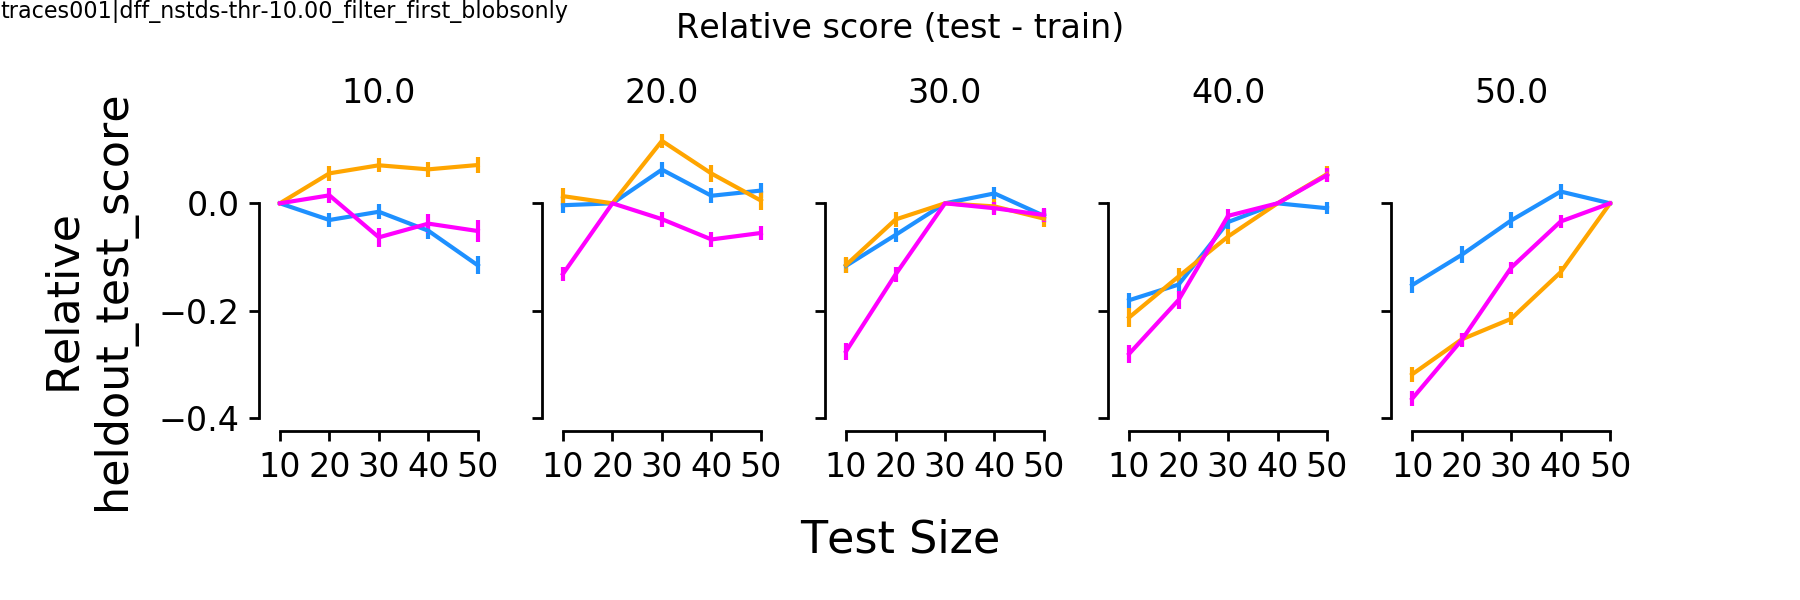

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1', 'train-1_sample-112_iter-100_overlap-0.80_heldout_test_score_split-train-test-transform_RELATIVE-subtract-train')


In [89]:
fig, axn = pl.subplots(1, 5, figsize=(9,3), sharey=True, sharex=False)

for ax, (train_transform, traindf) in zip(axn.flat, reldf.groupby(['train_transform'])):
    
    for visual_area, vdf in traindf.groupby(['visual_area']):

#         mean_vals = vdf[vdf['test_transform']!=train_transform].groupby(['test_transform']).mean()[metric]
#         sem_vals = vdf[vdf['test_transform']!=train_transform].groupby(['test_transform']).sem()[metric]
#         xv = vdf[vdf['test_transform']!=train_transform].groupby(['test_transform']).mean().index.values
        mean_vals = vdf.groupby(['test_transform']).mean()[metric]
        sem_vals = vdf.groupby(['test_transform']).sem()[metric]
        xv = vdf.groupby(['test_transform']).mean().index.values

        ax.errorbar(xv, mean_vals, yerr=sem_vals, color=area_colors[visual_area])

        #ax.axhline(y=0.5, color='k', linestyle=':')
        #ax.set_ylim([0.4, 1])
        ax.set_xticks(xv)
        ax.set_xticklabels([int(s) for s in xv])
    
        ax.set_title(train_transform)
fig.text(0.5, 0.1, 'Test Size', ha="center", va="center", fontsize=16)
fig.text(0.05,0.5, 'Relative\n%s' % metric, ha="center", va="center", rotation=90, fontsize=16)
pl.subplots_adjust(left=0.15, right=0.9, top=0.8, bottom=0.3, wspace=0.3)
sns.despine(trim=True, offset=4)
putils.label_figure(fig, data_id)

if test_minus_train:
    fig.suptitle('Relative score (test - train)')
else:
    fig.suptitle('Relative score (train - test)')

relative_calc = 'subtract-train' if test_minus_train else 'subtract-test'

figname = '%s_%s_split-train-test-transform_RELATIVE-%s' % (plot_str, metric, relative_calc)
#pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [371]:
train_str

'train-1_sample-112_iter-100'

In [372]:
plot_str

'train-1_sample-112_iter-100_overlap-0.80'

In [373]:
fig_str

'dff_nstds-thr-10.00_filter_first_blobsonly'

# Morphs

In [8]:
n_iterations = 100
sample_ncells=112
train_str = 'train-anchors-split-size_sample-%i_iter-%i' % (sample_ncells, n_iterations)  

overlap_thr=0.8
glob.glob(os.path.join(decoding_dir, 'train-anchors', '%s*.pkl' % (train_str)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors/train-anchors-split-size_sample-112_iter-100_results_1.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors/train-anchors-split-size_sample-112_iter-100_results2.pkl']

In [9]:
dst_dir = os.path.join(decoding_dir, 'train-anchors')
results_dfile = glob.glob(os.path.join(dst_dir, '%s*.pkl' % (train_str)))[1]
with open(results_dfile, 'rb') as f:
    results = pkl.load(f)

results_basename = os.path.splitext(os.path.split(results_dfile)[-1])[0]
print("File basename: %s" % results_basename)

File basename: train-anchors-split-size_sample-112_iter-100_results2


In [10]:
plot_str = '%s_overlap-%.2f' % (train_str, overlap_thr)
fig_str = '%s_%s' % (response_str, filter_str)
data_id = '%s|%s' % (traceid, fig_str)
print(data_id)

traces001|dff_nstds-thr-10.00_filter_first_blobsonly


<IPython.core.display.Javascript object>


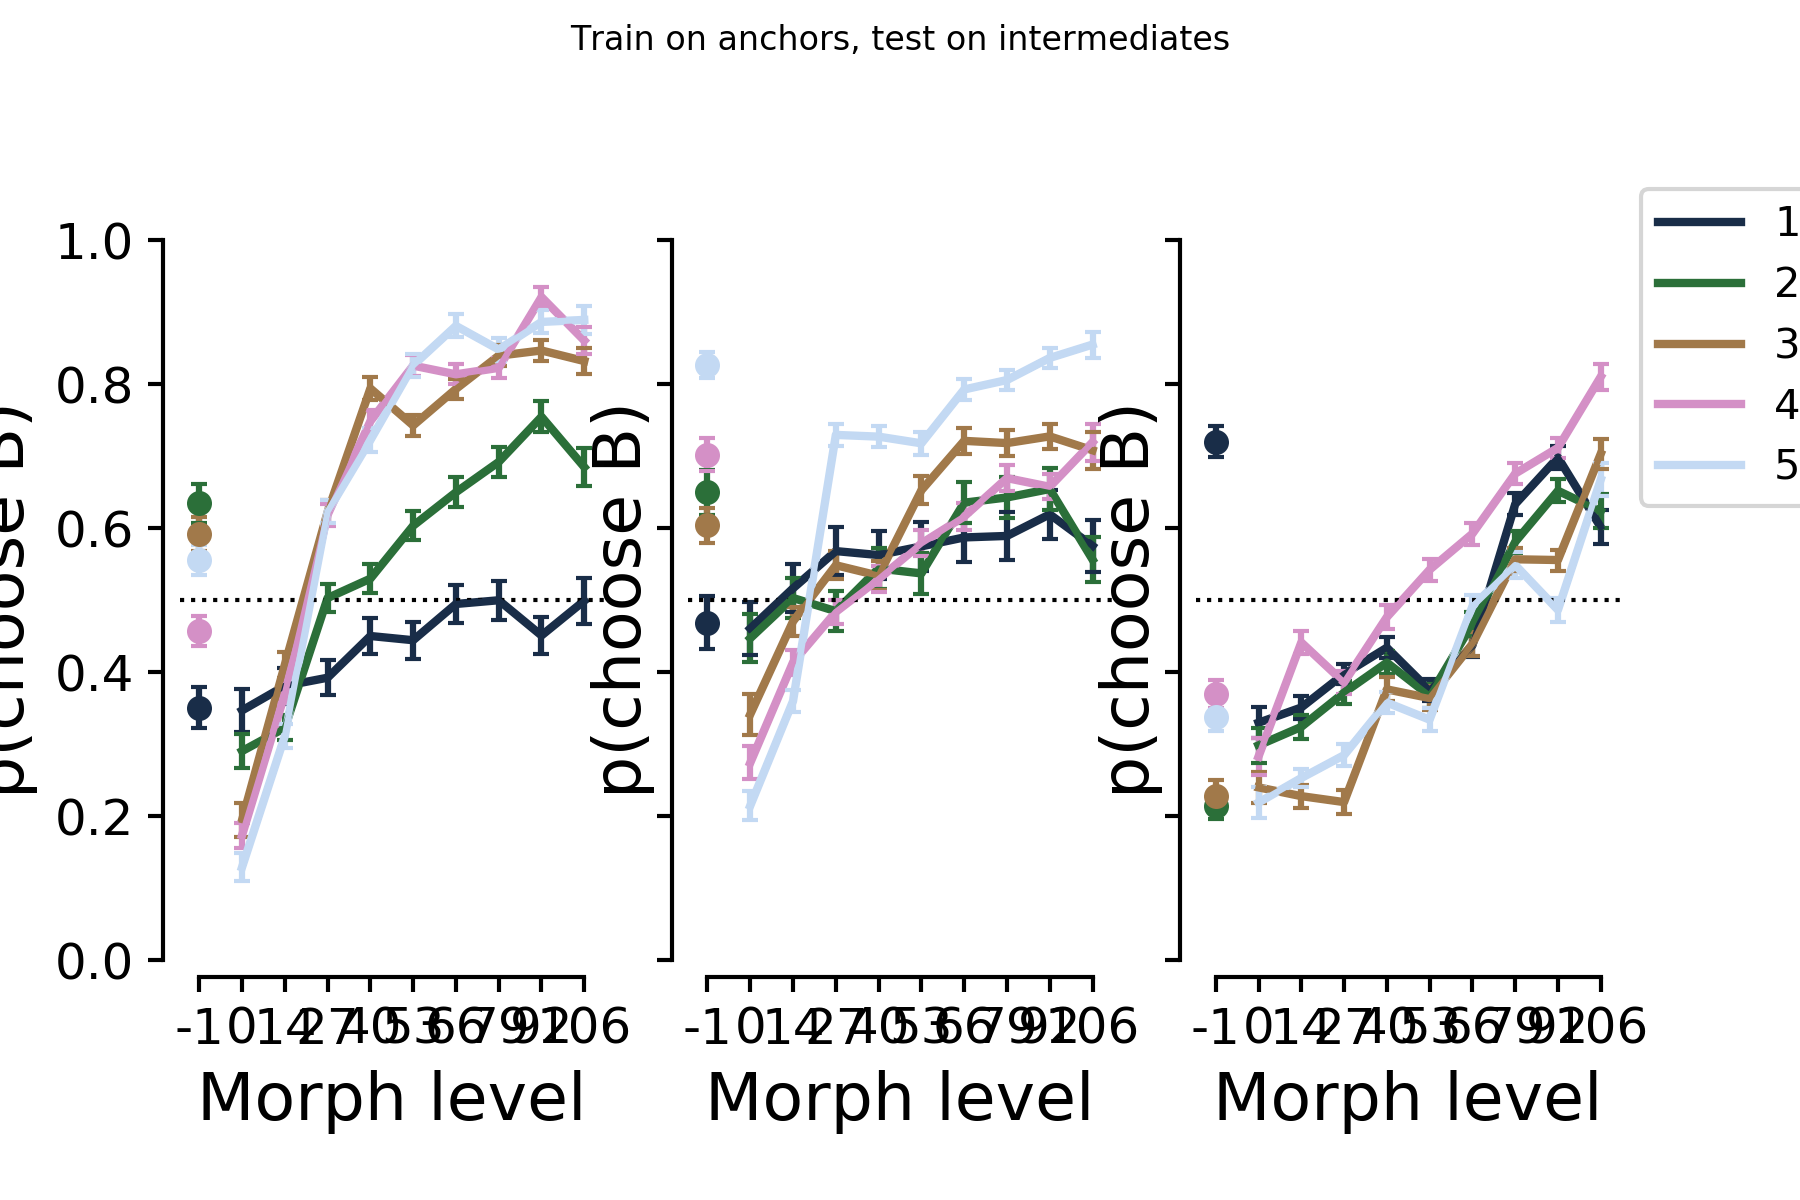

Text(0.5,0.98,u'Train on anchors, test on intermediates')

In [32]:
hue_size = True
col_name = 'morphlevel'
markersize=5
capsize=2
lw=2
alpha = 1

fig, axn = pl.subplots(1, 3, figsize=(6,4), sharex=True, sharey=True, dpi=150)
alphas = np.linspace(0.1, 1, 5)
ci = 95
shade=False
plot_ci=False
plot_luminance= True

plot_str = 'wLum' if plot_luminance else ''
plot_str = '%s_ci%i' % (plot_str, ci) if plot_ci else plot_str

for visual_area, vdf in results.groupby(['visual_area']):
    ai = visual_areas.index(visual_area)
    ax = axn[ai]
    size_colors = sns.color_palette('cubehelix', n_colors=5)
    
    for si, (sz, df_) in enumerate(vdf.groupby(['size'])):
        morphlevels = sorted([s for s in sdf['morphlevel'].unique() if s!=-1])
        xvs = np.arange(1, len(morphlevels)+1) #if plot_luminance else np.arange(0, len(morphlevels))
        
        curr_color = size_colors[si] if hue_size else area_colors[visual_area]
        
        if plot_luminance:
            # plot luminance control
            control_val=-1
            if plot_ci:
                ctl, ctl_lo, ctl_hi = calculate_ci(df_[df_[col_name]==control_val]['p_chooseB'].values, ci=ci)
                yerr = [abs(np.array([ctl-ctl_lo])), abs(np.array([ctl_hi-ctl]))]
            else:
                ctl = df_[df_[col_name]==control_val]['p_chooseB'].mean()
                yerr = df_[df_[col_name]==control_val]['p_chooseB'].sem()

            ax.errorbar(0, ctl, yerr=yerr, color=curr_color,
                           marker='o', markersize=markersize, capsize=capsize, alpha=alpha)
            
        # plot morph curves
        if plot_ci:
            ci_vals = dict((val, calculate_ci(g['p_chooseB'].values, ci=ci)) \
                             for val, g in df_[df_[col_name].isin(morphlevels)].groupby([col_name]))
            mean_vals = np.array([ci_vals[k][0] for k in morphlevels])
            lowers = np.array([ci_vals[k][1] for k in morphlevels])
            uppers =  np.array([ci_vals[k][2] for k in morphlevels])
            yerr = [np.array([mean_vals - lowers]), np.array([mean_vals-uppers])]
        else:
            mean_vals = df_[df_[col_name].isin(morphlevels)].groupby([col_name]).mean()['p_chooseB']
            yerr = df_[df_[col_name].isin(morphlevels)].groupby([col_name]).sem()['p_chooseB']

        ax.plot(xvs, mean_vals, color=curr_color, lw=lw, alpha=alpha, label=sz)
        ax.errorbar(xvs, mean_vals, yerr=yerr, color=curr_color,
                          capsize=capsize, alpha=alpha, label=None)
        ax.set_ylim([0, 1])

    xticks = np.arange(0, len(morphlevels)+1) if plot_luminance else xvs
    xlabels = sdf['morphlevel'].unique() if plot_luminance \
                    else sdf[sdf['morphlevel']!=-1]['morphlevel'].unique()
    ax.set_xticks(xticks)
    ax.set_xticklabels( [int(m) for m in sorted(xlabels)] )
    ax.set_ylabel('p(choose B)')
    ax.set_xlabel('Morph level')
    
    
    ax.axhline(y=0.5, linestyle=':', color='k', lw=1)

    if ai==2:
        ax.legend(bbox_to_anchor=(1, 1.1))                               

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
sns.despine(trim=True, offset=4)
pl.suptitle("Train on anchors, test on intermediates", fontsize=8)


In [35]:
reload(dutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.py'>

<IPython.core.display.Javascript object>


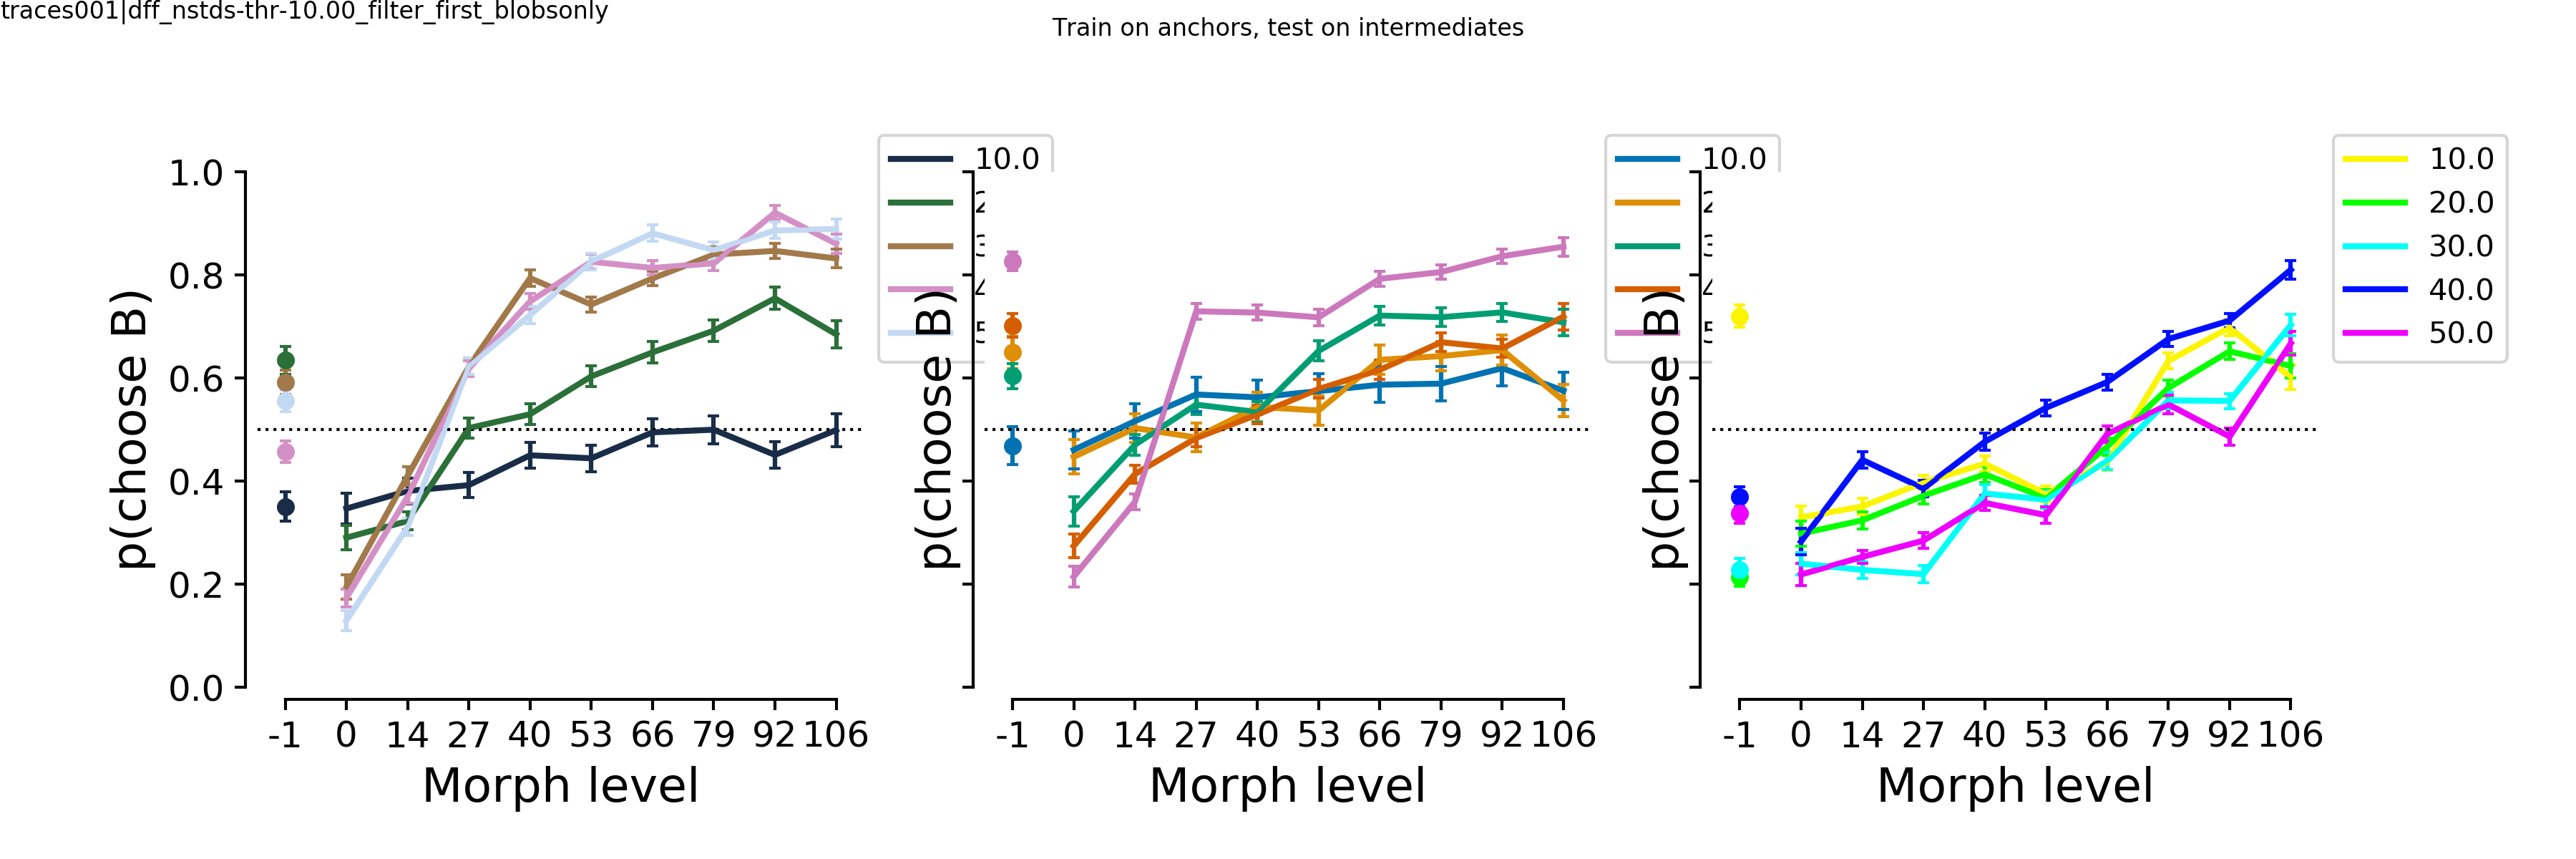

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors', 'train-anchors-split-size_sample-112_iter-100_morphcurves_split-size__wLum')


In [36]:
dutils.default_morphcurves_split_size(results, sdf, area_colors=area_colors, dst_dir=dst_dir, data_id=data_id,
                                    lw=lw, train_str=train_str, capsize=2, hue_size=True)